<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Indices/USA500/USA500_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "USSPX"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  13.94  13.94  13.94  13.94      10.76       0
2009-01-05  13.88  13.88  13.88  13.88      10.71       0
2009-01-06  13.99  13.99  13.99  13.99      10.80       0
2009-01-07  13.58  13.58  13.58  13.58      10.48       0
2009-01-08  13.62  13.62  13.62  13.62      10.51       0
...           ...    ...    ...    ...        ...     ...
2018-12-24  33.02  33.02  33.02  33.02      32.74       0
2018-12-26  34.66  34.66  34.66  34.66      34.36       0
2018-12-27  34.96  34.96  34.96  34.96      34.66       0
2018-12-28  34.92  34.92  34.92  34.92      34.62       0
2018-12-31  35.22  35.22  35.22  35.22      34.92       0

[2516 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000  2516.0
mean     25.540759    25.540759    25.540759    25.540759    22.864754     0.0
std       7.708479     7.708479     7.708479     7.708479     8.452692     0.0
min      10.180000    10.180000    10.180000    10.180000     7.860000     0.0
25%      19.197500    19.197500    19.197500    19.197500    15.475000     0.0
50%      25.830000    25.830000    25.830000    25.830000    22.960000     0.0
75%      30.380000    30.380000    30.380000    30.380000    28.017500     0.0
max      41.790000    41.790000    41.790000    41.790000    40.630000     0.0

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2009-03-17  11.72  11.72  11.72  11.72       9.05   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  11.350911  11.165712  10.371966  11.393659  11.194780  11.153990      10.950      10.950  10.441693  10.98875  11.661462  11.0180  11.239444  10.98875  11.486667  11.064827               12.018626                 10.98875                9.958874               12.533563                 10.98875                9.443937               13.048501                 10.98875                8.928999               13.563439                 10.98875                8.414061  11.194780  11.496737  10.996321               12.224656                11.194780               10.164905               12.739594                11.194780                9.649967               13.254532                11.194780                9.135029               13.769469                11.194780   
2009-03-18  11.96  11.96  11.96  11.96       9.23   18          2         77             31             0               0               0                 0      3        1    12        2             3          12  11.381366  11.171104  10.479808  11.651772  11.364829  11.425735      11.070      11.070  10.543958  11.19875  11.928559  11.2315  11.455278  11.19875  11.840000  11.067729               12.249818                 11.19875               10.147682               12.775352                 11.19875                9.622148               13.300886                 11.19875                9.096614               13.826420                 11.19875                8.571080  11.364829  11.837132  11.016416               12.415897                11.364829               10.313761               12.941431                11.364829                9.788227               13.466965                11.364829                9.262693               13.992499                11.364829   
2009-03-19  11.81  11.81  11.81  11.81       9.12   19          3         78     

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000    2466.000000   2466.000000     2466.000000     2466.000000       2466.000000  2466.000000  2466.000000  2466.000000  2466.000000   2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000  2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000  2466.000000  2466.000000  2466.000000             2466.000000              2466.000000             2466.000000             2466.000000              2466.000000             2466.000000             2466.000000   
mean     25.812437    25.812437    25.812437    25.812437    23.138337    15.760746     2.021087   186.704380      30.468775      0.034063        0.031225        0.011354          0.008516     6.641525     2.544607    27.069749     2.021087      2.021492    27.069749    25.767342    25.691878     5.854877    25.813268    25.778423    25.763085    25.759939    25.759939    25.640912    25.778970    25.812366    25.778950    25.790087    25.778970    25.804578    25.707829               26.220427                25.778970               25.337513               26.441155                25.778970               25.116785               26.661883                25.778970               24.896057               26.882612                25.778970               24.675328    25.778423    25.805113    25.718743               26.219879                25.778423               25.336966               26.440608                25.778423               25.116238               26.661336   
std       7.542547     7.542547     7.542547     7.542547     8.313678     8.748198     1.399348   103.526821       0.778018      0.181429        0.173960        0.105972          0.091906     3.389107     1.103855    14.810637     1.399348      1.414480    14.810637     7.550824     7.561919    26.137560     7.544182     7.548274     7.546558     7.547942     7.547942     7.566865     7.550649     7.542331     7.551339     7.546770     7.550649     7.542793     7.564547                7.607559                 7.550649                7.505570                7.640371                 7.550649                7.487536                7.676038                 7.550649                7.472536                7.714522                 7.550649                7.460588     7.548274     7.542776     7.563229                7.605235                 7.548274                7.503147                7.638073                 7.548274                7.485091                7.673767   
min      11.570000    11.570000    11.570000    11.570000     8.930000     1.000000     0.0000

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-17  0.004964  0.004964  0.004964  0.004964   0.003785   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  0.000000  0.000000  0.627584  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000000                0.002049                 0.000000                0.000000                0.008017                 0.000000                0.000000                0.013763                 0.000000                0.000000  0.000000  0.000000  0.000000                0.002900                 0.000000                0.000000                0.009030                 0.000000                0.000000                0.014924                 0.000000                0.000000                0.020597                 0.000000   
2009-03-18  0.012905  0.012905  0.012905  0.012905   0.009464   18          2         77             31             0               0               0                 0      3        1    12        2             3          12  0.001011  0.000179  0.628882  0.008517  0.005604  0.008972    0.003923    0.003923  0.003262  0.006871  0.008876  0.006980  0.007109  0.006871  0.011662  0.000096                0.007569                 0.006871                0.006030                0.009844                 0.006871                0.005619                0.016000                 0.006871                0.005219                0.021925                 0.006871                0.004828  0.005604  0.011254  0.000660                0.009253                 0.005604                0.004784                0.015604                 0.005604                0.004387                0.021711                 0.005604                0.003999                0.027588                 0.005604   
2009-03-19  0.007942  0.007942  0.007942  0.007942   0.005994   19          3         78

52

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         6 hours 17 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_nx7m2f
H2O cluster total nodes:    1
H2O cluster free memory:    8.45 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.541880  17.068651              0.500000  0.724346  0.524677
1              DeepLearning_1_AutoML_20190824_191203  0.506077  15.780577              0.487288  0.685421  0.469803
2  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.505683  15.831064              0.490803  0.686550  0.471350
3  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.505124  16.106004              0.500000  0.691181  0.477731
4  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.500328  16.400789              0.500000  0.691182  0.477733
5  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.500000   0.700882              0.500000  0.503773  0.253787
6  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.500000   0.702358              0.500000  0.504481  0.254501
7  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.500000   0.699983              0.500000  0.503340  0.253351
8  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.500000   0.697265              0.500000  0.502022  0.252026
9  DeepLearning_grid_1_AutoML_20190824_191203_mod...  0.470897  13.764544              0.495763  0.686804  0.471700

variable  relative_importance  scaled_importance  percentage
0                        TANH             1.000000           1.000000    0.005032
1              is_quarter_end             0.761657           0.761657    0.003832
2                        SINH             0.712278           0.712278    0.003584
3            is_quarter_start             0.690680           0.690680    0.003475
4                        COSH             0.685268           0.685268    0.003448
..                        ...                  ...                ...         ...
964   BBANDS_lowerband_12_5_2             0.169104           0.169104    0.000851
965  BBANDS_middleband_30_7_4             0.168990           0.168990    0.000850
966   BBANDS_upperband_20_7_5             0.168465           0.168465    0.000848
967                   MA_24_1             0.167847           0.167847    0.000845
968  BBANDS_middleband_20_0_5             0.164454           0.164454    0.000827

[969 rows x 4 columns]

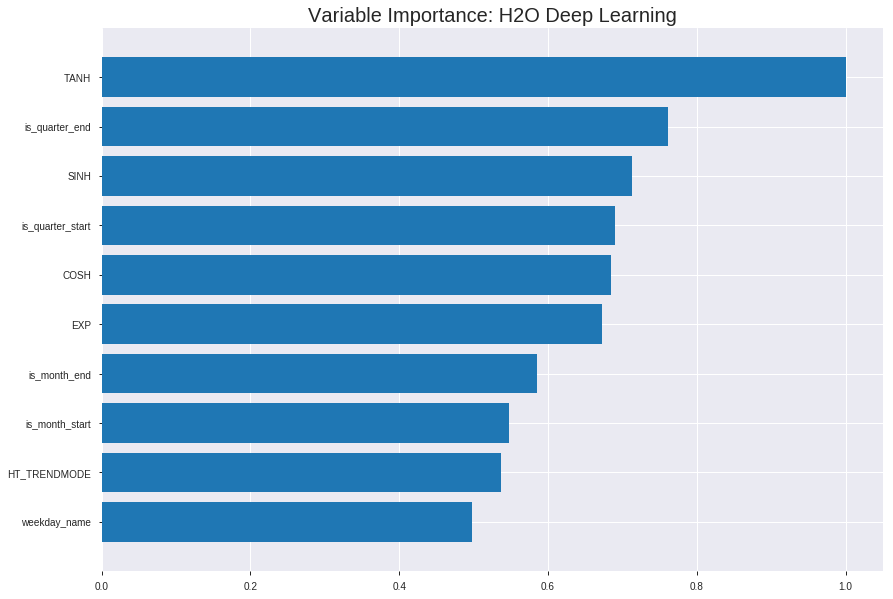

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_191203_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25966879696965584
RMSE: 0.5095770765739525
LogLoss: 0.7545181413196419
Mean Per-Class Error: 0.44250848161739254
AUC: 0.556971543308177
pr_auc: 0.6174989785104311
Gini: 0.113943086616354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44415426635563493: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      60   655   0.9161   (655.0/715.0)
1      27   983   0.0267   (27.0/1010.0)
Total  87   1638  0.3954   (682.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444154     0.742447  359
max f2                       0.299474     0.87628   397
max f0point5                 0.461034     0.650979  351
max accuracy                 0.461034     0.605797  351
max precision                0.991777     0.777778  1
max recall                   0.299474     1         397
max specificity              0.993497     0.998601  0
max absolute_mcc             0.458955     0.130011  353
max min_per_class_accuracy   0.651013     0.555245  212
max mean_per_class_accuracy  0.639442     0.557492  222

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 67.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.986745           1.13861   1.13861            0.666667         0.990841  0.666667                    0.990841            0.0118812       0.0118812                  13.8614   13.8614
    2        0.0202899                   0.971316           1.20559   1.17115            0.705882         0.978291  0.685714                    0.984745            0.0118812       0.0237624                  20.5591   17.1146
    3        0.0301449                   0.956492           1.10513   1.14956            0.647059         0.963678  0.673077                    0.977858            0.0108911       0.0346535                  10.5125   14.9562
    4        0.04                        0.949915           1.10513   1.13861            0.647059         0.952598  0.666667                    0.971634            0.0108911       0.0455446                  10.5125   13.8614
    5        0.0504348                   0.943014           0.85396   1.07972            0.5              0.946407  0.632184                    0.966415            0.00891089      0.0544554                  -14.604   7.972
    6        0.10029                     0.904577           1.11213   1.09583            0.651163         0.92268   0.641618                    0.944674            0.0554455       0.109901                   11.2134   9.58336
    7        0.150145                    0.874091           0.834101  1.00893            0.488372         0.889063  0.590734                    0.926209            0.0415842       0.151485                   -16.5899  0.892618
    8        0.2                         0.827094           1.01284   1.0099             0.593023         0.853713  0.591304                    0.908137            0.050495        0.20198                    1.28367   0.990099
    9        0.30029                     0.740482           1.07609   1.03201            0.630058         0.777326  0.604247                    0.864449            0.107921        0.309901                   7.60888   3.20062
    10       0.4                         0.694559           1.18164   1.06931            0.69186          0.716187  0.626087                    0.827491            0.117822        0.427723                   18.1643   6.93069
    11       0.50029                     0.654773           1.15507   1.0865             0.676301         0.673462  0.636153                    0.796614            0.115842        0.543564                   15.5068   8.64989
    12       0.6                         0.617968           0.933399  1.06106            0.546512         0.635475  0.621256                    0.769835            0.0930693       0.636634                   -6.66014  6.10561
    13       0.69971                     0.587626           1.00291   1.05277            0.587209         0.602374  0.616404                    0.745972            0.1             0.736634                   0.290698  5.27697
    14       0.8                         0.55459            0.95762   1.04084            0.560694         0.57269   0.60942                     0.724249            0.0960396       0.832673                   -4.23797  4.08416
    15       0.89971                     0.493735           0.943328  1.03003            0.552326         0.530196  0.603093                    0.702743            0.0940594       0.926733                   -5.66717  3.00347
    16       1                           0.265331           0.730556  1                  0.427746         0.4335    0.585507                    0.675741         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3580751918464214
RMSE: 0.5983938434228927
LogLoss: 2.6554823265070397
Mean Per-Class Error: 0.47347174163783157
AUC: 0.5087946943483276
pr_auc: 0.5887773880744287
Gini: 0.01758938869665516
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.794467205259374e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.79447e-06  0.73913   399
max f2                       1.79447e-06  0.876289  399
max f0point5                 1.79447e-06  0.639098  399
max accuracy                 1.79447e-06  0.586207  399
max precision                0.974501     0.727273  10
max recall                   1.79447e-06  1         399
max specificity              0.986723     0.995098  0
max absolute_mcc             0.985891     0.075964  1
max min_per_class_accuracy   0.699652     0.512111  220
max mean_per_class_accuracy  0.729588     0.526528  201

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 57.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.978358           1.02353   1.02353            0.6              0.98456      0.6                         0.98456             0.0103806       0.0103806                  2.35294   2.35294
    2        0.020284                    0.974637           1.36471   1.19412            0.8              0.976742     0.7                         0.980651            0.0138408       0.0242215                  36.4706   19.4118
    3        0.030426                    0.967693           1.02353   1.13725            0.6              0.971228     0.666667                    0.97751             0.0103806       0.0346021                  2.35294   13.7255
    4        0.040568                    0.961781           0.341176  0.938235           0.2              0.965002     0.55                        0.974383            0.00346021      0.0380623                  -65.8824  -6.17647
    5        0.0507099                   0.956303           1.02353   0.955294           0.6              0.959973     0.56                        0.971501            0.0103806       0.0484429                  2.35294   -4.47059
    6        0.10142                     0.935345           0.955294  0.955294           0.56             0.945691     0.56                        0.958596            0.0484429       0.0968858                  -4.47059  -4.47059
    7        0.150101                    0.919382           1.06618   0.991256           0.625            0.928273     0.581081                    0.948761            0.0519031       0.148789                   6.61765   -0.874404
    8        0.200811                    0.900514           1.02353   0.999406           0.6              0.909504     0.585859                    0.938848            0.0519031       0.200692                   2.35294   -0.0594177
    9        0.300203                    0.851753           1.0096    1.00278            0.591837         0.880406     0.587838                    0.919499            0.100346        0.301038                   0.960384  0.278219
    10       0.399594                    0.777806           1.07923   1.0218             0.632653         0.820716     0.598985                    0.894929            0.107266        0.408304                   7.92317   2.17976
    11       0.501014                    0.699652           1.02353   1.02215            0.6              0.739067     0.59919                     0.863378            0.103806        0.512111                   2.35294   2.21481
    12       0.600406                    0.605719           0.97479   1.01431            0.571429         0.6567       0.594595                    0.829164            0.0968858       0.608997                   -2.52101  1.43084
    13       0.699797                    0.407503           1.04442   1.01858            0.612245         0.50708      0.597101                    0.783419            0.103806        0.712803                   4.44178   1.85848
    14       0.799189                    0.104567           0.835534  0.99582            0.489796         0.248754     0.583756                    0.716925            0.083045        0.795848                   -16.4466  -0.418035
    15       0.89858                     1.07676e-06        1.11405   1.0089             0.653061         0.0232961    0.591422                    0.640203            0.110727        0.906574                   11.4046   0.889656
    16       1                           3.3614e-61         0.921176  1                  0.54     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:15:02  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 19:15:04  3 min  0.222 sec  576 obs/sec       0.647536  1             1117       0.626003         3.75615             -0.614745      0.515677        0.366034           1.25847          0.414493                         0.708624           10.2281               -1.07013         0.496811          0.591097             0.682353           0.413793
    2019-08-24 19:15:18  3 min 14.226 sec  601 obs/sec       5.12232   8             8836       0.597521         2.71696             -0.47115       0.529941        0.439725           1.13861          0.402899                         0.697707           11.6699               -1.00684         0.504173          0.555788             1.02353            0.413793
    2019-08-24 19:15:32  3 min 27.784 sec  613 obs/sec       9.60348   15            16566      0.580937         1.5487              -0.39062       0.543677        0.586982           1.04373          0.396522                         0.701014           10.6299               -1.02591         0.50486           0.596038             1.02353            0.413793
    2019-08-24 19:15:45  3 min 41.045 sec  622 obs/sec       14.087    22            24300      0.563748         1.18852             -0.309547      0.523612        0.598415           1.13861          0.406377                         0.688038           6.77909               -0.951601        0.501679          0.590018             0.341176           0.413793
    2019-08-24 19:15:58  3 min 54.071 sec  629 obs/sec       18.5583   29            32013      0.547946         1.14529             -0.237163      0.514637        0.582834           1.04373          0.408696                         0.642397           7.01673               -0.701271        0.49157           0.344501             1.03146            0.40568
    2019-08-24 19:16:11  4 min  6.759 sec  638 obs/sec       23.0568   36            39773      0.516508         0.735059            -0.0992731     0.533461        0.617263           1.13861          0.413333                         0.653475           6.10066               -0.760453        0.498211          0.582201             1.02353            0.413793
    2019-08-24 19:16:23  4 min 19.188 sec  645 obs/sec       27.48     43            47403      0.535143         0.825001            -0.180021      0.533701        0.608164           0.948845         0.413913                         0.691609           6.64025               -0.971911        0.500924          0.589127             0.682353           0.413793
    2019-08-24 19:16:37  4 min 33.187 sec  652 obs/sec       32.6475   51            56317      0.519892         0.768448            -0.113724      0.537691        0.606053           1.04373          0.413333                         0.680329           6.42138               -0.908109        0.502663          0.593376             1.02353            0.413793
    2019-08-24 19:16:51 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
TANH                      1.0                    1.0                  0.00503178667979775
is_quarter_end            0.7616565823554993     0.7616565823554993   0.0038324934456766793
SINH                      0.7122781872749329     0.7122781872749329   0.0035840318950404945
is_quarter_start          0.6906802654266357     0.6906802654266357   0.0034753557595729205
COSH                      0.6852675080299377     0.6852675080299377   0.0034481199190032384
---                       ---                    ---                  ---
BBANDS_lowerband_12_5_2   0.16910448670387268    0.16910448670387268  0.0008508977036905823
BBANDS_middleband_30_7_4  0.16899044811725616    0.16899044811725616  0.0008503238858494624
BBANDS_upperband_20_7_5   0.16846482455730438    0.16846482455730438  0.0008476790602219091
MA_24_1                   0.16784656047821045    0.16784656047821045  0.0008445680872641269
BBANDS_middleband_20_0_5  0.16445377469062805    0.16445377469062805  0.0008274963129307626


See the whole table with table.as_data_frame()


('accuracy', 0.5384615384615384)

('F1', 0.6861702127659575)

('auc', 0.5418801734331888)

('logloss', 17.068650813521174)

('mean_per_class_error', 0.4516160819865983)

('rmse', 0.7243459484137793)

('mse', 0.5246770529834575)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


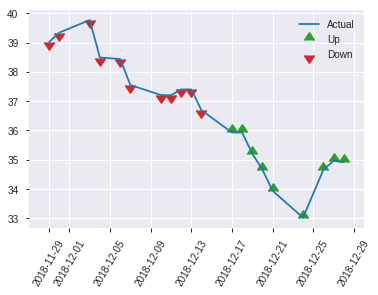


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5246770529834575
RMSE: 0.7243459484137793
LogLoss: 17.068650813521174
Mean Per-Class Error: 0.4516160819865983
AUC: 0.5418801734331888
pr_auc: 0.5640894979500464
Gini: 0.08376034686637768
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.2222329221649377e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.22223e-48  0.68617   71
max f2                       2.22223e-48  0.845347  71
max f0point5                 2.22223e-48  0.57744   71
max accuracy                 2.30027e-44  0.538462  68
max precision                0.999178     1         0
max recall                   2.22223e-48  1         71
max specificity              0.999178     1         0
max absolute_mcc             3.48801e-21  0.119409  35
max min_per_class_accuracy   2.30027e-44  0.325581  68
max mean_per_class_accuracy  2.30027e-44  0.548384  68

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  2.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.987297           1.27649   1.27649            0.666667         0.994778      0.666667                    0.994778            0.0155039       0.0155039                  27.6486   27.6486
    2        0.0202429                   0.963467           0         0.765891           0                0.979255      0.4                         0.988569            0               0.0155039                  -100      -23.4109
    3        0.0323887                   0.0259759          0.638243  0.718023           0.333333         0.613982      0.375                       0.848099            0.00775194      0.0232558                  -36.1757  -28.1977
    4        0.0404858                   7.87529e-07        1.91473   0.957364           1                0.0104294     0.5                         0.680565            0.0155039       0.0387597                  91.4729   -4.26357
    5        0.0526316                   2.48512e-09        1.27649   1.03101            0.666667         2.67788e-07   0.538462                    0.523512            0.0155039       0.0542636                  27.6486   3.10078
    6        0.101215                    1.83149e-16        1.27649   1.14884            0.666667         2.57112e-10   0.6                         0.272226            0.0620155       0.116279                   27.6486   14.8837
    7        0.149798                    9.63877e-22        1.43605   1.24199            0.75             2.67924e-17   0.648649                    0.183937            0.0697674       0.186047                   43.6047   24.1986
    8        0.202429                    7.09269e-27        0.883721  1.14884            0.461538         1.95445e-22   0.6                         0.136113            0.0465116       0.232558                   -11.6279  14.8837
    9        0.299595                    2.0195e-47         1.19671   1.16436            0.625            8.26978e-29   0.608108                    0.0919683           0.116279        0.348837                   19.6705   16.4362
    10       0.40081                     3.73343e-65        1.07225   1.1411             0.56             8.5011e-49    0.59596                     0.0687439           0.108527        0.457364                   7.22481   14.1101
    11       0.502024                    1.06866e-86        0.91907   1.09634            0.48             1.73484e-66   0.572581                    0.0548843           0.0930233       0.550388                   -8.09302  9.63366
    12       0.59919                     7.29946e-125       1.03714   1.08674            0.541667         4.73843e-89   0.567568                    0.0459841           0.100775        0.651163                   3.71447   8.67379
    13       0.700405                    9.85334e-185       0.765891  1.04037            0.4              3.70557e-130  0.543353                    0.039339            0.0775194       0.728682                   -23.4109  4.03728
    14       0.797571                    5.4767e-308        0.877584  1.02054            0.458333         2.29454e-189  0.532995                    0.0345464           0.0852713       0.813953                   -12.2416  2.05407
    15       1                           0                  0.91907   1                  0.48             3.90753e-313  0.522267                    0.0275532           0.186047        1                          -8.09302  0

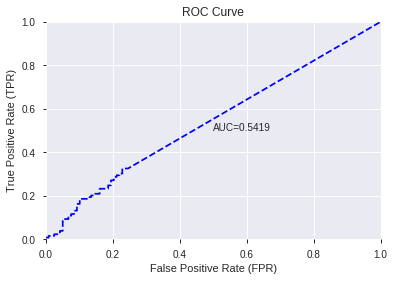

This function is available for GLM models only


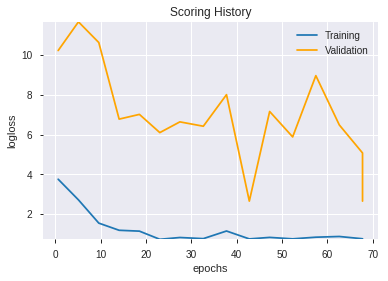

--2019-08-24 19:39:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.201.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.201.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_191203_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_191203_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_193952_model_7  0.573676  16.124336              0.500000  0.722082  0.521403
1  DeepLearning_grid_1_AutoML_20190824_193952_model_4  0.522829  17.599567              0.500000  0.720093  0.518534
2  DeepLearning_grid_1_AutoML_20190824_193952_model_8  0.505551  15.867548              0.500000  0.690469  0.476747
3  DeepLearning_grid_1_AutoML_20190824_193952_model_6  0.500328  16.405604              0.500000  0.691182  0.477733
4  DeepLearning_grid_1_AutoML_20190824_193952_model_3  0.500000  16.494073              0.500000  0.691182  0.477733
5  DeepLearning_grid_1_AutoML_20190824_193952_model_2  0.500000  16.500306              0.500000  0.691182  0.477733
6  DeepLearning_grid_1_AutoML_20190824_193952_model_9  0.499672   0.694260              0.500000  0.500553  0.250553
7               DeepLearning_1_AutoML_20190824_193952  0.494876  17.903139              0.500000  0.721139  0.520042
8  DeepLearning_grid_1_AutoML_20190824_193952_model_1  0.494810  17.879008              0.500000  0.719874  0.518219
9  DeepLearning_grid_1_AutoML_20190824_193952_model_5  0.471456  13.911201              0.491164  0.688759  0.474389

variable  relative_importance  scaled_importance  percentage
0      days_in_month             1.000000           1.000000    0.021438
1       STOCHF_fastk             0.990360           0.990360    0.021231
2                SIN             0.972046           0.972046    0.020838
3            NATR_30             0.970146           0.970146    0.020798
4       HT_TRENDMODE             0.968100           0.968100    0.020754
5        HT_DCPERIOD             0.965412           0.965412    0.020696
6       is_month_end             0.961109           0.961109    0.020604
7             ADX_20             0.960659           0.960659    0.020594
8          dayofyear             0.957584           0.957584    0.020528
9              VAR_8             0.952698           0.952698    0.020424
10               day             0.951647           0.951647    0.020401
11           ADXR_12             0.950286           0.950286    0.020372
12      aroondown_30             0.949811           0.949811    0.020362
13      weekday_name             0.948402           0.948402    0.020332
14       STOCH_slowd             0.946093           0.946093    0.020282
15    STOCHRSI_fastk             0.945189           0.945189    0.020263
16              COSH             0.943810           0.943810    0.020233
17            VAR_14             0.942967           0.942967    0.020215
18         aroonup_8             0.942660           0.942660    0.020208
19           weekday             0.942178           0.942178    0.020198
20           quarter             0.938266           0.938266    0.020114
21    is_month_start             0.935678           0.935678    0.020059
22              SINH             0.934682           0.934682    0.020037
23         dayofweek             0.932996           0.932996    0.020001
24               COS             0.932560           0.932560    0.019992
25      aroondown_14             0.931974           0.931974    0.019979
26            SAREXT             0.931193           0.931193    0.019963
27            ADX_24             0.929910           0.929910    0.019935
28  is_quarter_start             0.929266           0.929266    0.019921
29             month             0.928302           0.928302    0.019901
30              week             0.927834           0.927834    0.019891
31       aroondown_8             0.927125           0.927125    0.019875
32            ADX_12             0.924236           0.924236    0.019813
33        aroonup_24             0.923477           0.923477    0.019797
34        weekofyear             0.922693           0.922693    0.019780
35              TANH             0.920755           0.920755    0.019739
36            ADX_14             0.919923           0.919923    0.019721
37               TAN             0.915560           0.915560    0.019627
38             ADX_8             0.914256           0.914256    0.019600
39            VAR_20             0.908293           0.908293    0.019472
40        AROONOSC_8             0.907646           0.907646    0.019458
41        aroonup_14             0.907643           0.907643    0.019458
42    is_quarter_end             0.903831           0.903831    0.019376
43      aroondown_24             0.903462           0.903462    0.019368
44        aroonup_12             0.902837           0.902837    0.019355
45           ADXR_14             0.897994           0.897994    0.019251
46      aroondown_20             0.894622           0.894622    0.019179
47       AROONOSC_20             0.887611           0.887611    0.019028
48            VAR_12             0.881866           0.881866    0.018905
49               EXP             0.869205           0.869205    0.018634

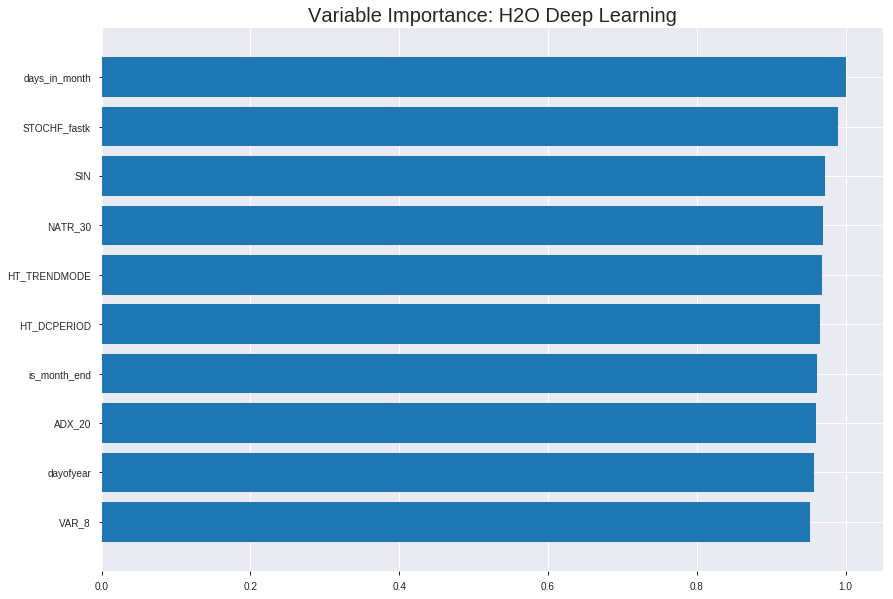

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_193952_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22220687459551913
RMSE: 0.47138824189357875
LogLoss: 0.6320181490329698
Mean Per-Class Error: 0.36560617600221557
AUC: 0.6903427265803503
pr_auc: 0.7589310232452575
Gini: 0.3806854531607007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3584200824905522: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      175  540   0.7552   (540.0/715.0)
1      71   939   0.0703   (71.0/1010.0)
Total  246  1479  0.3542   (611.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35842      0.75452   305
max f2                       0.183334     0.879791  378
max f0point5                 0.465275     0.696478  230
max accuracy                 0.423399     0.648696  261
max precision                0.99463      1         0
max recall                   0.183334     1         378
max specificity              0.99463      1         0
max absolute_mcc             0.56854      0.267923  153
max min_per_class_accuracy   0.484643     0.627723  214
max mean_per_class_accuracy  0.476126     0.634394  221

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 50.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.907551           1.61304   1.61304            0.944444         0.957789  0.944444                    0.957789            0.0168317       0.0168317                  61.3036   61.3036
    2        0.0202899                   0.859956           1.70792   1.65912            1                0.885948  0.971429                    0.922895            0.0168317       0.0336634                  70.7921   65.9123
    3        0.0301449                   0.833216           1.60745   1.64223            0.941176         0.846221  0.961538                    0.897828            0.0158416       0.049505                   60.7455   64.2232
    4        0.04                        0.803168           1.60745   1.63366            0.941176         0.817695  0.956522                    0.878085            0.0158416       0.0653465                  60.7455   63.3663
    5        0.0504348                   0.774427           1.42327   1.59013            0.833333         0.789947  0.931034                    0.85985             0.0148515       0.080198                   42.3267   59.0133
    6        0.10029                     0.704046           1.41003   1.5006             0.825581         0.735143  0.878613                    0.797857            0.070297        0.150495                   41.0028   50.0601
    7        0.150145                    0.658357           1.35045   1.45074            0.790698         0.681547  0.849421                    0.759237            0.0673267       0.217822                   35.0449   45.0744
    8        0.2                         0.623903           1.23129   1.39604            0.72093          0.639245  0.817391                    0.729326            0.0613861       0.279208                   23.1292   39.604
    9        0.30029                     0.572367           1.22417   1.33864            0.716763         0.5956    0.783784                    0.684664            0.122772        0.40198                    22.4174   33.8641
    10       0.4                         0.528331           1.07242   1.27228            0.627907         0.549086  0.744928                    0.650868            0.106931        0.508911                   7.24154   27.2277
    11       0.50029                     0.491653           0.987237  1.21514            0.578035         0.509694  0.711472                    0.622568            0.0990099       0.607921                   -1.27625  21.5137
    12       0.6                         0.459233           0.992977  1.17822            0.581395         0.475051  0.689855                    0.598053            0.0990099       0.706931                   -0.70228  17.8218
    13       0.69971                     0.420093           0.913539  1.1405             0.534884         0.438827  0.667771                    0.575363            0.0910891       0.79802                    -8.6461   14.0501
    14       0.8                         0.382211           0.799662  1.09777            0.468208         0.402242  0.642754                    0.55366             0.080198        0.878218                   -20.0338  9.77723
    15       0.89971                     0.328775           0.734803  1.05755            0.430233         0.358734  0.619201                    0.532057            0.0732673       0.951485                   -26.5197  5.75463
    16       1                           0.0116337          0.483746  1                  0.283237         0.252105  0.585507                    0.503981          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4121856596625834
RMSE: 0.6420168686744792
LogLoss: 2.545968758393316
Mean Per-Class Error: 0.470876585928489
AUC: 0.5114831399687902
pr_auc: 0.609334836060164
Gini: 0.02296627993758049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1687369761911332e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.16874e-06  0.73913    399
max f2                       1.16874e-06  0.876289   399
max f0point5                 1.16874e-06  0.639098   399
max accuracy                 1.16874e-06  0.586207   399
max precision                0.944679     1          0
max recall                   1.16874e-06  1          399
max specificity              0.944679     1          0
max absolute_mcc             0.646037     0.0940472  13
max min_per_class_accuracy   0.209019     0.5        236
max mean_per_class_accuracy  0.297112     0.529123   151

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 22.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.837605           1.02353   1.02353            0.6              0.879046     0.6                         0.879046            0.0103806       0.0103806                  2.35294   2.35294
    2        0.020284                    0.672266           1.70588   1.36471            1                0.76272      0.8                         0.820883            0.017301        0.0276817                  70.5882   36.4706
    3        0.030426                    0.644889           1.36471   1.36471            0.8              0.652348     0.8                         0.764705            0.0138408       0.0415225                  36.4706   36.4706
    4        0.040568                    0.621792           1.02353   1.27941            0.6              0.636242     0.75                        0.732589            0.0103806       0.0519031                  2.35294   27.9412
    5        0.0507099                   0.582581           1.02353   1.22824            0.6              0.600389     0.72                        0.706149            0.0103806       0.0622837                  2.35294   22.8235
    6        0.10142                     0.512939           1.02353   1.12588            0.6              0.540616     0.66                        0.623383            0.0519031       0.114187                   2.35294   12.5882
    7        0.150101                    0.477061           1.20833   1.15262            0.708333         0.495296     0.675676                    0.581841            0.0588235       0.17301                    20.8333   15.2623
    8        0.200811                    0.415931           0.955294  1.10279            0.56             0.446216     0.646465                    0.547592            0.0484429       0.221453                   -4.47059  10.2793
    9        0.300203                    0.319349           0.939976  1.04889            0.55102          0.370073     0.614865                    0.488819            0.0934256       0.314879                   -6.0024   4.88871
    10       0.399594                    0.241624           0.939976  1.0218             0.55102          0.273684     0.598985                    0.435308            0.0934256       0.408304                   -6.0024   2.17976
    11       0.501014                    0.209019           0.921176  1.00143            0.54             0.225779     0.587045                    0.392894            0.0934256       0.50173                    -7.88235  0.142891
    12       0.600406                    0.0961902          0.939976  0.991256           0.55102          0.166029     0.581081                    0.355338            0.0934256       0.595156                   -6.0024   -0.874404
    13       0.699797                    0.0245099          0.97479   0.988917           0.571429         0.0592738    0.57971                     0.313289            0.0968858       0.692042                   -2.52101  -1.10827
    14       0.799189                    0.00548191         1.0096    0.99149            0.591837         0.0145428    0.581218                    0.276135            0.100346        0.792388                   0.960384  -0.851
    15       0.89858                     6.93019e-05        1.14886   1.0089             0.673469         0.00266334   0.591422                    0.245886            0.114187        0.906574                   14.886    0.889656
    16       1                           1.79571e-28        0.921176  1                  0.54             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:44:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 19:45:01  6.719 sec         269 obs/sec       0.832464  1             1436       0.626287         1.62647             -0.616211      0.514664        0.601464           1.32838          0.409275                         0.635025           3.65574               -0.662447        0.499474          0.497922             0.891711           0.409736
    2019-08-24 19:45:16  21.051 sec        542 obs/sec       5.7942    7             9995       0.471388         0.632018            0.0843948      0.690343        0.758931           1.61304          0.354203                         0.642017           2.54597               -0.699256        0.511483          0.609335             1.02353            0.413793
    2019-08-24 19:45:29  34.654 sec        603 obs/sec       10.7751   13            18587      0.58148          1.14168             -0.393222      0.776389        0.816888           1.70792          0.289275                         0.671925           7.66292               -0.861261        0.506123          0.608444             1.36471            0.413793
    2019-08-24 19:45:43  47.943 sec        634 obs/sec       15.7507   19            27170      0.424426         0.534486            0.257741       0.810454        0.848292           1.70792          0.278261                         0.705578           9.68112               -1.05237         0.508006          0.606114             1.36471            0.413793
    2019-08-24 19:45:56  1 min  1.523 sec  648 obs/sec       20.7345   25            35767      0.462691         0.660896            0.117868       0.876782        0.86764            1.70792          0.197681                         0.686322           8.9613                -0.941878        0.508591          0.606874             1.02353            0.413793
    2019-08-24 19:46:09  1 min 14.798 sec  659 obs/sec       25.6701   31            44281      0.37332          0.434024            0.425735       0.906397        0.87205            1.70792          0.174493                         0.68883            8.96352               -0.956093        0.513612          0.611272             1.36471            0.413793
    2019-08-24 19:46:11  1 min 16.085 sec  658 obs/sec       25.6701   31            44281      0.471388         0.632018            0.0843948      0.690343        0.758931           1.61304          0.354203                         0.642017           2.54597               -0.699256        0.511483          0.609335             1.02353            0.413793

Variable Importances: 


variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  --------------------
days_in_month  1.0                    1.0                  0.02143767311773108
STOCHF_fastk   0.9903596639633179     0.9903596639633179   0.021231006745031603
SIN            0.9720461368560791     0.9720461368560791   0.020838407337273913
NATR_30        0.970146119594574      0.970146119594574    0.020797675388303717
HT_TRENDMODE   0.9680995941162109     0.9680995941162109   0.020753802644071465
---            ---                    ---                  ---
ADXR_14        0.8979937434196472     0.8979937434196472   0.01925089633319807
aroondown_20   0.8946217894554138     0.8946217894554138   0.019178609486344797
AROONOSC_20    0.8876106142997742     0.8876106142997742   0.01902830620518704
VAR_12         0.8818655610084534     0.8818655610084534   0.018905145630683757
EXP            0.8692046999931335     0.8692046999931335   0.018633726230848306


See the whole table with table.as_data_frame()


('accuracy', 0.5708502024291497)

('F1', 0.6861702127659575)

('auc', 0.5736762580475627)

('logloss', 16.124336378259134)

('mean_per_class_error', 0.4259295756142425)

('rmse', 0.7220823104650524)

('mse', 0.5214028630865484)

deeplearning prediction progress: |███████████████████████████████████████| 100%


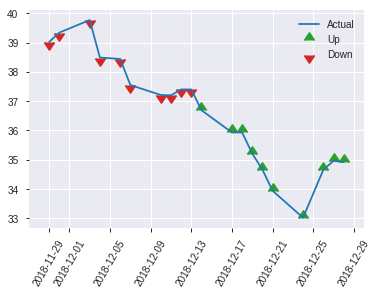


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5214028630865484
RMSE: 0.7220823104650524
LogLoss: 16.124336378259134
Mean Per-Class Error: 0.4259295756142425
AUC: 0.5736762580475627
pr_auc: 0.5719466015168881
Gini: 0.14735251609512545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.095865786723395e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.09587e-49  0.68617   135
max f2                       2.09587e-49  0.845347  135
max f0point5                 1.31216e-45  0.590842  134
max accuracy                 2.41789e-44  0.57085   132
max precision                0.0928577    1         0
max recall                   2.09587e-49  1         135
max specificity              0.0928577    1         0
max absolute_mcc             1.66363e-26  0.156199  83
max min_per_class_accuracy   6.22277e-40  0.55814   123
max mean_per_class_accuracy  1.66363e-26  0.57407   83

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.0129679          0.638243  0.638243           0.333333         0.0486226     0.333333                    0.0486226           0.00775194      0.00775194                 -36.1757   -36.1757
    2        0.0202429                   0.00533966         1.91473   1.14884            1                0.00913643    0.6                         0.0328281           0.0155039       0.0232558                  91.4729    14.8837
    3        0.0323887                   0.000882089        0         0.718023           0                0.00347968    0.375                       0.0218225           0               0.0232558                  -100       -28.1977
    4        0.0404858                   1.36845e-05        1.91473   0.957364           1                0.000447732   0.5                         0.0175475           0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   1.20252e-06        1.27649   1.03101            0.666667         8.17261e-06   0.538462                    0.0135              0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    8.55776e-10        1.43605   1.22543            0.75             1.27189e-07   0.64                        0.00702005          0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    3.93084e-12        1.27649   1.24199            0.666667         2.20643e-10   0.648649                    0.00474328          0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    2.91979e-14        0.883721  1.14884            0.461538         1.22051e-12   0.6                         0.00351002          0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    3.83711e-23        1.19671   1.16436            0.625            1.92899e-15   0.608108                    0.00237164          0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     1.57518e-30        1.07225   1.1411             0.56             2.55027e-24   0.59596                     0.00177274          0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    6.22277e-40        0.995659  1.11178            0.52             1.19708e-31   0.580645                    0.00141533          0.100775        0.55814                    -0.434109  11.1778
    12       0.59919                     1.11543e-56        0.957364  1.08674            0.5              1.52467e-41   0.567568                    0.00118582          0.0930233       0.651163                   -4.26357   8.67379
    13       0.700405                    4.47964e-82        0.765891  1.04037            0.4              3.41892e-59   0.543353                    0.00101446          0.0775194       0.728682                   -23.4109   4.03728
    14       0.797571                    1.46218e-135       0.877584  1.02054            0.458333         1.09939e-84   0.532995                    0.000890869         0.0852713       0.813953                   -12.2416   2.05407
    15       0.898785                    2.98833e-264       0.842481  1.00049            0.44             1.08281e-137  0.522523                    0.000790546         0.0852713       0.899225                   -15.7519   0.0488861
    16       1                           0                  0.995659  1

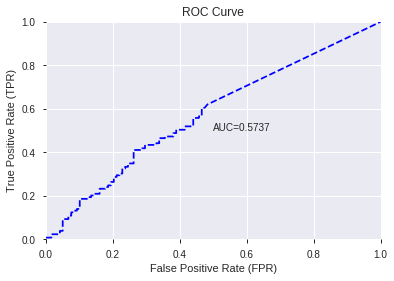

This function is available for GLM models only


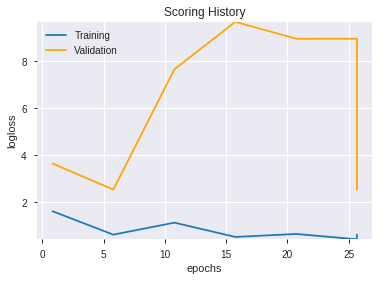

--2019-08-24 19:49:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.81.16
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.81.16|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_193952_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_193952_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['days_in_month',
 'STOCHF_fastk',
 'SIN',
 'NATR_30',
 'HT_TRENDMODE',
 'HT_DCPERIOD',
 'is_month_end',
 'ADX_20',
 'dayofyear',
 'VAR_8',
 'day',
 'ADXR_12',
 'aroondown_30',
 'weekday_name',
 'STOCH_slowd',
 'STOCHRSI_fastk',
 'COSH',
 'VAR_14',
 'aroonup_8',
 'weekday',
 'quarter',
 'is_month_start',
 'SINH',
 'dayofweek',
 'COS',
 'aroondown_14',
 'SAREXT',
 'ADX_24',
 'is_quarter_start',
 'month',
 'week',
 'aroondown_8',
 'ADX_12',
 'aroonup_24',
 'weekofyear',
 'TANH',
 'ADX_14',
 'TAN',
 'ADX_8',
 'VAR_20',
 'AROONOSC_8',
 'aroonup_14',
 'is_quarter_end',
 'aroondown_24',
 'aroonup_12',
 'ADXR_14',
 'aroondown_20',
 'AROONOSC_20',
 'VAR_12',
 'EXP']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_194905_model_1  0.515997  17.665125                   0.5  0.721356  0.520355

variable  relative_importance  scaled_importance  percentage
0               SINH             0.007849           1.000000    0.057294
1                EXP             0.007837           0.998427    0.057204
2               COSH             0.007817           0.995890    0.057059
3       weekday_name             0.007158           0.912016    0.052253
4      days_in_month             0.006497           0.827768    0.047426
5     is_quarter_end             0.005723           0.729099    0.041773
6       aroondown_30             0.005243           0.667964    0.038270
7             SAREXT             0.004803           0.611927    0.035060
8              VAR_8             0.004363           0.555896    0.031850
9                day             0.004302           0.548119    0.031404
10    STOCHRSI_fastk             0.004087           0.520716    0.029834
11               TAN             0.003610           0.459977    0.026354
12              TANH             0.003602           0.458953    0.026295
13      HT_TRENDMODE             0.003454           0.440024    0.025211
14  is_quarter_start             0.003335           0.424850    0.024341
15      is_month_end             0.003314           0.422193    0.024189
16            VAR_20             0.003090           0.393699    0.022557
17         dayofyear             0.002948           0.375603    0.021520
18             month             0.002622           0.334052    0.019139
19            ADX_20             0.002603           0.331640    0.019001
20            ADX_24             0.002586           0.329424    0.018874
21        aroonup_14             0.002566           0.326932    0.018731
22        weekofyear             0.002529           0.322207    0.018461
23              week             0.002520           0.321040    0.018394
24      aroondown_20             0.002320           0.295542    0.016933
25            VAR_14             0.002259           0.287792    0.016489
26       AROONOSC_20             0.001793           0.228399    0.013086
27            VAR_12             0.001766           0.224956    0.012889
28        aroonup_12             0.001740           0.221667    0.012700
29            ADX_14             0.001703           0.216916    0.012428
30         dayofweek             0.001668           0.212452    0.012172
31           weekday             0.001665           0.212194    0.012157
32      aroondown_14             0.001577           0.200892    0.011510
33      STOCHF_fastk             0.001565           0.199361    0.011422
34      aroondown_24             0.001500           0.191152    0.010952
35        aroonup_24             0.001487           0.189463    0.010855
36           ADXR_14             0.001374           0.175034    0.010028
37    is_month_start             0.001217           0.155048    0.008883
38             ADX_8             0.001210           0.154218    0.008836
39               COS             0.001173           0.149485    0.008565
40           quarter             0.001098           0.139830    0.008011
41            ADX_12             0.000965           0.122972    0.007046
42       aroondown_8             0.000823           0.104824    0.006006
43           ADXR_12             0.000819           0.104302    0.005976
44           NATR_30             0.000766           0.097620    0.005593
45         aroonup_8             0.000705           0.089808    0.005145
46       HT_DCPERIOD             0.000680           0.086678    0.004966
47               SIN             0.000347           0.044219    0.002534
48       STOCH_slowd             0.000255           0.032457    0.001860
49        AROONOSC_8             0.000063           0.008070    0.000462

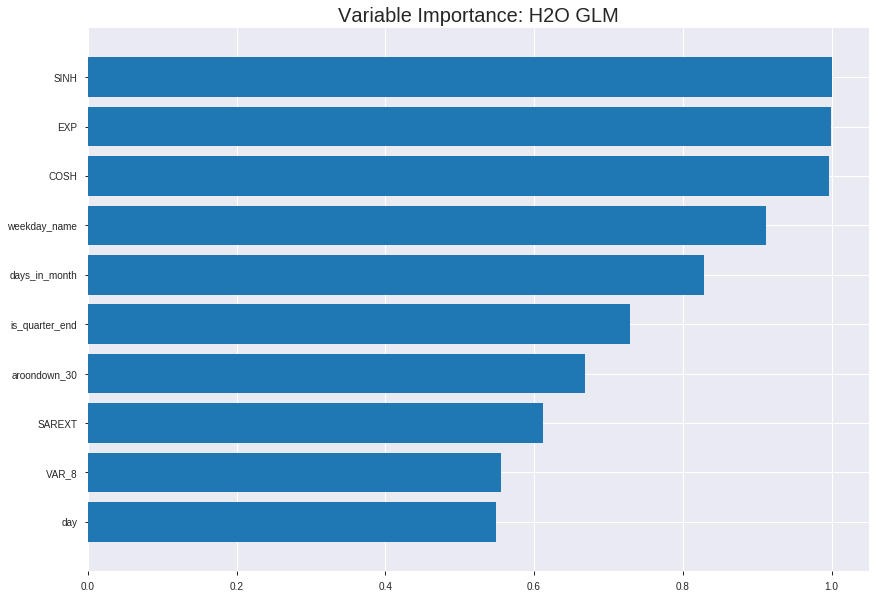

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_194905_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24189217622995973
RMSE: 0.491825351349399
LogLoss: 0.6768142029946462
Null degrees of freedom: 1724
Residual degrees of freedom: 1674
Null deviance: 2340.659668736101
Residual deviance: 2335.0090003315295
AIC: 2437.0090003315295
AUC: 0.5576839991691477
pr_auc: 0.6227316116262475
Gini: 0.11536799833829536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.559961812742382: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    706   0.9874   (706.0/715.0)
1      2    1008  0.002    (2.0/1010.0)
Total  11   1714  0.4104   (708.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.559962     0.740088  390
max f2                       0.557356     0.87628   397
max f0point5                 0.568522     0.64329   352
max accuracy                 0.568522     0.593043  352
max precision                0.623437     1         0
max recall                   0.557356     1         397
max specificity              0.623437     1         0
max absolute_mcc             0.587924     0.107449  167
max min_per_class_accuracy   0.585567     0.537063  198
max mean_per_class_accuracy  0.587924     0.553109  167

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.608961           1.13861   1.13861            0.666667         0.612939  0.666667                    0.612939            0.0118812       0.0118812                  13.8614   13.8614
    2        0.0202899                   0.605937           1.00466   1.07355            0.588235         0.60709   0.628571                    0.610098            0.00990099      0.0217822                  0.465929  7.35502
    3        0.0301449                   0.602842           1.30606   1.14956            0.764706         0.604313  0.673077                    0.608207            0.0128713       0.0346535                  30.6057   14.9562
    4        0.04                        0.600446           1.10513   1.13861            0.647059         0.60179   0.666667                    0.606626            0.0108911       0.0455446                  10.5125   13.8614
    5        0.0504348                   0.599251           0.759076  1.06009            0.444444         0.599618  0.62069                     0.605176            0.00792079      0.0534653                  -24.0924  6.00888
    6        0.10029                     0.595423           1.0327    1.04647            0.604651         0.597149  0.612717                    0.601186            0.0514851       0.10495                    3.26963   4.64717
    7        0.150145                    0.593772           0.973118  1.02211            0.569767         0.594582  0.598456                    0.598993            0.0485149       0.153465                   -2.68823  2.21148
    8        0.2                         0.592318           1.27101   1.08416            0.744186         0.592984  0.634783                    0.597495            0.0633663       0.216832                   27.1011   8.41584
    9        0.30029                     0.589652           1.1452    1.10454            0.67052          0.590972  0.646718                    0.595317            0.114851        0.331683                   14.5195   10.4543
    10       0.4                         0.587585           1.09227   1.10149            0.639535         0.588639  0.644928                    0.593652            0.108911        0.440594                   9.22749   10.1485
    11       0.50029                     0.585677           0.898386  1.06077            0.526012         0.586562  0.621089                    0.592231            0.090099        0.530693                   -10.1614  6.07712
    12       0.6                         0.584079           1.04263   1.05776            0.610465         0.584835  0.619324                    0.591002            0.10396         0.634653                   4.26261   5.77558
    13       0.69971                     0.581891           0.992977  1.04852            0.581395         0.582988  0.613919                    0.58986             0.0990099       0.733663                   -0.70228  4.85247
    14       0.8                         0.579364           0.898386  1.0297             0.526012         0.58065   0.602899                    0.588705            0.090099        0.823762                   -10.1614  2.9703
    15       0.89971                     0.57503            0.893679  1.01463            0.523256         0.57746   0.594072                    0.587459            0.0891089       0.912871                   -10.6321  1.46282
    16       1                           0.55441            0.868769  1                  0.508671         0.567999  0.585507                    0.585507          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.39183267203616307
RMSE: 0.6259653920434923
LogLoss: 4.654018195246974
Null degrees of freedom: 492
Residual degrees of freedom: 442
Null deviance: 668.7154569489843
Residual deviance: 11162.01713879223
AIC: 11264.01713879223
AUC: 0.5024255376891241
pr_auc: 0.5966703443717406
Gini: 0.0048510753782482485
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.6091134670533e-10: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.60911e-10  0.73913    399
max f2                       6.60911e-10  0.876289   399
max f0point5                 6.60911e-10  0.639098   399
max accuracy                 6.60911e-10  0.586207   399
max precision                0.605239     1          0
max recall                   6.60911e-10  1          399
max specificity              0.605239     1          0
max absolute_mcc             0.576846     0.0751057  78
max min_per_class_accuracy   0.40102      0.512111   245
max mean_per_class_accuracy  0.576846     0.52797    78

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 29.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.602166           1.02353   1.02353            0.6              0.603965     0.6                         0.603965            0.0103806       0.0103806                  2.35294   2.35294
    2        0.020284                    0.600443           1.02353   1.02353            0.6              0.601448     0.6                         0.602706            0.0103806       0.0207612                  2.35294   2.35294
    3        0.030426                    0.598759           1.36471   1.13725            0.8              0.599888     0.666667                    0.601767            0.0138408       0.0346021                  36.4706   13.7255
    4        0.040568                    0.596842           0.341176  0.938235           0.2              0.597627     0.55                        0.600732            0.00346021      0.0380623                  -65.8824  -6.17647
    5        0.0507099                   0.594461           1.70588   1.09176            1                0.595647     0.64                        0.599715            0.017301        0.0553633                  70.5882   9.17647
    6        0.10142                     0.582249           1.16      1.12588            0.68             0.587681     0.66                        0.593698            0.0588235       0.114187                   16        12.5882
    7        0.150101                    0.577663           1.13725   1.12957            0.666667         0.579919     0.662162                    0.589229            0.0553633       0.16955                    13.7255   12.9571
    8        0.200811                    0.572389           0.818824  1.0511             0.48             0.575126     0.616162                    0.585668            0.0415225       0.211073                   -18.1176  5.10992
    9        0.300203                    0.553089           0.939976  1.01431            0.55102          0.563487     0.594595                    0.578324            0.0934256       0.304498                   -6.0024   1.43084
    10       0.399594                    0.521013           0.939976  0.99582            0.55102          0.536831     0.583756                    0.568003            0.0934256       0.397924                   -6.0024   -0.418035
    11       0.501014                    0.400481           1.12588   1.02215            0.66             0.463521     0.59919                     0.546853            0.114187        0.512111                   12.5882   2.21481
    12       0.600406                    0.0749779          0.80072   0.985493           0.469388         0.221275     0.577703                    0.492957            0.0795848       0.591696                   -19.928   -1.45072
    13       0.699797                    0.0027586          0.97479   0.983973           0.571429         0.0309117    0.576812                    0.427333            0.0968858       0.688581                   -2.52101  -1.60273
    14       0.799189                    4.55506e-06        1.11405   1.00015            0.653061         0.000484497  0.586294                    0.374248            0.110727        0.799308                   11.4046   0.0149298
    15       0.89858                     3.3369e-21         1.07923   1.0089             0.632653         8.83688e-07  0.591422                    0.332852            0.107266        0.906574                   7.92317   0.889656
    16       1                           1.56609e-198       0.921176  1                  0.54         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 19:49:06  0.000 sec   2            2.5       51            1.35363           22.641
    2019-08-24 19:49:06  0.010 sec   4            1.6       51            1.35231           32.1627
    2019-08-24 19:49:06  0.024 sec   6            0.97      51            1.35069           43.0286
    2019-08-24 19:49:06  0.035 sec   8            0.6       51            1.3488            54.4383
    2019-08-24 19:49:06  0.049 sec   10           0.38      51            1.34673           64.7344

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5222672064777328)

('F1', 0.6861702127659575)

('auc', 0.5159965838917356)

('logloss', 17.665125352453682)

('mean_per_class_error', 0.47891210090658254)

('rmse', 0.7213561351217563)

('mse', 0.5203546736777976)

glm prediction progress: |████████████████████████████████████████████████| 100%


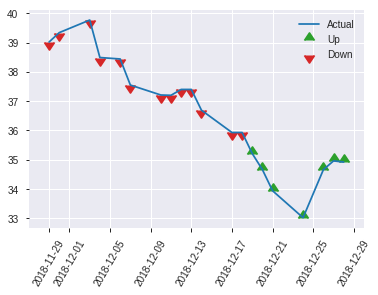


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5203546736777976
RMSE: 0.7213561351217563
LogLoss: 17.665125352453682
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 345.9465433426434
Residual deviance: 123213.9393849041
AIC: 123315.9393849041
AUC: 0.5159965838917356
pr_auc: 0.5702157579209564
Gini: 0.03199316778347128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1703470262429859e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.17035e-49  0.68617    19
max f2                       1.17035e-49  0.845347   19
max f0point5                 1.17035e-49  0.57744    19
max accuracy                 1.17035e-49  0.522267   19
max precision                0.273482     1          0
max recall                   1.17035e-49  1          19
max specificity              0.273482     1          0
max absolute_mcc             7.67074e-44  0.0810485  17
max min_per_class_accuracy   7.67074e-44  0.0930233  17
max mean_per_class_accuracy  7.67074e-44  0.521088   17

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.000647843        1.27649   1.27649            0.666667         0.103052      0.666667                    0.103052            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   4.31827e-05        0.957364  1.14884            0.5              0.000344622   0.6                         0.0619691           0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   1.05786e-12        0         0.718023           0                1.45165e-05   0.375                       0.0387362           0               0.0232558                  -100       -28.1977
    4        0.0404858                   1.71159e-26        1.91473   0.957364           1                5.24685e-13   0.5                         0.0309889           0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   9.4291e-34         1.27649   1.03101            0.666667         5.47603e-27   0.538462                    0.0238376           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    4.53345e-57        1.43605   1.22543            0.75             4.0593e-37    0.64                        0.0123956           0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    2.37157e-74        1.27649   1.24199            0.666667         6.44246e-59   0.648649                    0.00837539          0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    1.78035e-90        0.883721  1.14884            0.461538         2.29247e-76   0.6                         0.00619779          0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    6.19956e-157       1.19671   1.16436            0.625            1.9739e-94    0.608108                    0.00418769          0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     4.21489e-213       1.07225   1.1411             0.56             3.00591e-159  0.59596                     0.00313019          0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    2.58884e-284       0.995659  1.11178            0.52             4.11781e-216  0.580645                    0.00249911          0.100775        0.55814                    -0.434109  11.1778
    12       1                           0                  0.887313  1                  0.463415         3.16343e-289  0.522267                    0.00125461          0.44186         1                          -11.2687   0

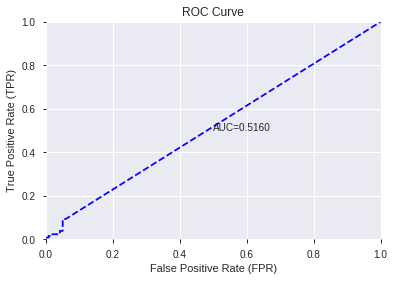

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


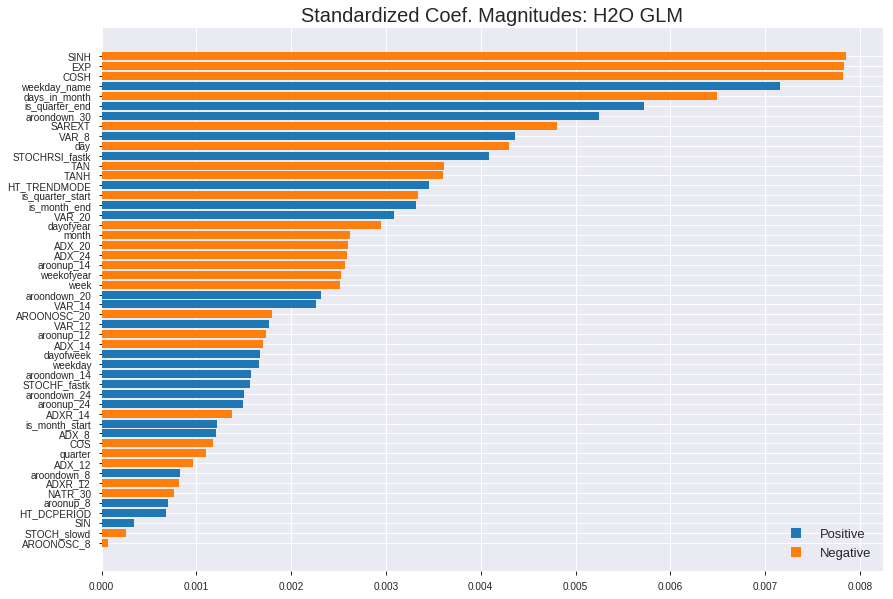

'log_likelihood'
--2019-08-24 19:49:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_194905_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_194905_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SINH',
 'EXP',
 'COSH',
 'weekday_name',
 'days_in_month',
 'is_quarter_end',
 'aroondown_30',
 'SAREXT',
 'VAR_8',
 'day',
 'STOCHRSI_fastk',
 'TAN',
 'TANH',
 'HT_TRENDMODE',
 'is_quarter_start',
 'is_month_end',
 'VAR_20',
 'dayofyear',
 'month',
 'ADX_20',
 'ADX_24',
 'aroonup_14',
 'weekofyear',
 'week',
 'aroondown_20',
 'VAR_14',
 'AROONOSC_20',
 'VAR_12',
 'aroonup_12',
 'ADX_14',
 'dayofweek',
 'weekday',
 'aroondown_14',
 'STOCHF_fastk',
 'aroondown_24',
 'aroonup_24',
 'ADXR_14',
 'is_month_start',
 'ADX_8',
 'COS',
 'quarter',
 'ADX_12',
 'aroondown_8',
 'ADXR_12',
 'NATR_30',
 'aroonup_8',
 'HT_DCPERIOD',
 'SIN',
 'STOCH_slowd',
 'AROONOSC_8']

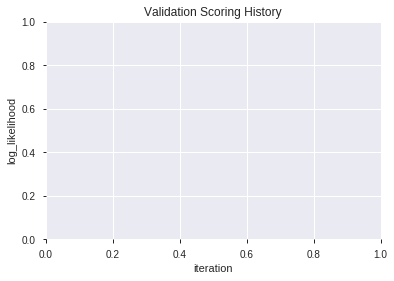

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_194915_model_2  0.472540  0.700962              0.474215  0.503869  0.253884
1  XGBoost_grid_1_AutoML_20190824_194915_model_1  0.466627  0.711250              0.495401  0.508793  0.258870
2  XGBoost_grid_1_AutoML_20190824_194915_model_4  0.457036  0.716201              0.500000  0.510876  0.260995
3  XGBoost_grid_1_AutoML_20190824_194915_model_6  0.455656  0.717778              0.478091  0.512011  0.262155
4               XGBoost_1_AutoML_20190824_194915  0.448364  0.722130              0.500000  0.513854  0.264046
5  XGBoost_grid_1_AutoML_20190824_194915_model_3  0.446065  0.718231              0.478814  0.512294  0.262445
6  XGBoost_grid_1_AutoML_20190824_194915_model_7  0.441006  0.739182              0.482690  0.521611  0.272078
7               XGBoost_3_AutoML_20190824_194915  0.440612  0.721365              0.500000  0.513538  0.263721
8  XGBoost_grid_1_AutoML_20190824_194915_model_5  0.433911  0.779219              0.491525  0.537974  0.289416
9               XGBoost_2_AutoML_20190824_194915  0.431284  0.725835              0.500000  0.515627  0.265871

variable  relative_importance  scaled_importance  percentage
0      STOCH_slowd           283.729706           1.000000    0.063415
1            VAR_8           246.325272           0.868169    0.055055
2            ADX_8           233.568039           0.823206    0.052204
3           ADX_24           201.541641           0.710330    0.045046
4           SAREXT           196.286530           0.691808    0.043871
5              day           189.167053           0.666716    0.042280
6             COSH           183.395844           0.646375    0.040990
7      HT_DCPERIOD           164.397827           0.579417    0.036744
8          NATR_30           155.724426           0.548848    0.034805
9              COS           153.487335           0.540963    0.034305
10          VAR_20           147.915939           0.521327    0.033060
11          ADX_12           145.108948           0.511434    0.032433
12       dayofyear           143.520172           0.505834    0.032078
13         ADXR_12           136.322403           0.480466    0.030469
14             SIN           130.447220           0.459759    0.029156
15          ADX_20           127.018242           0.447673    0.028389
16          VAR_12           125.987289           0.444040    0.028159
17    aroondown_30           116.718964           0.411374    0.026087
18             TAN           115.885689           0.408437    0.025901
19         ADXR_14           102.407387           0.360933    0.022889
20  STOCHRSI_fastk           100.200119           0.353153    0.022395
21          VAR_14            90.109360           0.317589    0.020140
22      aroonup_24            89.609413           0.315827    0.020028
23    STOCHF_fastk            86.983292           0.306571    0.019441
24    aroondown_14            79.156067           0.278984    0.017692
25          ADX_14            70.541245           0.248621    0.015766
26     AROONOSC_20            69.889397           0.246324    0.015621
27    aroondown_24            69.180687           0.243826    0.015462
28    weekday_name            64.356369           0.226823    0.014384
29    aroondown_20            60.087231           0.211776    0.013430
30       dayofweek            58.268993           0.205368    0.013023
31      aroonup_14            56.365406           0.198659    0.012598
32            week            53.789528           0.189580    0.012022
33      AROONOSC_8            42.414421           0.149489    0.009480
34       aroonup_8            41.026268           0.144596    0.009170
35      aroonup_12            38.628395           0.136145    0.008634
36     aroondown_8            33.688965           0.118736    0.007530
37           month            17.168640           0.060511    0.003837
38             EXP            15.124516           0.053306    0.003380
39            TANH            10.653807           0.037549    0.002381
40   days_in_month            10.369112           0.036546    0.002318
41    HT_TRENDMODE             9.272934           0.032682    0.002073
42         weekday             6.060656           0.021361    0.001355
43    is_month_end             2.242236           0.007903    0.000501

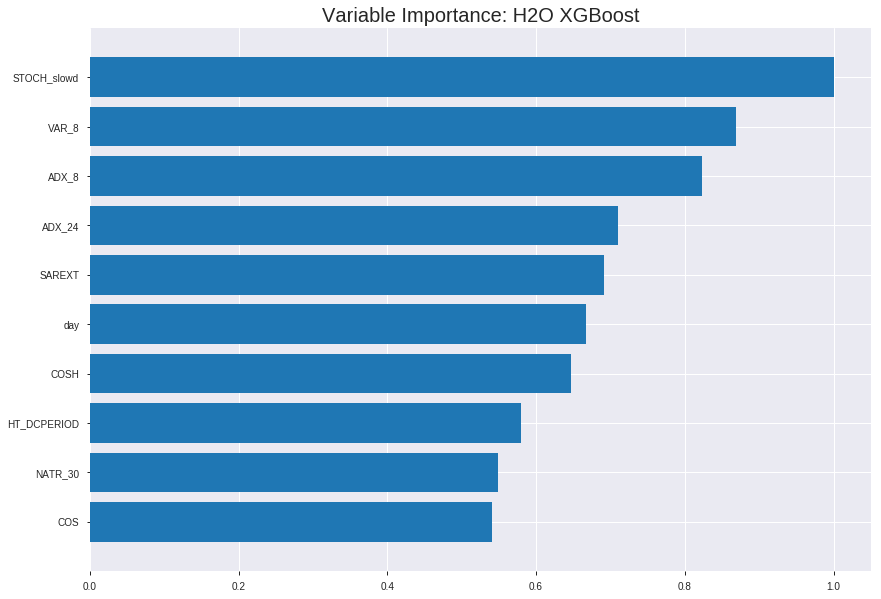

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_194915_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19530673205026886
RMSE: 0.441935212503223
LogLoss: 0.5804235507834006
Mean Per-Class Error: 0.16618084885411621
AUC: 0.9031420065083431
pr_auc: 0.924539963027177
Gini: 0.8062840130166862
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5656680166721344: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      577  138  0.193    (138.0/715.0)
1      149  861  0.1475   (149.0/1010.0)
Total  726  999  0.1664   (287.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.565668     0.857143  206
max f2                       0.513613     0.90646   269
max f0point5                 0.585291     0.875504  179
max accuracy                 0.571872     0.833623  198
max precision                0.763343     1         0
max recall                   0.40579      1         370
max specificity              0.763343     1         0
max absolute_mcc             0.571872     0.661959  198
max min_per_class_accuracy   0.571872     0.832673  198
max mean_per_class_accuracy  0.571872     0.833819  198

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.731021           1.70792   1.70792            1                0.742917  1                           0.742917            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.714947           1.70792   1.70792            1                0.720698  1                           0.732125            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.708831           1.70792   1.70792            1                0.711691  1                           0.725444            0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.700048           1.60745   1.68317            0.941176         0.705584  0.985507                    0.720551            0.0158416       0.0673267                  60.7455   68.3168
    5        0.0504348                   0.694822           1.70792   1.68829            1                0.697395  0.988506                    0.71576             0.0178218       0.0851485                  70.7921   68.829
    6        0.10029                     0.674763           1.68806   1.68818            0.988372         0.683873  0.988439                    0.699909            0.0841584       0.169307                   68.8061   68.8176
    7        0.150145                    0.658293           1.62848   1.66836            0.953488         0.66642   0.976834                    0.688789            0.0811881       0.250495                   62.8483   66.8355
    8        0.2                         0.645834           1.60862   1.65347            0.94186          0.651199  0.968116                    0.679419            0.080198        0.330693                   60.8623   65.3465
    9        0.30029                     0.624818           1.59932   1.63538            0.936416         0.634884  0.957529                    0.664545            0.160396        0.491089                   59.9325   63.5384
    10       0.4                         0.604506           1.46961   1.59406            0.860465         0.614538  0.933333                    0.65208             0.146535        0.637624                   46.9606   59.4059
    11       0.50029                     0.585121           1.35252   1.54564            0.791908         0.595843  0.904983                    0.640806            0.135644        0.773267                   35.2515   54.5639
    12       0.6                         0.561225           0.923469  1.44224            0.540698         0.572746  0.844444                    0.629496            0.0920792       0.865347                   -7.65312  44.2244
    13       0.69971                     0.534507           0.695084  1.33577            0.406977         0.54925   0.782104                    0.618061            0.0693069       0.934653                   -30.4916  33.5772
    14       0.8                         0.499894           0.345533  1.21163            0.202312         0.517501  0.70942                     0.605454            0.0346535       0.969307                   -65.4467  21.1634
    15       0.89971                     0.46153            0.228385  1.10267            0.133721         0.482332  0.645619                    0.591809            0.0227723       0.992079                   -77.1615  10.2665
    16       1                           0.334218           0.078979  1                  0.0462428        0.421439  0.585507                    0.574723          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2510880270905628
RMSE: 0.5010868458566468
LogLoss: 0.6953207699602576
Mean Per-Class Error: 0.46539792387543255
AUC: 0.5176487550037316
pr_auc: 0.6186490389629916
Gini: 0.035297510007463284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35196930170059204: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    289  0        (0.0/289.0)
Total  2    491  0.4097   (202.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.351969     0.741026   397
max f2                       0.351969     0.877353   397
max f0point5                 0.351969     0.641367   397
max accuracy                 0.351969     0.590264   397
max precision                0.673538     1          0
max recall                   0.351969     1          397
max specificity              0.673538     1          0
max absolute_mcc             0.572906     0.0950831  56
max min_per_class_accuracy   0.497485     0.5        202
max mean_per_class_accuracy  0.563938     0.534602   70

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.650089           1.36471   1.36471            0.8              0.667959  0.8                         0.667959            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.638921           1.70588   1.53529            1                0.645956  0.9                         0.656957            0.017301        0.0311419                  70.5882   53.5294
    3        0.030426                    0.630038           0.682353  1.25098            0.4              0.634601  0.733333                    0.649505            0.00692042      0.0380623                  -31.7647  25.098
    4        0.040568                    0.614347           1.02353   1.19412            0.6              0.62429   0.7                         0.643201            0.0103806       0.0484429                  2.35294   19.4118
    5        0.0507099                   0.604731           1.36471   1.22824            0.8              0.608466  0.72                        0.636254            0.0138408       0.0622837                  36.4706   22.8235
    6        0.10142                     0.580536           1.09176   1.16               0.64             0.588079  0.68                        0.612167            0.0553633       0.117647                   9.17647   16
    7        0.150101                    0.564855           1.13725   1.15262            0.666667         0.571835  0.675676                    0.599086            0.0553633       0.17301                    13.7255   15.2623
    8        0.200811                    0.548612           0.750588  1.0511             0.44             0.557079  0.616162                    0.588478            0.0380623       0.211073                   -24.9412  5.10992
    9        0.300203                    0.530529           1.04442   1.04889            0.612245         0.538743  0.614865                    0.572012            0.103806        0.314879                   4.44178   4.88871
    10       0.399594                    0.510624           1.07923   1.05643            0.632653         0.521686  0.619289                    0.559494            0.107266        0.422145                   7.92317   5.64348
    11       0.501014                    0.49747            0.784706  1.00143            0.46             0.503795  0.587045                    0.548219            0.0795848       0.50173                    -21.5294  0.142891
    12       0.600406                    0.48598            1.07923   1.01431            0.632653         0.491536  0.594595                    0.538836            0.107266        0.608997                   7.92317   1.43084
    13       0.699797                    0.469337           1.04442   1.01858            0.612245         0.477113  0.597101                    0.53007             0.103806        0.712803                   4.44178   1.85848
    14       0.799189                    0.45342            0.870348  1.00015            0.510204         0.461131  0.586294                    0.521496            0.0865052       0.799308                   -12.9652  0.0149298
    15       0.89858                     0.430001           0.870348  0.985792           0.510204         0.443396  0.577878                    0.512857            0.0865052       0.885813                   -12.9652  -1.42079
    16       1                           0.347507           1.12588   1                  0.66             0.403524  0.586207                    0.501769           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:49:19  0.577 sec   0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 19:49:19  0.652 sec   5                  0.491596         0.676461            0.735576        0.749942           1.58141          0.315362                         0.500408           0.693963              0.503138          0.58605              1.21849            0.413793
    2019-08-24 19:49:19  0.718 sec   10                 0.484339         0.662203            0.778653        0.804073           1.70792          0.273043                         0.499479           0.692095              0.519328          0.605189             1.36471            0.413793
    2019-08-24 19:49:19  0.781 sec   15                 0.477391         0.648645            0.813003        0.843916           1.70792          0.253333                         0.49801            0.689151              0.531133          0.606997             1.70588            0.411765
    2019-08-24 19:49:19  0.867 sec   20                 0.470946         0.636138            0.842457        0.871769           1.70792          0.231304                         0.49816            0.689448              0.528513          0.614675             1.36471            0.411765
    2019-08-24 19:49:19  0.939 sec   25                 0.46527          0.625139            0.856893        0.886791           1.70792          0.215652                         0.49865            0.690419              0.519124          0.611325             1.36471            0.409736
    2019-08-24 19:49:19  1.008 sec   30                 0.460001         0.614969            0.86931         0.89703            1.70792          0.212754                         0.49952            0.692157              0.519362          0.614901             1.02353            0.411765
    2019-08-24 19:49:19  1.076 sec   35                 0.454844         0.605052            0.878284        0.904608           1.70792          0.211014                         0.499945           0.693039              0.525307          0.616312             1.02353            0.411765
    2019-08-24 19:49:19  1.141 sec   40                 0.450843         0.597328            0.887089        0.914014           1.70792          0.198841                         0.499559           0.692237              0.525324          0.622348             1.36471            0.411765
    2019-08-24 19:49:19  1.218 sec   45                 0.446325         0.588723            0.894664        0.91831            1.70792          0.185507                         0.499844           0.692807              0.52479           0.62211              1.36471            0.411765
    2019-08-24 19:49:20  1.292 sec   50                 0.441935         0.580424            0.903142        0.92454            1.70792          0.166377                         0.501087           0.695321              0.517649          0.618649             1.36471            0.409736

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ---------------------
STOCH_slowd    283.7297058105469      1.0                   0.06341543108313588
VAR_8          246.3252716064453      0.8681687766980684    0.05505529722722675
ADX_8          233.5680389404297      0.8232061506326329    0.05220397291265732
ADX_24         201.54164123535156     0.7103297155988515    0.045045865125862485
SAREXT         196.28652954101562     0.691808173487766     0.043871313548563544
---            ---                    ---                   ---
TANH           10.653806686401367     0.03754914084856229   0.0023811949537129646
days_in_month  10.369112014770508     0.03654573984471761   0.0023175638465049025
HT_TRENDMODE   9.272933959960938      0.032682280952818867  0.0020725609354031696
weekday        6.0606560707092285     0.02136066808160043   0.0013545959746184724
is_month_end   2.2422361373901367     0.007902719001468713  0.0005011543322070276


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6956521739130433)

('auc', 0.47253974510576796)

('logloss', 0.7009615620842419)

('mean_per_class_error', 0.4681710681907765)

('rmse', 0.5038689024746555)

('mse', 0.2538838708810139)

xgboost prediction progress: |████████████████████████████████████████████| 100%


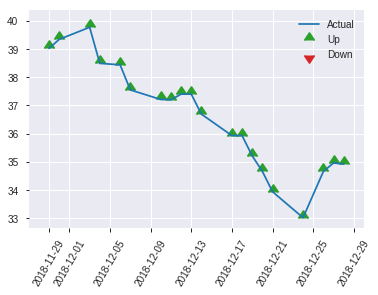


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2538838708810139
RMSE: 0.5038689024746555
LogLoss: 0.7009615620842419
Mean Per-Class Error: 0.4681710681907765
AUC: 0.47253974510576796
pr_auc: 0.49596469802291804
Gini: -0.05492050978846408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4092746675014496: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    111  0.9407   (111.0/118.0)
1      1    128  0.0078   (1.0/129.0)
Total  8    239  0.4534   (112.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409275     0.695652  238
max f2                       0.397319     0.850923  241
max f0point5                 0.426816     0.590778  227
max accuracy                 0.426816     0.550607  227
max precision                0.606575     0.666667  2
max recall                   0.397319     1         241
max specificity              0.614798     0.991525  0
max absolute_mcc             0.397319     0.15029   241
max min_per_class_accuracy   0.508223     0.5       123
max mean_per_class_accuracy  0.426816     0.531829  227

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 51.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.605663           1.27649   1.27649            0.666667         0.611736  0.666667                    0.611736            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.601317           0         0.765891           0                0.604414  0.4                         0.608807            0               0.0155039                  -100       -23.4109
    3        0.0323887                   0.599902           0.638243  0.718023           0.333333         0.60063   0.375                       0.605741            0.00775194      0.0232558                  -36.1757   -28.1977
    4        0.0404858                   0.597763           0         0.574419           0                0.599521  0.3                         0.604497            0               0.0232558                  -100       -42.5581
    5        0.0526316                   0.597011           1.91473   0.883721           1                0.597397  0.461538                    0.602858            0.0232558       0.0465116                  91.4729    -11.6279
    6        0.101215                    0.580786           0.957364  0.91907            0.5              0.588567  0.48                        0.595999            0.0465116       0.0930233                  -4.26357   -8.09302
    7        0.149798                    0.569211           0.797804  0.87974            0.416667         0.575482  0.459459                    0.589345            0.0387597       0.131783                   -20.2196   -12.026
    8        0.202429                    0.560943           1.03101   0.91907            0.538462         0.564875  0.48                        0.582982            0.0542636       0.186047                   3.10078    -8.09302
    9        0.299595                    0.543931           1.03714   0.957364           0.541667         0.553087  0.5                         0.573287            0.100775        0.286822                   3.71447    -4.26357
    10       0.40081                     0.526841           0.91907   0.947694           0.48             0.534283  0.494949                    0.563437            0.0930233       0.379845                   -8.09302   -5.2306
    11       0.502024                    0.508223           1.22543   1.00369            0.64             0.517393  0.524194                    0.554154            0.124031        0.503876                   22.5426    0.368842
    12       0.59919                     0.494364           0.638243  0.944427           0.333333         0.501706  0.493243                    0.545649            0.0620155       0.565891                   -36.1757   -5.5573
    13       0.700405                    0.48168            0.995659  0.95183            0.52             0.487458  0.49711                     0.53724             0.100775        0.666667                   -0.434109  -4.81696
    14       0.797571                    0.467382           1.19671   0.981663           0.625            0.475963  0.51269                     0.529775            0.116279        0.782946                   19.6705    -1.83371
    15       0.898785                    0.43657            1.30202   1.01774            0.68             0.453603  0.531532                    0.521197            0.131783        0.914729                   30.2016    1.77387
    16       1                           0.376338           0.842481  1                  0.44             0.41243   0.522267          

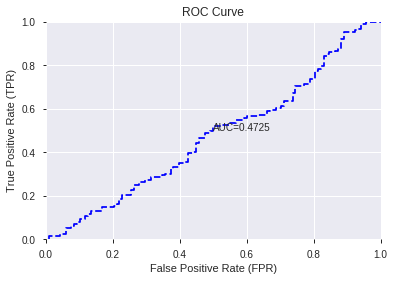

This function is available for GLM models only


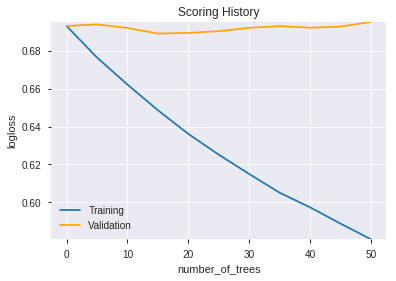

--2019-08-24 19:49:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_194915_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_194915_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCH_slowd',
 'VAR_8',
 'ADX_8',
 'ADX_24',
 'SAREXT',
 'day',
 'COSH',
 'HT_DCPERIOD',
 'NATR_30',
 'COS',
 'VAR_20',
 'ADX_12',
 'dayofyear',
 'ADXR_12',
 'SIN',
 'ADX_20',
 'VAR_12',
 'aroondown_30',
 'TAN',
 'ADXR_14',
 'STOCHRSI_fastk',
 'VAR_14',
 'aroonup_24',
 'STOCHF_fastk',
 'aroondown_14',
 'ADX_14',
 'AROONOSC_20',
 'aroondown_24',
 'weekday_name',
 'aroondown_20',
 'dayofweek',
 'aroonup_14',
 'week',
 'AROONOSC_8',
 'aroonup_8',
 'aroonup_12',
 'aroondown_8',
 'month',
 'EXP',
 'TANH',
 'days_in_month',
 'HT_TRENDMODE',
 'weekday',
 'is_month_end']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_194933_model_1  0.522697  17.625458                   0.5  0.720883  0.519672

variable  relative_importance  scaled_importance    percentage
0               weekday_name         7.101164e-03           1.000000  1.844983e-02
1              days_in_month         6.464107e-03           0.910288  1.679466e-02
2                        EXP         6.304008e-03           0.887743  1.637871e-02
3                       SINH         6.287812e-03           0.885462  1.633662e-02
4                       COSH         6.285311e-03           0.885110  1.633013e-02
..                       ...                  ...                ...           ...
964  BBANDS_lowerband_12_2_3         5.297627e-07           0.000075  1.376398e-06
965  BBANDS_lowerband_24_2_2         5.179554e-07           0.000073  1.345721e-06
966  BBANDS_upperband_14_6_3         4.831476e-07           0.000068  1.255286e-06
967  BBANDS_lowerband_14_5_5         4.805648e-07           0.000068  1.248575e-06
968                  KAMA_20         4.802417e-08           0.000007  1.247736e-07

[969 rows x 4 columns]

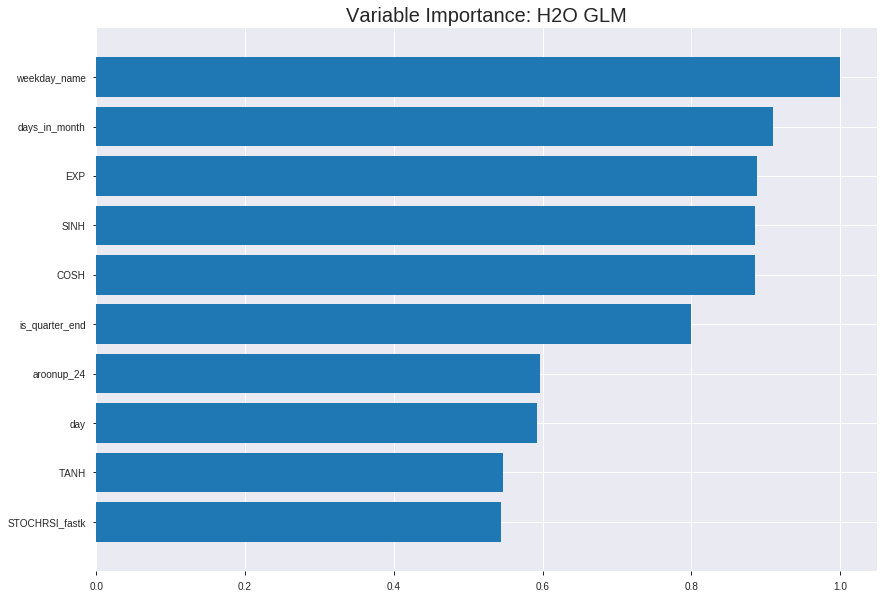

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_194933_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24123105205494147
RMSE: 0.49115277873075447
LogLoss: 0.675455996955622
Null degrees of freedom: 1724
Residual degrees of freedom: 755
Null deviance: 2340.659668736101
Residual deviance: 2330.323189496896
AIC: 4270.323189496896
AUC: 0.5612642802741813
pr_auc: 0.624312732009251
Gini: 0.12252856054836259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5197625721753903: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    714   0.9986   (714.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  1    1724  0.4139   (714.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519763     0.738844  398
max f2                       0.519763     0.876128  398
max f0point5                 0.574826     0.648366  267
max accuracy                 0.573491     0.593623  274
max precision                0.666036     1         0
max recall                   0.519763     1         398
max specificity              0.666036     1         0
max absolute_mcc             0.577038     0.132252  254
max min_per_class_accuracy   0.584023     0.541259  212
max mean_per_class_accuracy  0.577038     0.563193  254

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.638391           1.2335    1.2335             0.722222         0.649588  0.722222                    0.649588            0.0128713       0.0128713                  23.3498   23.3498
    2        0.0202899                   0.632871           1.00466   1.12235            0.588235         0.635657  0.657143                    0.642821            0.00990099      0.0227723                  0.465929  12.2348
    3        0.0301449                   0.629505           1.00466   1.08387            0.588235         0.631127  0.634615                    0.638998            0.00990099      0.0326733                  0.465929  8.38728
    4        0.04                        0.625228           1.00466   1.06436            0.588235         0.627369  0.623188                    0.636133            0.00990099      0.0425743                  0.465929  6.43564
    5        0.0504348                   0.6226             1.13861   1.07972            0.666667         0.62352   0.632184                    0.633523            0.0118812       0.0544554                  13.8614   7.972
    6        0.10029                     0.611317           1.01284   1.04647            0.593023         0.61619   0.612717                    0.624907            0.050495        0.10495                    1.28367   4.64717
    7        0.150145                    0.604445           1.01284   1.0353             0.593023         0.607509  0.606178                    0.61913             0.050495        0.155446                   1.28367   3.53033
    8        0.2                         0.599639           1.23129   1.08416            0.72093          0.601821  0.634783                    0.614815            0.0613861       0.216832                   23.1292   8.41584
    9        0.30029                     0.592564           1.10571   1.09135            0.647399         0.595916  0.638996                    0.608504            0.110891        0.327723                   10.5706   9.13548
    10       0.4                         0.588286           1.0327    1.07673            0.604651         0.59036   0.630435                    0.603981            0.10297         0.430693                   3.26963   7.67327
    11       0.50029                     0.584279           1.04647   1.07067            0.612717         0.58623   0.626883                    0.600422            0.10495         0.535644                   4.64717   7.06665
    12       0.6                         0.580413           1.05256   1.06766            0.616279         0.582373  0.625121                    0.597423            0.10495         0.640594                   5.25558   6.76568
    13       0.69971                     0.575472           1.08235   1.06975            0.633721         0.577991  0.626346                    0.594654            0.107921        0.748515                   8.23452   6.97499
    14       0.8                         0.570334           0.78979   1.03465            0.462428         0.572926  0.605797                    0.59193             0.0792079       0.827723                   -21.021   3.46535
    15       0.89971                     0.562741           0.834101  1.01243            0.488372         0.567027  0.592784                    0.58917             0.0831683       0.910891                   -16.5899  1.24273
    16       1                           0.519203           0.888514  1                  0.520231         0.552647  0.585507                    0.585507           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38694541114657044
RMSE: 0.6220493639146096
LogLoss: 4.298040456299502
Null degrees of freedom: 492
Residual degrees of freedom: -477
Null deviance: 668.7154569489843
Residual deviance: 9046.176182834904
AIC: 10986.176182834904
AUC: 0.49955051224642105
pr_auc: 0.5905703706507858
Gini: -0.0008989755071578953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.4825610096971248e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.48256e-08  0.73913    399
max f2                       2.48256e-08  0.876289   399
max f0point5                 2.48256e-08  0.639098   399
max accuracy                 2.48256e-08  0.586207   399
max precision                0.604565     0.6875     15
max recall                   2.48256e-08  1          399
max specificity              0.638069     0.995098   0
max absolute_mcc             0.562064     0.0613216  80
max min_per_class_accuracy   0.413551     0.512111   244
max mean_per_class_accuracy  0.562064     0.523068   80

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 30.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.621455           1.02353   1.02353            0.6              0.634771     0.6                         0.634771            0.0103806       0.0103806                  2.35294   2.35294
    2        0.020284                    0.610678           1.02353   1.02353            0.6              0.61488      0.6                         0.624826            0.0103806       0.0207612                  2.35294   2.35294
    3        0.030426                    0.604783           1.36471   1.13725            0.8              0.607173     0.666667                    0.618942            0.0138408       0.0346021                  36.4706   13.7255
    4        0.040568                    0.596343           0.341176  0.938235           0.2              0.602038     0.55                        0.614716            0.00346021      0.0380623                  -65.8824  -6.17647
    5        0.0507099                   0.586513           1.36471   1.02353            0.8              0.588966     0.6                         0.609566            0.0138408       0.0519031                  36.4706   2.35294
    6        0.10142                     0.572462           1.09176   1.05765            0.64             0.577175     0.62                        0.59337             0.0553633       0.107266                   9.17647   5.76471
    7        0.150101                    0.565126           1.06618   1.06041            0.625            0.569144     0.621622                    0.585513            0.0519031       0.15917                    6.61765   6.04134
    8        0.200811                    0.558633           0.955294  1.03387            0.56             0.561231     0.606061                    0.579381            0.0484429       0.207612                   -4.47059  3.38681
    9        0.300203                    0.544271           1.0096    1.02583            0.591837         0.551621     0.601351                    0.57019             0.100346        0.307958                   0.960384  2.58347
    10       0.399594                    0.515849           0.870348  0.98716            0.510204         0.530568     0.57868                     0.560335            0.0865052       0.394464                   -12.9652  -1.28397
    11       0.501014                    0.412285           1.16      1.02215            0.68             0.466753     0.59919                     0.541391            0.117647        0.512111                   16        2.21481
    12       0.600406                    0.115122           0.80072   0.985493           0.469388         0.262316     0.577703                    0.495193            0.0795848       0.591696                   -19.928   -1.45072
    13       0.699797                    0.00882048         0.97479   0.983973           0.571429         0.0556026    0.576812                    0.432758            0.0968858       0.688581                   -2.52101  -1.60273
    14       0.799189                    5.33485e-05        1.11405   1.00015            0.653061         0.00196888   0.586294                    0.379183            0.110727        0.799308                   11.4046   0.0149298
    15       0.89858                     3.19466e-17        1.07923   1.0089             0.632653         1.13335e-05  0.591422                    0.337243            0.107266        0.906574                   7.92317   0.889656
    16       1                           1.25366e-159       0.921176  1                  0.54          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 19:49:36  0.000 sec   2            2.5       970           1.35091           18.3492
    2019-08-24 19:49:38  1.561 sec   4            1.8       970           1.34972           23.6982
    2019-08-24 19:49:39  3.126 sec   6            1.3       970           1.34832           30.339
    2019-08-24 19:49:41  4.714 sec   8            0.97      970           1.34667           38.0809
    2019-08-24 19:49:42  6.263 sec   10           0.71      970           1.34478           46.3161

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5222672064777328)

('F1', 0.6861702127659575)

('auc', 0.5226974116410459)

('logloss', 17.625457612009324)

('mean_per_class_error', 0.47612008934437)

('rmse', 0.7208825561800967)

('mse', 0.5196716598047503)

glm prediction progress: |████████████████████████████████████████████████| 100%


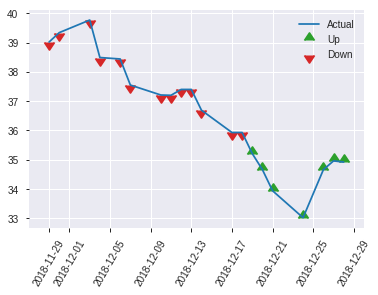


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5196716598047503
RMSE: 0.7208825561800967
LogLoss: 17.625457612009324
Null degrees of freedom: 246
Residual degrees of freedom: -723
Null deviance: 345.9465433426434
Residual deviance: 112766.91560674446
AIC: 114706.91560674446
AUC: 0.5226974116410459
pr_auc: 0.5750744491856398
Gini: 0.04539482328209177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.2232635510111756e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.22326e-49  0.68617    25
max f2                       6.22326e-49  0.845347   25
max f0point5                 6.22326e-49  0.57744    25
max accuracy                 6.22326e-49  0.522267   25
max precision                0.400026     1          0
max recall                   6.22326e-49  1          25
max specificity              0.400026     1          0
max absolute_mcc             2.30108e-35  0.0810485  17
max min_per_class_accuracy   1.00457e-45  0.124031   24
max mean_per_class_accuracy  1.00457e-45  0.52388    24

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.00358334         1.27649   1.27649            0.666667         0.163384      0.666667                    0.163384            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.000420591        0.957364  1.14884            0.5              0.00199123    0.6                         0.0988272           0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   2.75324e-10        0         0.718023           0                0.00014639    0.375                       0.0618219           0               0.0232558                  -100       -28.1977
    4        0.0404858                   2.10266e-21        1.91473   0.957364           1                1.32756e-10   0.5                         0.0494575           0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   2.69237e-27        1.27649   1.03101            0.666667         7.22866e-22   0.538462                    0.0380442           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    4.79895e-46        1.43605   1.22543            0.75             4.35222e-30   0.64                        0.019783            0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    4.83103e-60        1.27649   1.24199            0.666667         1.1513e-47    0.648649                    0.0133669           0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    7.37942e-73        0.883721  1.14884            0.461538         1.33462e-61   0.6                         0.0098915           0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    2.66964e-126       1.19671   1.16436            0.625            3.20602e-76   0.608108                    0.00668345          0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     2.20115e-171       1.07225   1.1411             0.56             2.34534e-128  0.59596                     0.00499571          0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    1.51376e-228       0.995659  1.11178            0.52             5.76671e-174  0.580645                    0.00398851          0.100775        0.55814                    -0.434109  11.1778
    12       1                           0                  0.887313  1                  0.463415         7.44615e-233  0.522267                    0.00200233          0.44186         1                          -11.2687   0

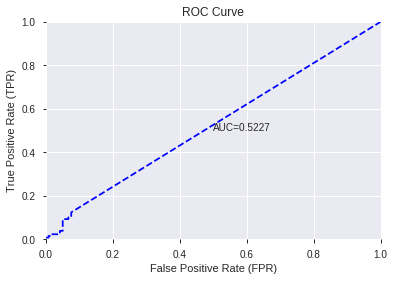

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


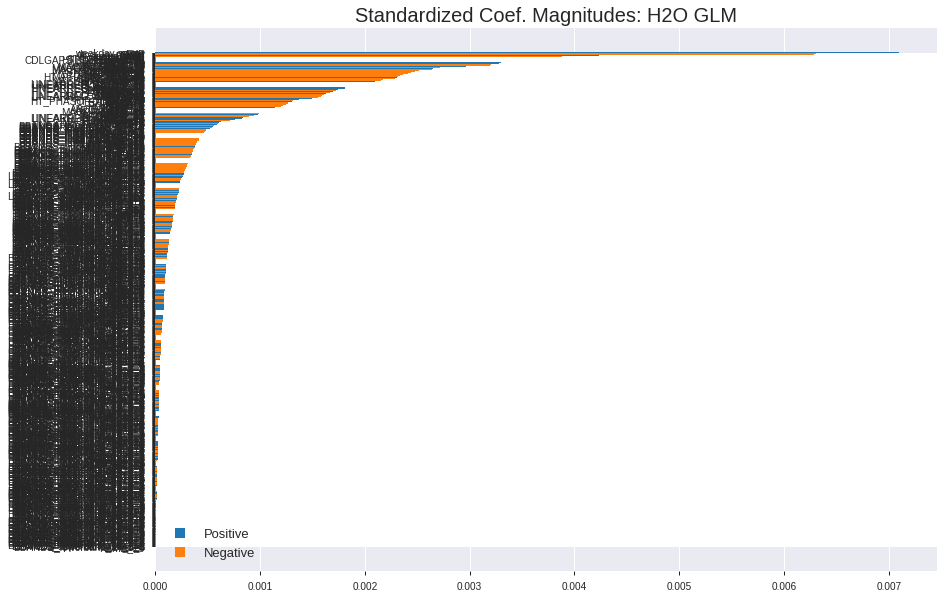

'log_likelihood'
--2019-08-24 19:49:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_194933_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_194933_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

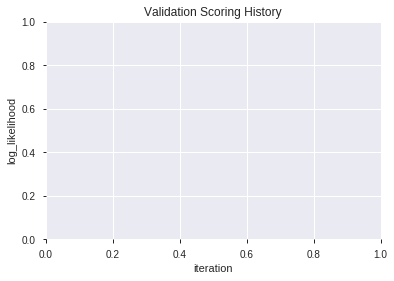

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_195004_model_6  0.516818  0.729165              0.500000  0.515686  0.265932
1  XGBoost_grid_1_AutoML_20190824_195004_model_1  0.505814  0.751809              0.491525  0.525490  0.276140
2  XGBoost_grid_1_AutoML_20190824_195004_model_4  0.490146  0.701989              0.500000  0.504320  0.254339
3  XGBoost_grid_1_AutoML_20190824_195004_model_7  0.489292  0.731457              0.500000  0.517457  0.267761
4  XGBoost_grid_1_AutoML_20190824_195004_model_2  0.488175  0.706816              0.500000  0.506594  0.256637
5               XGBoost_3_AutoML_20190824_195004  0.485416  0.723981              0.491525  0.514504  0.264715
6               XGBoost_1_AutoML_20190824_195004  0.484036  0.726175              0.495763  0.515497  0.265737
7  XGBoost_grid_1_AutoML_20190824_195004_model_5  0.480160  0.751487              0.500000  0.525387  0.276031
8  XGBoost_grid_1_AutoML_20190824_195004_model_3  0.469255  0.771300              0.486565  0.534593  0.285790
9               XGBoost_2_AutoML_20190824_195004  0.458547  0.735462              0.500000  0.519784  0.270175

variable  relative_importance  scaled_importance  percentage
0    HT_PHASOR_quadrature           192.185867           1.000000    0.029371
1                  MOM_30           110.277672           0.573807    0.016853
2                   MOM_8            94.500702           0.491715    0.014442
3                STDDEV_8            88.878609           0.462462    0.013583
4                  MOM_14            84.570770           0.440047    0.012924
..                    ...                  ...                ...         ...
265                ATR_14             3.168373           0.016486    0.000484
266                  mama             3.001508           0.015618    0.000459
267    LINEARREG_ANGLE_12             2.797572           0.014557    0.000428
268               DEMA_12             2.062745           0.010733    0.000315
269     LINEARREG_SLOPE_8             1.300416           0.006766    0.000199

[270 rows x 4 columns]

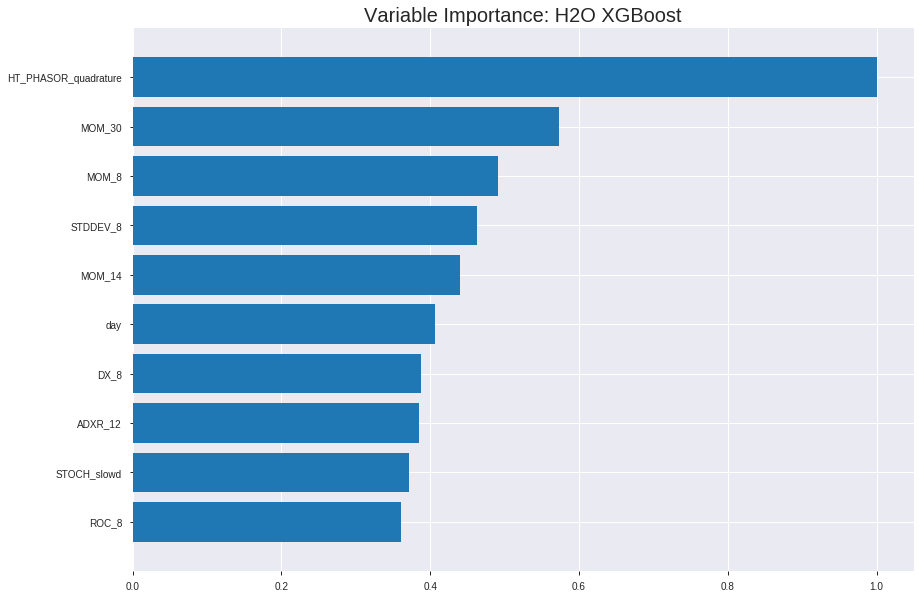

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_195004_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17910790911632923
RMSE: 0.4232114236600062
LogLoss: 0.545745057567497
Mean Per-Class Error: 0.13114311431143122
AUC: 0.9426573426573427
pr_auc: 0.9560374909536655
Gini: 0.8853146853146854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5563758730888366: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      570  145   0.2028   (145.0/715.0)
1      75   935   0.0743   (75.0/1010.0)
Total  645  1080  0.1275   (220.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.556376     0.894737  213
max f2                       0.513091     0.931869  253
max f0point5                 0.590301     0.905116  177
max accuracy                 0.568679     0.873043  200
max precision                0.805167     1         0
max recall                   0.397806     1         347
max specificity              0.805167     1         0
max absolute_mcc             0.568679     0.737998  200
max min_per_class_accuracy   0.577674     0.865734  192
max mean_per_class_accuracy  0.573731     0.868857  196

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.94 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.757745           1.70792     1.70792            1                0.773523  1                           0.773523            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.748774           1.70792     1.70792            1                0.753925  1                           0.764004            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.739691           1.70792     1.70792            1                0.743711  1                           0.75737             0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.729715           1.70792     1.70792            1                0.734496  1                           0.751734            0.0168317       0.0683168                  70.7921   70.7921
    5        0.0504348                   0.721995           1.70792     1.70792            1                0.726654  1                           0.746545            0.0178218       0.0861386                  70.7921   70.7921
    6        0.10029                     0.701415           1.68806     1.69805            0.988372         0.71143   0.99422                     0.729089            0.0841584       0.170297                   68.8061   69.8048
    7        0.150145                    0.683269           1.68806     1.69473            0.988372         0.692451  0.992278                    0.716924            0.0841584       0.254455                   68.8061   69.4732
    8        0.2                         0.669208           1.68806     1.69307            0.988372         0.675603  0.991304                    0.706623            0.0841584       0.338614                   68.8061   69.3069
    9        0.30029                     0.644226           1.61907     1.66836            0.947977         0.657149  0.976834                    0.6901              0.162376        0.50099                    61.9069   66.8355
    10       0.4                         0.618619           1.57883     1.64604            0.924419         0.631175  0.963768                    0.675411            0.157426        0.658416                   57.8834   64.604
    11       0.50029                     0.593815           1.41175     1.59907            0.82659          0.60604   0.936269                    0.661505            0.141584        0.8                        41.175    59.9073
    12       0.6                         0.56534            1.00291     1.5                0.587209         0.580609  0.878261                    0.648062            0.1             0.9                        0.290698  50
    13       0.69971                     0.529983           0.635505    1.37681            0.372093         0.547742  0.806131                    0.633766            0.0633663       0.963366                   -36.4495  37.6808
    14       0.8                         0.49403            0.266554    1.23762            0.156069         0.512157  0.724638                    0.618521            0.0267327       0.990099                   -73.3446  23.7624
    15       0.89971                     0.43931            0.0893679   1.11037            0.0523256        0.469716  0.650129                    0.602029            0.00891089      0.99901                    -91.0632  11.0369
    16       1                           0.216904           0.00987237  1                  0.00578035       0.376702  0.585507       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2783190439020079
RMSE: 0.5275595169286664
LogLoss: 0.7527231915663345
Mean Per-Class Error: 0.47563437139561704
AUC: 0.5038503290589592
pr_auc: 0.5879052608571604
Gini: 0.007700658117918424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25682568550109863: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   191  0.9363   (191.0/204.0)
1      5    284  0.0173   (5.0/289.0)
Total  18   475  0.3976   (196.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.256826     0.743455  382
max f2                       0.226815     0.877886  396
max f0point5                 0.256826     0.648698  382
max accuracy                 0.256826     0.602434  382
max precision                0.700396     1         0
max recall                   0.226815     1         396
max specificity              0.700396     1         0
max absolute_mcc             0.256826     0.121907  382
max min_per_class_accuracy   0.411729     0.484429  205
max mean_per_class_accuracy  0.268834     0.524366  373

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 42.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.672897           1.36471   1.36471            0.8              0.686737  0.8                         0.686737            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.642549           0.682353  1.02353            0.4              0.666587  0.6                         0.676662            0.00692042      0.0207612                  -31.7647  2.35294
    3        0.030426                    0.623471           0.341176  0.796078           0.2              0.631545  0.466667                    0.661623            0.00346021      0.0242215                  -65.8824  -20.3922
    4        0.040568                    0.616784           0.682353  0.767647           0.4              0.620512  0.45                        0.651345            0.00692042      0.0311419                  -31.7647  -23.2353
    5        0.0507099                   0.603832           1.02353   0.818824           0.6              0.609767  0.48                        0.64303             0.0103806       0.0415225                  2.35294   -18.1176
    6        0.10142                     0.560487           1.22824   1.02353            0.72             0.580948  0.6                         0.611989            0.0622837       0.103806                   22.8235   2.35294
    7        0.150101                    0.53262            1.06618   1.03736            0.625            0.542856  0.608108                    0.589567            0.0519031       0.155709                   6.61765   3.73609
    8        0.200811                    0.51242            0.955294  1.01664            0.56             0.523278  0.59596                     0.572828            0.0484429       0.204152                   -4.47059  1.6637
    9        0.300203                    0.470052           1.0096    1.01431            0.591837         0.490638  0.594595                    0.545616            0.100346        0.304498                   0.960384  1.43084
    10       0.399594                    0.438414           0.905162  0.98716            0.530612         0.452535  0.57868                     0.522464            0.0899654       0.394464                   -9.48379  -1.28397
    11       0.501014                    0.410634           0.921176  0.973803           0.54             0.422732  0.57085                     0.502276            0.0934256       0.487889                   -7.88235  -2.61967
    12       0.600406                    0.386094           0.939976  0.968203           0.55102          0.397791  0.567568                    0.484979            0.0934256       0.581315                   -6.0024   -3.17965
    13       0.699797                    0.360275           1.21849   1.00375            0.714286         0.370613  0.588406                    0.468736            0.121107        0.702422                   21.8487   0.375107
    14       0.799189                    0.338844           1.04442   1.00881            0.612245         0.349427  0.591371                    0.453898            0.103806        0.806228                   4.44178   0.88086
    15       0.89858                     0.297864           1.04442   1.01275            0.612245         0.318655  0.593679                    0.438939            0.103806        0.910035                   4.44178   1.27473
    16       1                           0.182769           0.887059  1                  0.52             0.264488  0.586207                    0.421246   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:50:35  18.854 sec  0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 19:50:36  19.332 sec  5                  0.487257         0.667907            0.730405        0.776545           1.62252          0.31942                          0.503956           0.701113              0.495488          0.572749             0.284314           0.413793
    2019-08-24 19:50:36  19.483 sec  10                 0.477194         0.648275            0.800745        0.835352           1.70792          0.257391                         0.509131           0.711716              0.478263          0.574732             1.42157            0.413793
    2019-08-24 19:50:36  19.632 sec  15                 0.468011         0.630502            0.842677        0.874746           1.70792          0.224928                         0.508457           0.710408              0.501018          0.577479             1.36471            0.409736
    2019-08-24 19:50:36  19.783 sec  20                 0.459478         0.614088            0.872731        0.901546           1.70792          0.201159                         0.508985           0.711471              0.504927          0.57591              1.36471            0.397566
    2019-08-24 19:50:36  19.928 sec  25                 0.452637         0.601023            0.891958        0.91673            1.70792          0.177971                         0.510478           0.714596              0.500221          0.572518             1.02353            0.391481
    2019-08-24 19:50:36  20.069 sec  30                 0.446358         0.589038            0.906729        0.929133           1.70792          0.164058                         0.519091           0.733003              0.498355          0.576992             1.02353            0.401623
    2019-08-24 19:50:37  20.221 sec  35                 0.440428         0.577841            0.916588        0.933753           1.70792          0.16                             0.52262            0.740965              0.501136          0.577623             1.02353            0.399594
    2019-08-24 19:50:37  20.374 sec  40                 0.434798         0.567197            0.926967        0.943906           1.70792          0.14029                          0.523933           0.744145              0.501018          0.583705             1.36471            0.399594
    2019-08-24 19:50:37  20.532 sec  45                 0.429078         0.55656             0.935328        0.950191           1.70792          0.132754                         0.530604           0.759766              0.50586           0.587908             1.02353            0.399594
    2019-08-24 19:50:37  20.683 sec  50                 0.423211         0.545745            0.942657        0.956037           1.70792          0.127536                         0.52756            0.752723              0.50385           0.587905             1.36471            0.397566

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_quadrature  192.1858673095703      1.0                   0.029370657198689854
MOM_30                110.27767181396484     0.5738073946734653    0.016853100287027682
MOM_8                 94.50070190429688      0.4917151465257144    0.014441997008010311
STDDEV_8              88.87860870361328      0.46246173013569647   0.01358280494332856
MOM_14                84.57077026367188      0.44004677059550096   0.012924462850550973
---                   ---                    ---                   ---
ATR_14                3.168372631072998      0.016485981385766662  0.00048420410786533457
mama                  3.0015082359313965     0.015617736506590305  0.00045870318515452786
LINEARREG_ANGLE_12    2.797572135925293      0.014556596565027348  0.0004275368076910445
DEMA_12               2.0627453327178955     0.010733075025726289  0.0003152374672684261
LINEARREG_SLOPE_8     1.300416111946106      0.006766450260629279  0.00019873509105692815


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6861702127659575)

('auc', 0.5168177637629747)

('logloss', 0.7291650697793686)

('mean_per_class_error', 0.4457692813033767)

('rmse', 0.5156862909010935)

('mse', 0.2659323506233272)

xgboost prediction progress: |████████████████████████████████████████████| 100%


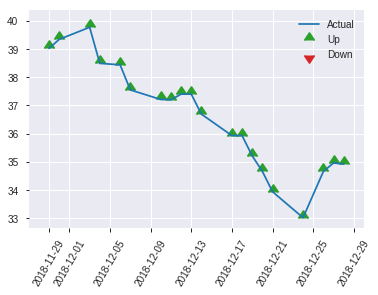


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2659323506233272
RMSE: 0.5156862909010935
LogLoss: 0.7291650697793686
Mean Per-Class Error: 0.4457692813033767
AUC: 0.5168177637629747
pr_auc: 0.5499803573231689
Gini: 0.03363552752594945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18170076608657837: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.181701     0.68617   246
max f2                       0.181701     0.845347  246
max f0point5                 0.181701     0.57744   246
max accuracy                 0.454331     0.550607  103
max precision                0.607127     1         0
max recall                   0.181701     1         246
max specificity              0.607127     1         0
max absolute_mcc             0.254698     0.129283  232
max min_per_class_accuracy   0.439075     0.51938   119
max mean_per_class_accuracy  0.454331     0.554231  103

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 42.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.585108           1.91473   1.91473            1                0.600401  1                           0.600401            0.0232558       0.0232558                  91.4729    91.4729
    2        0.0202429                   0.580622           0.957364  1.53178            0.5              0.582312  0.8                         0.593165            0.00775194      0.0310078                  -4.26357   53.1783
    3        0.0323887                   0.576544           0         0.957364           0                0.578166  0.5                         0.58754             0               0.0310078                  -100       -4.26357
    4        0.0404858                   0.560396           0         0.765891           0                0.575285  0.4                         0.585089            0               0.0310078                  -100       -23.4109
    5        0.0526316                   0.555874           1.27649   0.883721           0.666667         0.557227  0.461538                    0.57866             0.0155039       0.0465116                  27.6486    -11.6279
    6        0.101215                    0.529928           1.59561   1.22543            0.833333         0.539915  0.64                        0.560062            0.0775194       0.124031                   59.5607    22.5426
    7        0.149798                    0.510775           0.797804  1.08674            0.416667         0.516928  0.567568                    0.546073            0.0387597       0.162791                   -20.2196   8.67379
    8        0.202429                    0.501514           1.17829   1.11054            0.615385         0.506611  0.58                        0.535812            0.0620155       0.224806                   17.8295    11.0543
    9        0.299595                    0.475845           1.11693   1.11261            0.583333         0.488793  0.581081                    0.520563            0.108527        0.333333                   11.6925    11.2613
    10       0.40081                     0.45764            1.07225   1.10242            0.56             0.4669    0.575758                    0.507012            0.108527        0.44186                    7.22481    10.242
    11       0.502024                    0.434548           0.765891  1.03457            0.4              0.447096  0.540323                    0.494932            0.0775194       0.51938                    -23.4109   3.45711
    12       0.59919                     0.420697           0.718023  0.983239           0.375            0.427434  0.513514                    0.483986            0.0697674       0.589147                   -28.1977   -1.67609
    13       0.700405                    0.404073           1.14884   1.00717            0.6              0.4142    0.526012                    0.473902            0.116279        0.705426                   14.8837    0.716942
    14       0.797571                    0.356228           0.797804  0.981663           0.416667         0.383459  0.51269                     0.462883            0.0775194       0.782946                   -20.2196   -1.83371
    15       0.898785                    0.287621           0.995659  0.983239           0.52             0.326071  0.513514                    0.447476            0.100775        0.883721                   -0.434109  -1.67609
    16       1                           0.181701           1.14884   1                  0.6              0.25303   0.522267              

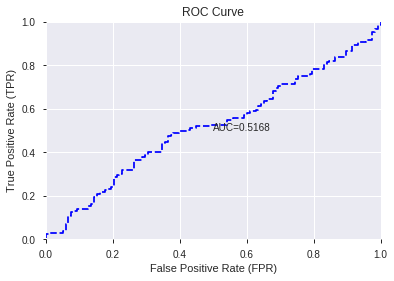

This function is available for GLM models only


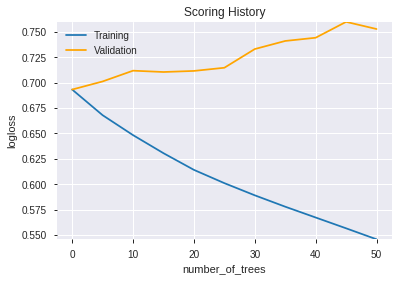

--2019-08-24 19:50:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_195004_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_195004_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_195049_model_5  0.567994  16.973272              0.500000  0.720524  0.519154
1  DeepLearning_grid_1_AutoML_20190824_195049_model_8  0.560373  16.587289              0.500000  0.719000  0.516960
2  DeepLearning_grid_1_AutoML_20190824_195049_model_2  0.515865  17.712107              0.500000  0.722683  0.522271
3  DeepLearning_grid_1_AutoML_20190824_195049_model_7  0.515832  17.644911              0.500000  0.719926  0.518293
4  DeepLearning_grid_1_AutoML_20190824_195049_model_3  0.500000  16.500306              0.500000  0.691182  0.477733
5  DeepLearning_grid_1_AutoML_20190824_195049_model_1  0.499672  17.955271              0.500000  0.722681  0.522267
6               DeepLearning_1_AutoML_20190824_195049  0.494843  15.469266              0.500000  0.691923  0.478757
7  DeepLearning_grid_1_AutoML_20190824_195049_model_6  0.480949  14.851874              0.500000  0.686460  0.471228
8  DeepLearning_grid_1_AutoML_20190824_195049_model_4  0.468532  14.121835              0.483051  0.686158  0.470812
9  DeepLearning_grid_1_AutoML_20190824_195049_model_9  0.436375   5.997028              0.491525  0.671066  0.450329

variable  relative_importance  scaled_importance  percentage
0       STOCHF_fastk             1.000000           1.000000    0.021522
1      days_in_month             0.978682           0.978682    0.021063
2                day             0.977930           0.977930    0.021047
3                COS             0.976709           0.976709    0.021021
4         aroonup_14             0.972750           0.972750    0.020935
5               TANH             0.971559           0.971559    0.020910
6       aroondown_20             0.967800           0.967800    0.020829
7          dayofyear             0.965543           0.965543    0.020780
8                TAN             0.964097           0.964097    0.020749
9            weekday             0.963321           0.963321    0.020732
10         aroonup_8             0.957886           0.957886    0.020615
11    STOCHRSI_fastk             0.955284           0.955284    0.020559
12               SIN             0.955126           0.955126    0.020556
13             month             0.954346           0.954346    0.020539
14      weekday_name             0.953243           0.953243    0.020516
15            VAR_14             0.952505           0.952505    0.020500
16            ADX_20             0.950365           0.950365    0.020454
17      aroondown_30             0.947722           0.947722    0.020397
18      HT_TRENDMODE             0.943618           0.943618    0.020308
19       STOCH_slowd             0.943532           0.943532    0.020307
20              COSH             0.938554           0.938554    0.020199
21           NATR_30             0.936010           0.936010    0.020145
22              SINH             0.930723           0.930723    0.020031
23            ADX_12             0.927159           0.927159    0.019954
24      aroondown_14             0.925373           0.925373    0.019916
25        aroonup_12             0.923426           0.923426    0.019874
26       aroondown_8             0.919131           0.919131    0.019781
27      aroondown_24             0.918019           0.918019    0.019757
28            ADX_24             0.917904           0.917904    0.019755
29         dayofweek             0.915526           0.915526    0.019704
30           ADXR_14             0.915107           0.915107    0.019695
31       HT_DCPERIOD             0.914966           0.914966    0.019692
32        weekofyear             0.914290           0.914290    0.019677
33        aroonup_24             0.912445           0.912445    0.019637
34            VAR_12             0.910509           0.910509    0.019596
35              week             0.908120           0.908120    0.019544
36             VAR_8             0.906005           0.906005    0.019499
37            SAREXT             0.905799           0.905799    0.019494
38      is_month_end             0.905306           0.905306    0.019484
39       AROONOSC_20             0.902231           0.902231    0.019418
40           ADXR_12             0.902109           0.902109    0.019415
41            ADX_14             0.899707           0.899707    0.019363
42            VAR_20             0.899481           0.899481    0.019358
43        AROONOSC_8             0.896563           0.896563    0.019296
44  is_quarter_start             0.894971           0.894971    0.019261
45    is_month_start             0.894177           0.894177    0.019244
46               EXP             0.885607           0.885607    0.019060
47             ADX_8             0.884413           0.884413    0.019034
48           quarter             0.879844           0.879844    0.018936
49    is_quarter_end             0.828969           0.828969    0.017841

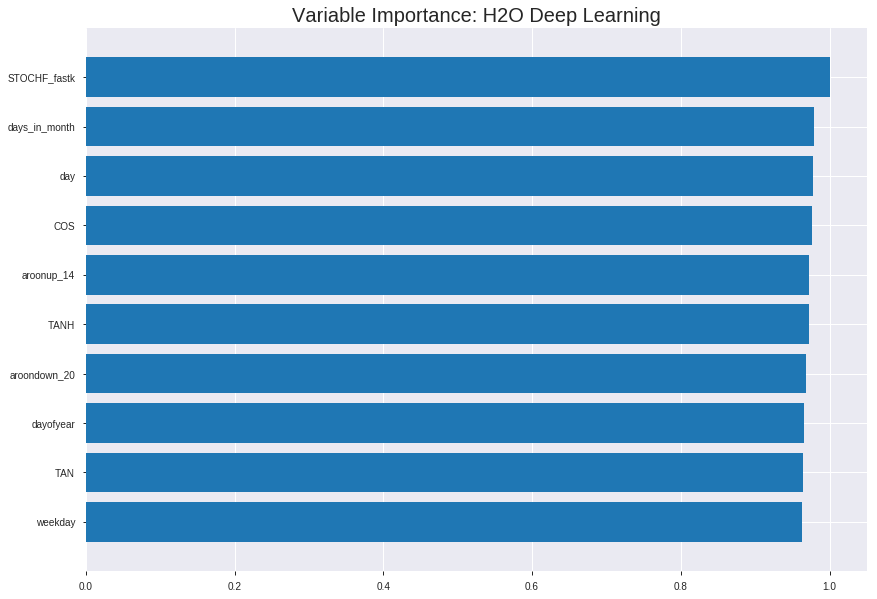

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_195049_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24146622294048858
RMSE: 0.4913921274710133
LogLoss: 0.6758761592082614
Mean Per-Class Error: 0.4353735373537354
AUC: 0.567087170255487
pr_auc: 0.6397657486537173
Gini: 0.1341743405109741
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3527583513448027: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    712   0.9958   (712.0/715.0)
1      1    1009  0.001    (1.0/1010.0)
Total  4    1721  0.4133   (713.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352758     0.738923  395
max f2                       0.331098     0.876128  398
max f0point5                 0.490575     0.645669  281
max accuracy                 0.484922     0.591884  288
max precision                0.769498     1         0
max recall                   0.331098     1         398
max specificity              0.769498     1         0
max absolute_mcc             0.545756     0.12795   203
max min_per_class_accuracy   0.55444      0.559441  189
max mean_per_class_accuracy  0.545756     0.564626  203

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 54.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.691257           1.32838   1.32838            0.777778         0.719064  0.777778                    0.719064            0.0138614       0.0138614                  32.8383   32.8383
    2        0.0202899                   0.668622           1.30606   1.31754            0.764706         0.677366  0.771429                    0.698811            0.0128713       0.0267327                  30.6057   31.7539
    3        0.0301449                   0.660348           1.00466   1.21525            0.588235         0.665366  0.711538                    0.687877            0.00990099      0.0366337                  0.465929  21.5251
    4        0.04                        0.655017           1.00466   1.16337            0.588235         0.657823  0.681159                    0.680472            0.00990099      0.0465347                  0.465929  16.3366
    5        0.0504348                   0.649697           1.2335    1.17788            0.722222         0.652198  0.689655                    0.674622            0.0128713       0.0594059                  23.3498   17.7876
    6        0.10029                     0.632137           1.13199   1.15507            0.662791         0.640168  0.676301                    0.657495            0.0564356       0.115842                   13.1994   15.5068
    7        0.150145                    0.621475           1.25115   1.18697            0.732558         0.626355  0.694981                    0.647155            0.0623762       0.178218                   25.1151   18.6972
    8        0.2                         0.609507           0.973118  1.13366            0.569767         0.615921  0.663768                    0.639369            0.0485149       0.226733                   -2.68823  13.3663
    9        0.30029                     0.591359           0.928003  1.06498            0.543353         0.600469  0.623552                    0.626377            0.0930693       0.319802                   -7.19968  6.49776
    10       0.4                         0.572278           1.15185   1.08663            0.674419         0.582048  0.636232                    0.615327            0.114851        0.434653                   15.1854   8.66337
    11       0.50029                     0.555395           1.15507   1.10035            0.676301         0.563447  0.644264                    0.604927            0.115842        0.550495                   15.5068   10.0352
    12       0.6                         0.532236           0.992977  1.08251            0.581395         0.54465   0.633816                    0.59491             0.0990099       0.649505                   -0.70228  8.25083
    13       0.69971                     0.510382           0.834101  1.04711            0.488372         0.521332  0.61309                     0.584425            0.0831683       0.732673                   -16.5899  4.71097
    14       0.8                         0.482065           0.977365  1.03837            0.572254         0.496869  0.607971                    0.573449            0.0980198       0.830693                   -2.26349  3.83663
    15       0.89971                     0.443108           0.774522  1.00913            0.453488         0.461479  0.590851                    0.56104             0.0772277       0.907921                   -22.5478  0.912588
    16       1                           0.315188           0.918131  1                  0.537572         0.414469  0.585507                    0.54634         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3594068361673663
RMSE: 0.5995054930251817
LogLoss: 2.507176975263704
Mean Per-Class Error: 0.45891003460207613
AUC: 0.5087777325463056
pr_auc: 0.6178576918010011
Gini: 0.0175554650926113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.870669455569905e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.87067e-06  0.73913   399
max f2                       2.87067e-06  0.876289  399
max f0point5                 2.87067e-06  0.639098  399
max accuracy                 2.87067e-06  0.586207  399
max precision                0.69954      1         0
max recall                   2.87067e-06  1         399
max specificity              0.69954      1         0
max absolute_mcc             0.584107     0.123797  55
max min_per_class_accuracy   0.380902     0.5       226
max mean_per_class_accuracy  0.584107     0.54109   55

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 31.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.65193            1.70588   1.70588            1                0.670418     1                           0.670418            0.017301        0.017301                   70.5882    70.5882
    2        0.020284                    0.639846           0.682353  1.19412            0.4              0.645354     0.7                         0.657886            0.00692042      0.0242215                  -31.7647   19.4118
    3        0.030426                    0.629552           1.36471   1.25098            0.8              0.635798     0.733333                    0.650523            0.0138408       0.0380623                  36.4706    25.098
    4        0.040568                    0.619894           1.36471   1.27941            0.8              0.625771     0.75                        0.644335            0.0138408       0.0519031                  36.4706    27.9412
    5        0.0507099                   0.612874           1.36471   1.29647            0.8              0.616619     0.76                        0.638792            0.0138408       0.0657439                  36.4706    29.6471
    6        0.10142                     0.591109           1.16      1.22824            0.68             0.604327     0.72                        0.62156             0.0588235       0.124567                   16         22.8235
    7        0.150101                    0.563962           0.995098  1.15262            0.583333         0.581199     0.675676                    0.60847             0.0484429       0.17301                    -0.490196  15.2623
    8        0.200811                    0.526064           1.02353   1.12002            0.6              0.544564     0.656566                    0.592332            0.0519031       0.224913                   2.35294    12.0024
    9        0.300203                    0.477929           0.835534  1.02583            0.489796         0.499158     0.601351                    0.561484            0.083045        0.307958                   -16.4466   2.58347
    10       0.399594                    0.405886           0.870348  0.98716            0.510204         0.441279     0.57868                     0.531585            0.0865052       0.394464                   -12.9652   -1.28397
    11       0.501014                    0.380902           1.05765   1.00143            0.62             0.394234     0.587045                    0.503781            0.107266        0.50173                    5.76471    0.142891
    12       0.600406                    0.288035           0.939976  0.991256           0.55102          0.337419     0.581081                    0.476242            0.0934256       0.595156                   -6.0024    -0.874404
    13       0.699797                    0.149771           0.939976  0.983973           0.55102          0.230525     0.576812                    0.441343            0.0934256       0.688581                   -6.0024    -1.60273
    14       0.799189                    0.0343873          1.11405   1.00015            0.653061         0.0872189    0.586294                    0.397302            0.110727        0.799308                   11.4046    0.0149298
    15       0.89858                     6.17471e-06        1.07923   1.0089             0.632653         0.0119861    0.591422                    0.354682            0.107266        0.906574                   7.92317    0.889656
    16       1                           4.39937e-49        0.921176  1               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 19:54:49  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 19:54:50  1 min 48.753 sec  1428 obs/sec      1.5258    1             2632       0.491392         0.675876            0.00503645     0.567087        0.639766           1.32838          0.413333                         0.599505           2.50718               -0.481672        0.508778          0.617858             1.70588            0.413793
    2019-08-24 19:54:58  1 min 56.393 sec  2412 obs/sec      12.1188   8             20905      0.482402         0.65638             0.0411077      0.628212        0.710125           1.61304          0.405797                         0.665289           8.13692               -0.824677        0.50804           0.619189             1.70588            0.413793
    2019-08-24 19:55:06  2 min  4.748 sec  2718 obs/sec      25.7438   17            44408      0.475985         0.639072            0.0664514      0.707945        0.781564           1.70792          0.353043                         0.668287           8.96114               -0.84116         0.509651          0.62085              1.70588            0.413793
    2019-08-24 19:55:14  2 min 12.084 sec  2837 obs/sec      37.7872   25            65183      0.448453         0.581107            0.171324       0.767433        0.819292           1.70792          0.316522                         0.677648           9.67188               -0.893105        0.50748           0.617391             1.70588            0.413793
    2019-08-24 19:55:21  2 min 19.225 sec  2921 obs/sec      49.8371   33            85969      0.421166         0.520652            0.2691         0.807217        0.861003           1.70792          0.293333                         0.679862           9.52899               -0.90549         0.50888           0.617497             1.70588            0.413793
    2019-08-24 19:55:28  2 min 26.196 sec  2990 obs/sec      61.9206   41            106813     0.408755         0.496637            0.311543       0.843244        0.883718           1.70792          0.253333                         0.683176           9.56241               -0.924116        0.507056          0.614443             1.70588            0.413793
    2019-08-24 19:55:29  2 min 26.907 sec  2989 obs/sec      61.9206   41            106813     0.491392         0.675876            0.00503645     0.567087        0.639766           1.32838          0.413333                         0.599505           2.50718               -0.481672        0.508778          0.617858             1.70588            0.413793

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
STOCHF_fastk    1.0                    1.0                  0.021521823779661726
days_in_month   0.9786823391914368     0.9786823391914368   0.021063028840345225
day             0.9779300093650818     0.9779300093650818   0.021046837330398232
COS             0.9767085909843445     0.9767085909843445   0.021020550179246762
aroonup_14      0.9727495312690735     0.9727495312690735   0.02093534399372154
---             ---                    ---                  ---
is_month_start  0.8941769003868103     0.8941769003868103   0.019244317677969067
EXP             0.8856070637702942     0.8856070637702942   0.019059879164487915
ADX_8           0.8844128847122192     0.8844128847122192   0.019034178253238665
quarter         0.8798441290855408     0.8798441290855408   0.018935850299748952
is_quarter_end  0.8289694786071777     0.8289694786071777   0.01784093503730174


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5668016194331984)

('F1', 0.6861702127659575)

('auc', 0.5679936933385888)

('logloss', 16.973272334816063)

('mean_per_class_error', 0.4259295756142425)

('rmse', 0.7205235870037988)

('mse', 0.5191542394288208)

deeplearning prediction progress: |███████████████████████████████████████| 100%


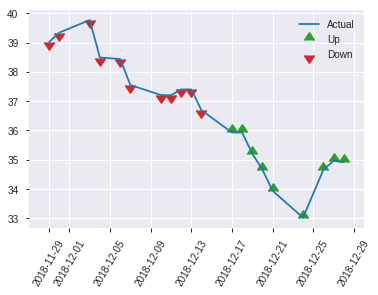


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5191542394288208
RMSE: 0.7205235870037988
LogLoss: 16.973272334816063
Mean Per-Class Error: 0.4259295756142425
AUC: 0.5679936933385888
pr_auc: 0.579864303144662
Gini: 0.1359873866771777
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.722833307543839e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.72283e-49  0.68617   84
max f2                       3.72283e-49  0.845347  84
max f0point5                 3.72283e-49  0.57744   84
max accuracy                 2.31357e-45  0.566802  83
max precision                0.331488     1         0
max recall                   3.72283e-49  1         84
max specificity              0.331488     1         0
max absolute_mcc             2.31357e-45  0.156199  83
max min_per_class_accuracy   2.31357e-45  0.410853  83
max mean_per_class_accuracy  2.31357e-45  0.57407   83

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.0972962          0.638243  0.638243           0.333333         0.220947      0.333333                    0.220947            0.00775194      0.00775194                 -36.1757   -36.1757
    2        0.0202429                   0.0486398          1.91473   1.14884            1                0.0728831     0.6                         0.161721            0.0155039       0.0232558                  91.4729    14.8837
    3        0.0323887                   0.000985943        0.638243  0.957364           0.333333         0.0262827     0.5                         0.110932            0.00775194      0.0310078                  -36.1757   -4.26357
    4        0.0404858                   4.15826e-07        0.957364  0.957364           0.5              0.000492287   0.5                         0.0888439           0.00775194      0.0387597                  -4.26357   -4.26357
    5        0.0526316                   6.17165e-09        1.27649   1.03101            0.666667         2.16633e-07   0.538462                    0.0683415           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    1.20983e-14        1.43605   1.22543            0.75             2.89995e-10   0.64                        0.0355376           0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    5.37733e-19        1.27649   1.24199            0.666667         1.60427e-15   0.648649                    0.0240119           0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    9.89601e-23        0.883721  1.14884            0.461538         1.16573e-19   0.6                         0.0177688           0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    4.54217e-39        1.19671   1.16436            0.625            2.16674e-24   0.608108                    0.0120059           0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     9.85072e-53        1.07225   1.1411             0.56             1.83458e-40   0.59596                     0.00897414          0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    5.45397e-70        0.995659  1.11178            0.52             4.06427e-54   0.580645                    0.00716484          0.100775        0.55814                    -0.434109  11.1778
    12       0.59919                     2.4394e-100        0.957364  1.08674            0.5              5.06452e-72   0.567568                    0.00600297          0.0930233       0.651163                   -4.26357   8.67379
    13       0.700405                    2.34419e-147       0.765891  1.04037            0.4              2.32316e-104  0.543353                    0.00513549          0.0775194       0.728682                   -23.4109   4.03728
    14       0.797571                    2.15579e-245       0.877584  1.02054            0.458333         2.72453e-151  0.532995                    0.00450985          0.0852713       0.813953                   -12.2416   2.05407
    15       1                           0                  0.91907   1                  0.48             7.4963e-249   0.522267                    0.00359692          0.186047        1                          -8.09302   0

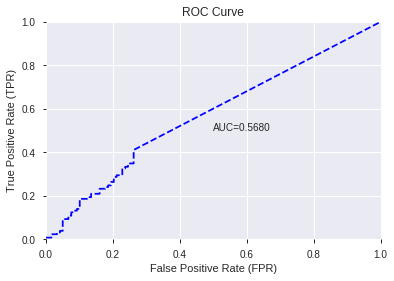

This function is available for GLM models only


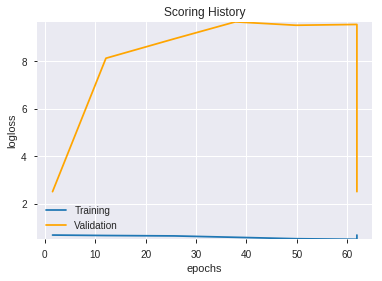

--2019-08-24 20:00:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_195049_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_195049_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHF_fastk',
 'days_in_month',
 'day',
 'COS',
 'aroonup_14',
 'TANH',
 'aroondown_20',
 'dayofyear',
 'TAN',
 'weekday',
 'aroonup_8',
 'STOCHRSI_fastk',
 'SIN',
 'month',
 'weekday_name',
 'VAR_14',
 'ADX_20',
 'aroondown_30',
 'HT_TRENDMODE',
 'STOCH_slowd',
 'COSH',
 'NATR_30',
 'SINH',
 'ADX_12',
 'aroondown_14',
 'aroonup_12',
 'aroondown_8',
 'aroondown_24',
 'ADX_24',
 'dayofweek',
 'ADXR_14',
 'HT_DCPERIOD',
 'weekofyear',
 'aroonup_24',
 'VAR_12',
 'week',
 'VAR_8',
 'SAREXT',
 'is_month_end',
 'AROONOSC_20',
 'ADXR_12',
 'ADX_14',
 'VAR_20',
 'AROONOSC_8',
 'is_quarter_start',
 'is_month_start',
 'EXP',
 'ADX_8',
 'quarter',
 'is_quarter_end']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_200020_model_1  0.515997  17.665125                   0.5  0.721356  0.520355

variable  relative_importance  scaled_importance  percentage
0               SINH             0.007849           1.000000    0.057294
1                EXP             0.007837           0.998427    0.057204
2               COSH             0.007817           0.995890    0.057059
3       weekday_name             0.007158           0.912016    0.052253
4      days_in_month             0.006497           0.827768    0.047426
5     is_quarter_end             0.005723           0.729099    0.041773
6       aroondown_30             0.005243           0.667964    0.038270
7             SAREXT             0.004803           0.611927    0.035060
8              VAR_8             0.004363           0.555896    0.031850
9                day             0.004302           0.548119    0.031404
10    STOCHRSI_fastk             0.004087           0.520716    0.029834
11               TAN             0.003610           0.459977    0.026354
12              TANH             0.003602           0.458953    0.026295
13      HT_TRENDMODE             0.003454           0.440024    0.025211
14  is_quarter_start             0.003335           0.424850    0.024341
15      is_month_end             0.003314           0.422193    0.024189
16            VAR_20             0.003090           0.393699    0.022557
17         dayofyear             0.002948           0.375603    0.021520
18             month             0.002622           0.334052    0.019139
19            ADX_20             0.002603           0.331640    0.019001
20            ADX_24             0.002586           0.329424    0.018874
21        aroonup_14             0.002566           0.326932    0.018731
22        weekofyear             0.002529           0.322207    0.018461
23              week             0.002520           0.321040    0.018394
24      aroondown_20             0.002320           0.295542    0.016933
25            VAR_14             0.002259           0.287792    0.016489
26       AROONOSC_20             0.001793           0.228399    0.013086
27            VAR_12             0.001766           0.224956    0.012889
28        aroonup_12             0.001740           0.221667    0.012700
29            ADX_14             0.001703           0.216916    0.012428
30         dayofweek             0.001668           0.212452    0.012172
31           weekday             0.001665           0.212194    0.012157
32      aroondown_14             0.001577           0.200892    0.011510
33      STOCHF_fastk             0.001565           0.199361    0.011422
34      aroondown_24             0.001500           0.191152    0.010952
35        aroonup_24             0.001487           0.189463    0.010855
36           ADXR_14             0.001374           0.175034    0.010028
37    is_month_start             0.001217           0.155048    0.008883
38             ADX_8             0.001210           0.154218    0.008836
39               COS             0.001173           0.149485    0.008565
40           quarter             0.001098           0.139830    0.008011
41            ADX_12             0.000965           0.122972    0.007046
42       aroondown_8             0.000823           0.104824    0.006006
43           ADXR_12             0.000819           0.104302    0.005976
44           NATR_30             0.000766           0.097620    0.005593
45         aroonup_8             0.000705           0.089808    0.005145
46       HT_DCPERIOD             0.000680           0.086678    0.004966
47               SIN             0.000347           0.044219    0.002534
48       STOCH_slowd             0.000255           0.032457    0.001860
49        AROONOSC_8             0.000063           0.008070    0.000462

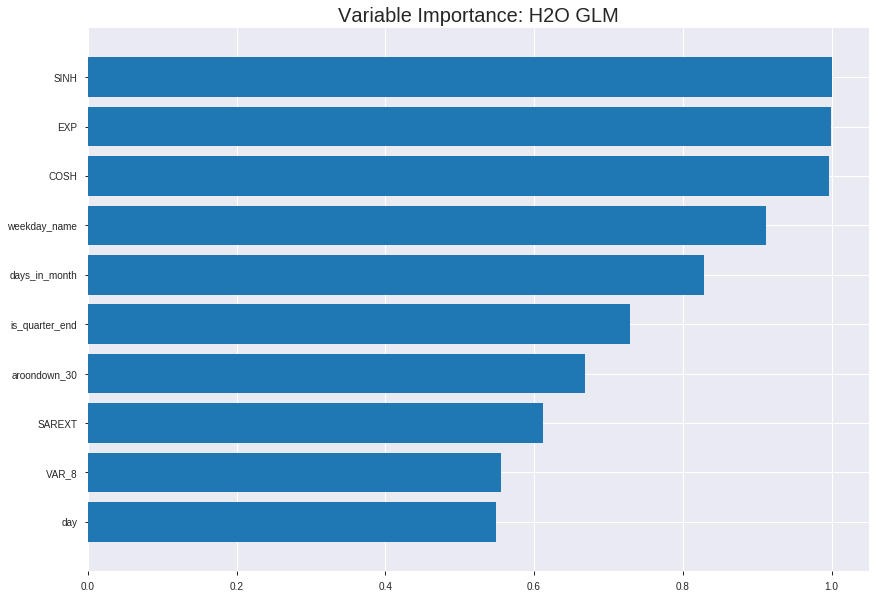

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_200020_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24189217622995973
RMSE: 0.491825351349399
LogLoss: 0.6768142029946462
Null degrees of freedom: 1724
Residual degrees of freedom: 1674
Null deviance: 2340.659668736101
Residual deviance: 2335.0090003315295
AIC: 2437.0090003315295
AUC: 0.5576839991691477
pr_auc: 0.6227316116262475
Gini: 0.11536799833829536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.559961812742382: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    706   0.9874   (706.0/715.0)
1      2    1008  0.002    (2.0/1010.0)
Total  11   1714  0.4104   (708.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.559962     0.740088  390
max f2                       0.557356     0.87628   397
max f0point5                 0.568522     0.64329   352
max accuracy                 0.568522     0.593043  352
max precision                0.623437     1         0
max recall                   0.557356     1         397
max specificity              0.623437     1         0
max absolute_mcc             0.587924     0.107449  167
max min_per_class_accuracy   0.585567     0.537063  198
max mean_per_class_accuracy  0.587924     0.553109  167

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.608961           1.13861   1.13861            0.666667         0.612939  0.666667                    0.612939            0.0118812       0.0118812                  13.8614   13.8614
    2        0.0202899                   0.605937           1.00466   1.07355            0.588235         0.60709   0.628571                    0.610098            0.00990099      0.0217822                  0.465929  7.35502
    3        0.0301449                   0.602842           1.30606   1.14956            0.764706         0.604313  0.673077                    0.608207            0.0128713       0.0346535                  30.6057   14.9562
    4        0.04                        0.600446           1.10513   1.13861            0.647059         0.60179   0.666667                    0.606626            0.0108911       0.0455446                  10.5125   13.8614
    5        0.0504348                   0.599251           0.759076  1.06009            0.444444         0.599618  0.62069                     0.605176            0.00792079      0.0534653                  -24.0924  6.00888
    6        0.10029                     0.595423           1.0327    1.04647            0.604651         0.597149  0.612717                    0.601186            0.0514851       0.10495                    3.26963   4.64717
    7        0.150145                    0.593772           0.973118  1.02211            0.569767         0.594582  0.598456                    0.598993            0.0485149       0.153465                   -2.68823  2.21148
    8        0.2                         0.592318           1.27101   1.08416            0.744186         0.592984  0.634783                    0.597495            0.0633663       0.216832                   27.1011   8.41584
    9        0.30029                     0.589652           1.1452    1.10454            0.67052          0.590972  0.646718                    0.595317            0.114851        0.331683                   14.5195   10.4543
    10       0.4                         0.587585           1.09227   1.10149            0.639535         0.588639  0.644928                    0.593652            0.108911        0.440594                   9.22749   10.1485
    11       0.50029                     0.585677           0.898386  1.06077            0.526012         0.586562  0.621089                    0.592231            0.090099        0.530693                   -10.1614  6.07712
    12       0.6                         0.584079           1.04263   1.05776            0.610465         0.584835  0.619324                    0.591002            0.10396         0.634653                   4.26261   5.77558
    13       0.69971                     0.581891           0.992977  1.04852            0.581395         0.582988  0.613919                    0.58986             0.0990099       0.733663                   -0.70228  4.85247
    14       0.8                         0.579364           0.898386  1.0297             0.526012         0.58065   0.602899                    0.588705            0.090099        0.823762                   -10.1614  2.9703
    15       0.89971                     0.57503            0.893679  1.01463            0.523256         0.57746   0.594072                    0.587459            0.0891089       0.912871                   -10.6321  1.46282
    16       1                           0.55441            0.868769  1                  0.508671         0.567999  0.585507                    0.585507          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.39183267203616307
RMSE: 0.6259653920434923
LogLoss: 4.654018195246974
Null degrees of freedom: 492
Residual degrees of freedom: 442
Null deviance: 668.7154569489843
Residual deviance: 11162.01713879223
AIC: 11264.01713879223
AUC: 0.5024255376891241
pr_auc: 0.5966703443717406
Gini: 0.0048510753782482485
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.6091134670533e-10: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.60911e-10  0.73913    399
max f2                       6.60911e-10  0.876289   399
max f0point5                 6.60911e-10  0.639098   399
max accuracy                 6.60911e-10  0.586207   399
max precision                0.605239     1          0
max recall                   6.60911e-10  1          399
max specificity              0.605239     1          0
max absolute_mcc             0.576846     0.0751057  78
max min_per_class_accuracy   0.40102      0.512111   245
max mean_per_class_accuracy  0.576846     0.52797    78

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 29.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.602166           1.02353   1.02353            0.6              0.603965     0.6                         0.603965            0.0103806       0.0103806                  2.35294   2.35294
    2        0.020284                    0.600443           1.02353   1.02353            0.6              0.601448     0.6                         0.602706            0.0103806       0.0207612                  2.35294   2.35294
    3        0.030426                    0.598759           1.36471   1.13725            0.8              0.599888     0.666667                    0.601767            0.0138408       0.0346021                  36.4706   13.7255
    4        0.040568                    0.596842           0.341176  0.938235           0.2              0.597627     0.55                        0.600732            0.00346021      0.0380623                  -65.8824  -6.17647
    5        0.0507099                   0.594461           1.70588   1.09176            1                0.595647     0.64                        0.599715            0.017301        0.0553633                  70.5882   9.17647
    6        0.10142                     0.582249           1.16      1.12588            0.68             0.587681     0.66                        0.593698            0.0588235       0.114187                   16        12.5882
    7        0.150101                    0.577663           1.13725   1.12957            0.666667         0.579919     0.662162                    0.589229            0.0553633       0.16955                    13.7255   12.9571
    8        0.200811                    0.572389           0.818824  1.0511             0.48             0.575126     0.616162                    0.585668            0.0415225       0.211073                   -18.1176  5.10992
    9        0.300203                    0.553089           0.939976  1.01431            0.55102          0.563487     0.594595                    0.578324            0.0934256       0.304498                   -6.0024   1.43084
    10       0.399594                    0.521013           0.939976  0.99582            0.55102          0.536831     0.583756                    0.568003            0.0934256       0.397924                   -6.0024   -0.418035
    11       0.501014                    0.400481           1.12588   1.02215            0.66             0.463521     0.59919                     0.546853            0.114187        0.512111                   12.5882   2.21481
    12       0.600406                    0.0749779          0.80072   0.985493           0.469388         0.221275     0.577703                    0.492957            0.0795848       0.591696                   -19.928   -1.45072
    13       0.699797                    0.0027586          0.97479   0.983973           0.571429         0.0309117    0.576812                    0.427333            0.0968858       0.688581                   -2.52101  -1.60273
    14       0.799189                    4.55506e-06        1.11405   1.00015            0.653061         0.000484497  0.586294                    0.374248            0.110727        0.799308                   11.4046   0.0149298
    15       0.89858                     3.3369e-21         1.07923   1.0089             0.632653         8.83688e-07  0.591422                    0.332852            0.107266        0.906574                   7.92317   0.889656
    16       1                           1.56609e-198       0.921176  1                  0.54         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 20:00:21  0.000 sec   2            2.5       51            1.35363           22.641
    2019-08-24 20:00:21  0.009 sec   4            1.6       51            1.35231           32.1627
    2019-08-24 20:00:21  0.018 sec   6            0.97      51            1.35069           43.0286
    2019-08-24 20:00:21  0.028 sec   8            0.6       51            1.3488            54.4383
    2019-08-24 20:00:21  0.038 sec   10           0.38      51            1.34673           64.7344

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5222672064777328)

('F1', 0.6861702127659575)

('auc', 0.5159965838917356)

('logloss', 17.665125352453682)

('mean_per_class_error', 0.47891210090658254)

('rmse', 0.7213561351217563)

('mse', 0.5203546736777976)

glm prediction progress: |████████████████████████████████████████████████| 100%


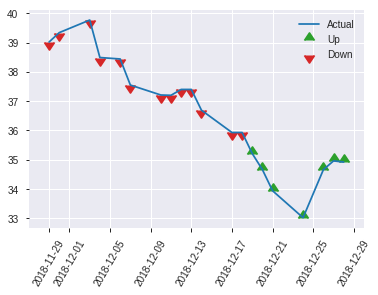


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5203546736777976
RMSE: 0.7213561351217563
LogLoss: 17.665125352453682
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 345.9465433426434
Residual deviance: 123213.9393849041
AIC: 123315.9393849041
AUC: 0.5159965838917356
pr_auc: 0.5702157579209564
Gini: 0.03199316778347128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1703470262429859e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.17035e-49  0.68617    19
max f2                       1.17035e-49  0.845347   19
max f0point5                 1.17035e-49  0.57744    19
max accuracy                 1.17035e-49  0.522267   19
max precision                0.273482     1          0
max recall                   1.17035e-49  1          19
max specificity              0.273482     1          0
max absolute_mcc             7.67074e-44  0.0810485  17
max min_per_class_accuracy   7.67074e-44  0.0930233  17
max mean_per_class_accuracy  7.67074e-44  0.521088   17

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.000647843        1.27649   1.27649            0.666667         0.103052      0.666667                    0.103052            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   4.31827e-05        0.957364  1.14884            0.5              0.000344622   0.6                         0.0619691           0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   1.05786e-12        0         0.718023           0                1.45165e-05   0.375                       0.0387362           0               0.0232558                  -100       -28.1977
    4        0.0404858                   1.71159e-26        1.91473   0.957364           1                5.24685e-13   0.5                         0.0309889           0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   9.4291e-34         1.27649   1.03101            0.666667         5.47603e-27   0.538462                    0.0238376           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    4.53345e-57        1.43605   1.22543            0.75             4.0593e-37    0.64                        0.0123956           0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    2.37157e-74        1.27649   1.24199            0.666667         6.44246e-59   0.648649                    0.00837539          0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    1.78035e-90        0.883721  1.14884            0.461538         2.29247e-76   0.6                         0.00619779          0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    6.19956e-157       1.19671   1.16436            0.625            1.9739e-94    0.608108                    0.00418769          0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     4.21489e-213       1.07225   1.1411             0.56             3.00591e-159  0.59596                     0.00313019          0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    2.58884e-284       0.995659  1.11178            0.52             4.11781e-216  0.580645                    0.00249911          0.100775        0.55814                    -0.434109  11.1778
    12       1                           0                  0.887313  1                  0.463415         3.16343e-289  0.522267                    0.00125461          0.44186         1                          -11.2687   0

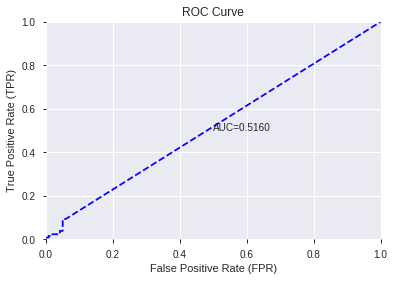

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


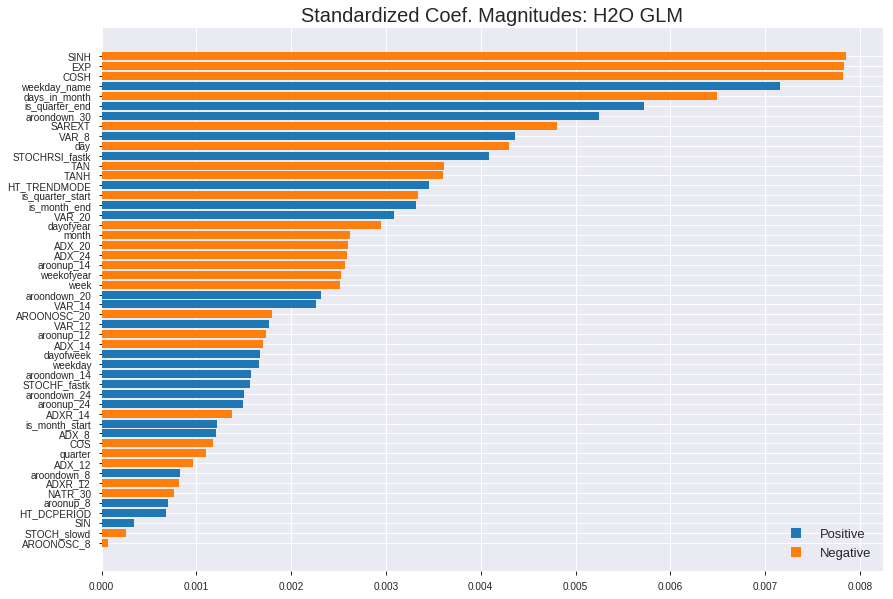

'log_likelihood'
--2019-08-24 20:00:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_200020_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_200020_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SINH',
 'EXP',
 'COSH',
 'weekday_name',
 'days_in_month',
 'is_quarter_end',
 'aroondown_30',
 'SAREXT',
 'VAR_8',
 'day',
 'STOCHRSI_fastk',
 'TAN',
 'TANH',
 'HT_TRENDMODE',
 'is_quarter_start',
 'is_month_end',
 'VAR_20',
 'dayofyear',
 'month',
 'ADX_20',
 'ADX_24',
 'aroonup_14',
 'weekofyear',
 'week',
 'aroondown_20',
 'VAR_14',
 'AROONOSC_20',
 'VAR_12',
 'aroonup_12',
 'ADX_14',
 'dayofweek',
 'weekday',
 'aroondown_14',
 'STOCHF_fastk',
 'aroondown_24',
 'aroonup_24',
 'ADXR_14',
 'is_month_start',
 'ADX_8',
 'COS',
 'quarter',
 'ADX_12',
 'aroondown_8',
 'ADXR_12',
 'NATR_30',
 'aroonup_8',
 'HT_DCPERIOD',
 'SIN',
 'STOCH_slowd',
 'AROONOSC_8']

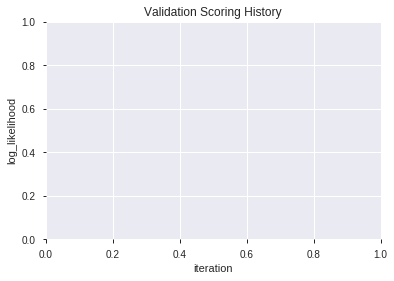

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_200030_model_2  0.472540  0.700962              0.474215  0.503869  0.253884
1  XGBoost_grid_1_AutoML_20190824_200030_model_1  0.466627  0.711250              0.495401  0.508793  0.258870
2  XGBoost_grid_1_AutoML_20190824_200030_model_4  0.457036  0.716201              0.500000  0.510876  0.260995
3  XGBoost_grid_1_AutoML_20190824_200030_model_6  0.455656  0.717778              0.478091  0.512011  0.262155
4               XGBoost_1_AutoML_20190824_200030  0.448364  0.722130              0.500000  0.513854  0.264046
5  XGBoost_grid_1_AutoML_20190824_200030_model_3  0.446065  0.718231              0.478814  0.512294  0.262445
6  XGBoost_grid_1_AutoML_20190824_200030_model_7  0.441006  0.739182              0.482690  0.521611  0.272078
7               XGBoost_3_AutoML_20190824_200030  0.440612  0.721365              0.500000  0.513538  0.263721
8  XGBoost_grid_1_AutoML_20190824_200030_model_5  0.433911  0.779219              0.491525  0.537974  0.289416
9               XGBoost_2_AutoML_20190824_200030  0.431284  0.725835              0.500000  0.515627  0.265871

variable  relative_importance  scaled_importance  percentage
0      STOCH_slowd           283.729706           1.000000    0.063415
1            VAR_8           246.325272           0.868169    0.055055
2            ADX_8           233.568039           0.823206    0.052204
3           ADX_24           201.541641           0.710330    0.045046
4           SAREXT           196.286530           0.691808    0.043871
5              day           189.167053           0.666716    0.042280
6             COSH           183.395844           0.646375    0.040990
7      HT_DCPERIOD           164.397827           0.579417    0.036744
8          NATR_30           155.724426           0.548848    0.034805
9              COS           153.487335           0.540963    0.034305
10          VAR_20           147.915939           0.521327    0.033060
11          ADX_12           145.108948           0.511434    0.032433
12       dayofyear           143.520172           0.505834    0.032078
13         ADXR_12           136.322403           0.480466    0.030469
14             SIN           130.447220           0.459759    0.029156
15          ADX_20           127.018242           0.447673    0.028389
16          VAR_12           125.987289           0.444040    0.028159
17    aroondown_30           116.718964           0.411374    0.026087
18             TAN           115.885689           0.408437    0.025901
19         ADXR_14           102.407387           0.360933    0.022889
20  STOCHRSI_fastk           100.200119           0.353153    0.022395
21          VAR_14            90.109360           0.317589    0.020140
22      aroonup_24            89.609413           0.315827    0.020028
23    STOCHF_fastk            86.983292           0.306571    0.019441
24    aroondown_14            79.156067           0.278984    0.017692
25          ADX_14            70.541245           0.248621    0.015766
26     AROONOSC_20            69.889397           0.246324    0.015621
27    aroondown_24            69.180687           0.243826    0.015462
28    weekday_name            64.356369           0.226823    0.014384
29    aroondown_20            60.087231           0.211776    0.013430
30       dayofweek            58.268993           0.205368    0.013023
31      aroonup_14            56.365406           0.198659    0.012598
32            week            53.789528           0.189580    0.012022
33      AROONOSC_8            42.414421           0.149489    0.009480
34       aroonup_8            41.026268           0.144596    0.009170
35      aroonup_12            38.628395           0.136145    0.008634
36     aroondown_8            33.688965           0.118736    0.007530
37           month            17.168640           0.060511    0.003837
38             EXP            15.124516           0.053306    0.003380
39            TANH            10.653807           0.037549    0.002381
40   days_in_month            10.369112           0.036546    0.002318
41    HT_TRENDMODE             9.272934           0.032682    0.002073
42         weekday             6.060656           0.021361    0.001355
43    is_month_end             2.242236           0.007903    0.000501

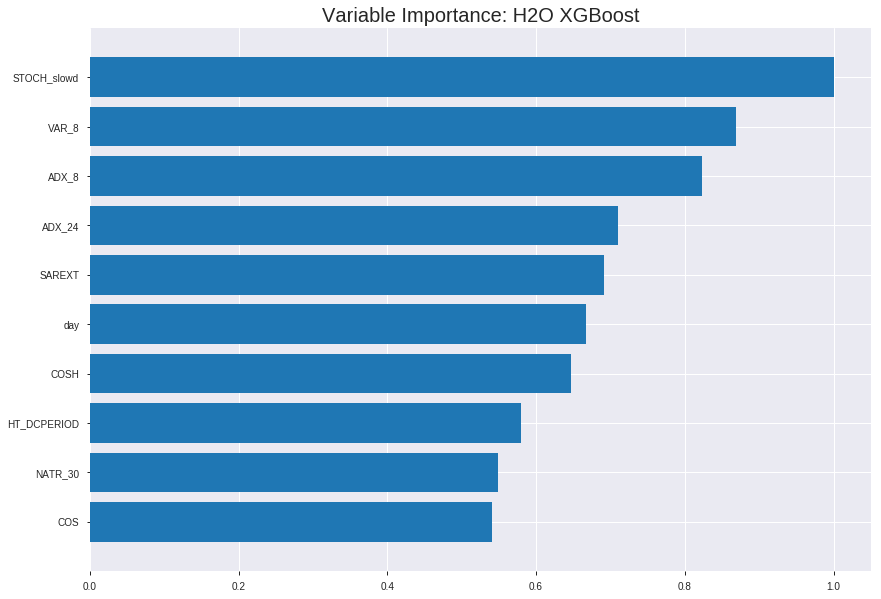

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_200030_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19530673205026886
RMSE: 0.441935212503223
LogLoss: 0.5804235507834006
Mean Per-Class Error: 0.16618084885411621
AUC: 0.9031420065083431
pr_auc: 0.924539963027177
Gini: 0.8062840130166862
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5656680166721344: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      577  138  0.193    (138.0/715.0)
1      149  861  0.1475   (149.0/1010.0)
Total  726  999  0.1664   (287.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.565668     0.857143  206
max f2                       0.513613     0.90646   269
max f0point5                 0.585291     0.875504  179
max accuracy                 0.571872     0.833623  198
max precision                0.763343     1         0
max recall                   0.40579      1         370
max specificity              0.763343     1         0
max absolute_mcc             0.571872     0.661959  198
max min_per_class_accuracy   0.571872     0.832673  198
max mean_per_class_accuracy  0.571872     0.833819  198

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.731021           1.70792   1.70792            1                0.742917  1                           0.742917            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.714947           1.70792   1.70792            1                0.720698  1                           0.732125            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.708831           1.70792   1.70792            1                0.711691  1                           0.725444            0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.700048           1.60745   1.68317            0.941176         0.705584  0.985507                    0.720551            0.0158416       0.0673267                  60.7455   68.3168
    5        0.0504348                   0.694822           1.70792   1.68829            1                0.697395  0.988506                    0.71576             0.0178218       0.0851485                  70.7921   68.829
    6        0.10029                     0.674763           1.68806   1.68818            0.988372         0.683873  0.988439                    0.699909            0.0841584       0.169307                   68.8061   68.8176
    7        0.150145                    0.658293           1.62848   1.66836            0.953488         0.66642   0.976834                    0.688789            0.0811881       0.250495                   62.8483   66.8355
    8        0.2                         0.645834           1.60862   1.65347            0.94186          0.651199  0.968116                    0.679419            0.080198        0.330693                   60.8623   65.3465
    9        0.30029                     0.624818           1.59932   1.63538            0.936416         0.634884  0.957529                    0.664545            0.160396        0.491089                   59.9325   63.5384
    10       0.4                         0.604506           1.46961   1.59406            0.860465         0.614538  0.933333                    0.65208             0.146535        0.637624                   46.9606   59.4059
    11       0.50029                     0.585121           1.35252   1.54564            0.791908         0.595843  0.904983                    0.640806            0.135644        0.773267                   35.2515   54.5639
    12       0.6                         0.561225           0.923469  1.44224            0.540698         0.572746  0.844444                    0.629496            0.0920792       0.865347                   -7.65312  44.2244
    13       0.69971                     0.534507           0.695084  1.33577            0.406977         0.54925   0.782104                    0.618061            0.0693069       0.934653                   -30.4916  33.5772
    14       0.8                         0.499894           0.345533  1.21163            0.202312         0.517501  0.70942                     0.605454            0.0346535       0.969307                   -65.4467  21.1634
    15       0.89971                     0.46153            0.228385  1.10267            0.133721         0.482332  0.645619                    0.591809            0.0227723       0.992079                   -77.1615  10.2665
    16       1                           0.334218           0.078979  1                  0.0462428        0.421439  0.585507                    0.574723          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2510880270905628
RMSE: 0.5010868458566468
LogLoss: 0.6953207699602576
Mean Per-Class Error: 0.46539792387543255
AUC: 0.5176487550037316
pr_auc: 0.6186490389629916
Gini: 0.035297510007463284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35196930170059204: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    289  0        (0.0/289.0)
Total  2    491  0.4097   (202.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.351969     0.741026   397
max f2                       0.351969     0.877353   397
max f0point5                 0.351969     0.641367   397
max accuracy                 0.351969     0.590264   397
max precision                0.673538     1          0
max recall                   0.351969     1          397
max specificity              0.673538     1          0
max absolute_mcc             0.572906     0.0950831  56
max min_per_class_accuracy   0.497485     0.5        202
max mean_per_class_accuracy  0.563938     0.534602   70

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.650089           1.36471   1.36471            0.8              0.667959  0.8                         0.667959            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.638921           1.70588   1.53529            1                0.645956  0.9                         0.656957            0.017301        0.0311419                  70.5882   53.5294
    3        0.030426                    0.630038           0.682353  1.25098            0.4              0.634601  0.733333                    0.649505            0.00692042      0.0380623                  -31.7647  25.098
    4        0.040568                    0.614347           1.02353   1.19412            0.6              0.62429   0.7                         0.643201            0.0103806       0.0484429                  2.35294   19.4118
    5        0.0507099                   0.604731           1.36471   1.22824            0.8              0.608466  0.72                        0.636254            0.0138408       0.0622837                  36.4706   22.8235
    6        0.10142                     0.580536           1.09176   1.16               0.64             0.588079  0.68                        0.612167            0.0553633       0.117647                   9.17647   16
    7        0.150101                    0.564855           1.13725   1.15262            0.666667         0.571835  0.675676                    0.599086            0.0553633       0.17301                    13.7255   15.2623
    8        0.200811                    0.548612           0.750588  1.0511             0.44             0.557079  0.616162                    0.588478            0.0380623       0.211073                   -24.9412  5.10992
    9        0.300203                    0.530529           1.04442   1.04889            0.612245         0.538743  0.614865                    0.572012            0.103806        0.314879                   4.44178   4.88871
    10       0.399594                    0.510624           1.07923   1.05643            0.632653         0.521686  0.619289                    0.559494            0.107266        0.422145                   7.92317   5.64348
    11       0.501014                    0.49747            0.784706  1.00143            0.46             0.503795  0.587045                    0.548219            0.0795848       0.50173                    -21.5294  0.142891
    12       0.600406                    0.48598            1.07923   1.01431            0.632653         0.491536  0.594595                    0.538836            0.107266        0.608997                   7.92317   1.43084
    13       0.699797                    0.469337           1.04442   1.01858            0.612245         0.477113  0.597101                    0.53007             0.103806        0.712803                   4.44178   1.85848
    14       0.799189                    0.45342            0.870348  1.00015            0.510204         0.461131  0.586294                    0.521496            0.0865052       0.799308                   -12.9652  0.0149298
    15       0.89858                     0.430001           0.870348  0.985792           0.510204         0.443396  0.577878                    0.512857            0.0865052       0.885813                   -12.9652  -1.42079
    16       1                           0.347507           1.12588   1                  0.66             0.403524  0.586207                    0.501769           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:00:34  0.468 sec   0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 20:00:34  0.526 sec   5                  0.491596         0.676461            0.735576        0.749942           1.58141          0.315362                         0.500408           0.693963              0.503138          0.58605              1.21849            0.413793
    2019-08-24 20:00:34  0.571 sec   10                 0.484339         0.662203            0.778653        0.804073           1.70792          0.273043                         0.499479           0.692095              0.519328          0.605189             1.36471            0.413793
    2019-08-24 20:00:34  0.619 sec   15                 0.477391         0.648645            0.813003        0.843916           1.70792          0.253333                         0.49801            0.689151              0.531133          0.606997             1.70588            0.411765
    2019-08-24 20:00:34  0.669 sec   20                 0.470946         0.636138            0.842457        0.871769           1.70792          0.231304                         0.49816            0.689448              0.528513          0.614675             1.36471            0.411765
    2019-08-24 20:00:34  0.725 sec   25                 0.46527          0.625139            0.856893        0.886791           1.70792          0.215652                         0.49865            0.690419              0.519124          0.611325             1.36471            0.409736
    2019-08-24 20:00:34  0.778 sec   30                 0.460001         0.614969            0.86931         0.89703            1.70792          0.212754                         0.49952            0.692157              0.519362          0.614901             1.02353            0.411765
    2019-08-24 20:00:34  0.834 sec   35                 0.454844         0.605052            0.878284        0.904608           1.70792          0.211014                         0.499945           0.693039              0.525307          0.616312             1.02353            0.411765
    2019-08-24 20:00:34  0.888 sec   40                 0.450843         0.597328            0.887089        0.914014           1.70792          0.198841                         0.499559           0.692237              0.525324          0.622348             1.36471            0.411765
    2019-08-24 20:00:34  0.951 sec   45                 0.446325         0.588723            0.894664        0.91831            1.70792          0.185507                         0.499844           0.692807              0.52479           0.62211              1.36471            0.411765
    2019-08-24 20:00:35  1.010 sec   50                 0.441935         0.580424            0.903142        0.92454            1.70792          0.166377                         0.501087           0.695321              0.517649          0.618649             1.36471            0.409736

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ---------------------
STOCH_slowd    283.7297058105469      1.0                   0.06341543108313588
VAR_8          246.3252716064453      0.8681687766980684    0.05505529722722675
ADX_8          233.5680389404297      0.8232061506326329    0.05220397291265732
ADX_24         201.54164123535156     0.7103297155988515    0.045045865125862485
SAREXT         196.28652954101562     0.691808173487766     0.043871313548563544
---            ---                    ---                   ---
TANH           10.653806686401367     0.03754914084856229   0.0023811949537129646
days_in_month  10.369112014770508     0.03654573984471761   0.0023175638465049025
HT_TRENDMODE   9.272933959960938      0.032682280952818867  0.0020725609354031696
weekday        6.0606560707092285     0.02136066808160043   0.0013545959746184724
is_month_end   2.2422361373901367     0.007902719001468713  0.0005011543322070276


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6956521739130433)

('auc', 0.47253974510576796)

('logloss', 0.7009615620842419)

('mean_per_class_error', 0.4681710681907765)

('rmse', 0.5038689024746555)

('mse', 0.2538838708810139)

xgboost prediction progress: |████████████████████████████████████████████| 100%


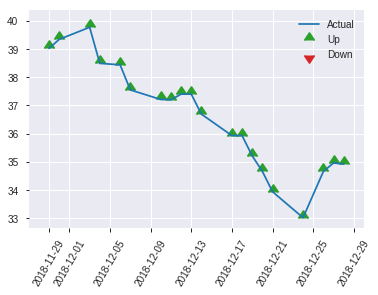


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2538838708810139
RMSE: 0.5038689024746555
LogLoss: 0.7009615620842419
Mean Per-Class Error: 0.4681710681907765
AUC: 0.47253974510576796
pr_auc: 0.49596469802291804
Gini: -0.05492050978846408
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4092746675014496: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    111  0.9407   (111.0/118.0)
1      1    128  0.0078   (1.0/129.0)
Total  8    239  0.4534   (112.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409275     0.695652  238
max f2                       0.397319     0.850923  241
max f0point5                 0.426816     0.590778  227
max accuracy                 0.426816     0.550607  227
max precision                0.606575     0.666667  2
max recall                   0.397319     1         241
max specificity              0.614798     0.991525  0
max absolute_mcc             0.397319     0.15029   241
max min_per_class_accuracy   0.508223     0.5       123
max mean_per_class_accuracy  0.426816     0.531829  227

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 51.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.605663           1.27649   1.27649            0.666667         0.611736  0.666667                    0.611736            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.601317           0         0.765891           0                0.604414  0.4                         0.608807            0               0.0155039                  -100       -23.4109
    3        0.0323887                   0.599902           0.638243  0.718023           0.333333         0.60063   0.375                       0.605741            0.00775194      0.0232558                  -36.1757   -28.1977
    4        0.0404858                   0.597763           0         0.574419           0                0.599521  0.3                         0.604497            0               0.0232558                  -100       -42.5581
    5        0.0526316                   0.597011           1.91473   0.883721           1                0.597397  0.461538                    0.602858            0.0232558       0.0465116                  91.4729    -11.6279
    6        0.101215                    0.580786           0.957364  0.91907            0.5              0.588567  0.48                        0.595999            0.0465116       0.0930233                  -4.26357   -8.09302
    7        0.149798                    0.569211           0.797804  0.87974            0.416667         0.575482  0.459459                    0.589345            0.0387597       0.131783                   -20.2196   -12.026
    8        0.202429                    0.560943           1.03101   0.91907            0.538462         0.564875  0.48                        0.582982            0.0542636       0.186047                   3.10078    -8.09302
    9        0.299595                    0.543931           1.03714   0.957364           0.541667         0.553087  0.5                         0.573287            0.100775        0.286822                   3.71447    -4.26357
    10       0.40081                     0.526841           0.91907   0.947694           0.48             0.534283  0.494949                    0.563437            0.0930233       0.379845                   -8.09302   -5.2306
    11       0.502024                    0.508223           1.22543   1.00369            0.64             0.517393  0.524194                    0.554154            0.124031        0.503876                   22.5426    0.368842
    12       0.59919                     0.494364           0.638243  0.944427           0.333333         0.501706  0.493243                    0.545649            0.0620155       0.565891                   -36.1757   -5.5573
    13       0.700405                    0.48168            0.995659  0.95183            0.52             0.487458  0.49711                     0.53724             0.100775        0.666667                   -0.434109  -4.81696
    14       0.797571                    0.467382           1.19671   0.981663           0.625            0.475963  0.51269                     0.529775            0.116279        0.782946                   19.6705    -1.83371
    15       0.898785                    0.43657            1.30202   1.01774            0.68             0.453603  0.531532                    0.521197            0.131783        0.914729                   30.2016    1.77387
    16       1                           0.376338           0.842481  1                  0.44             0.41243   0.522267          

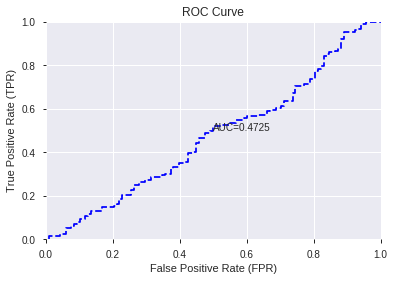

This function is available for GLM models only


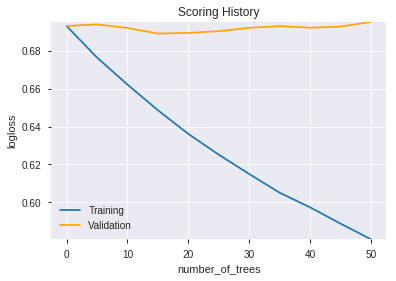

--2019-08-24 20:00:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_200030_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_200030_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCH_slowd',
 'VAR_8',
 'ADX_8',
 'ADX_24',
 'SAREXT',
 'day',
 'COSH',
 'HT_DCPERIOD',
 'NATR_30',
 'COS',
 'VAR_20',
 'ADX_12',
 'dayofyear',
 'ADXR_12',
 'SIN',
 'ADX_20',
 'VAR_12',
 'aroondown_30',
 'TAN',
 'ADXR_14',
 'STOCHRSI_fastk',
 'VAR_14',
 'aroonup_24',
 'STOCHF_fastk',
 'aroondown_14',
 'ADX_14',
 'AROONOSC_20',
 'aroondown_24',
 'weekday_name',
 'aroondown_20',
 'dayofweek',
 'aroonup_14',
 'week',
 'AROONOSC_8',
 'aroonup_8',
 'aroonup_12',
 'aroondown_8',
 'month',
 'EXP',
 'TANH',
 'days_in_month',
 'HT_TRENDMODE',
 'weekday',
 'is_month_end']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [881] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_200049_model_2  0.565300  11.778674              0.500000  0.713136  0.508564
1  DeepLearning_grid_1_AutoML_20190824_200049_model_4  0.508672  17.646965              0.500000  0.720539  0.519176
2               DeepLearning_1_AutoML_20190824_200049  0.505748  15.896943              0.491525  0.687765  0.473020
3  DeepLearning_grid_1_AutoML_20190824_200049_model_1  0.505190  16.108598              0.495401  0.691407  0.478043
4  DeepLearning_grid_1_AutoML_20190824_200049_model_9  0.500000   0.696561              0.500000  0.501678  0.251681
5  DeepLearning_grid_1_AutoML_20190824_200049_model_5  0.500000   0.707922              0.500000  0.507117  0.257168
6  DeepLearning_grid_1_AutoML_20190824_200049_model_6  0.500000   0.702007              0.500000  0.504313  0.254332
7  DeepLearning_grid_1_AutoML_20190824_200049_model_8  0.500000   0.698868              0.500000  0.502801  0.252809
8  DeepLearning_grid_1_AutoML_20190824_200049_model_3  0.468040  14.095822              0.486927  0.691169  0.477715
9  DeepLearning_grid_1_AutoML_20190824_200049_model_7  0.459105  13.239961              0.495763  0.685024  0.469258

variable  relative_importance  scaled_importance  percentage
0                        TANH             1.000000           1.000000    0.001947
1                weekday_name             0.800493           0.800493    0.001559
2               days_in_month             0.783775           0.783775    0.001526
3                         day             0.780826           0.780826    0.001520
4                         SIN             0.760419           0.760419    0.001481
..                        ...                  ...                ...         ...
964   BBANDS_upperband_20_7_2             0.474627           0.474627    0.000924
965   BBANDS_lowerband_12_7_3             0.472717           0.472717    0.000920
966  BBANDS_middleband_14_2_4             0.469350           0.469350    0.000914
967                    MAX_30             0.467971           0.467971    0.000911
968   BBANDS_upperband_20_2_3             0.462028           0.462028    0.000900

[969 rows x 4 columns]

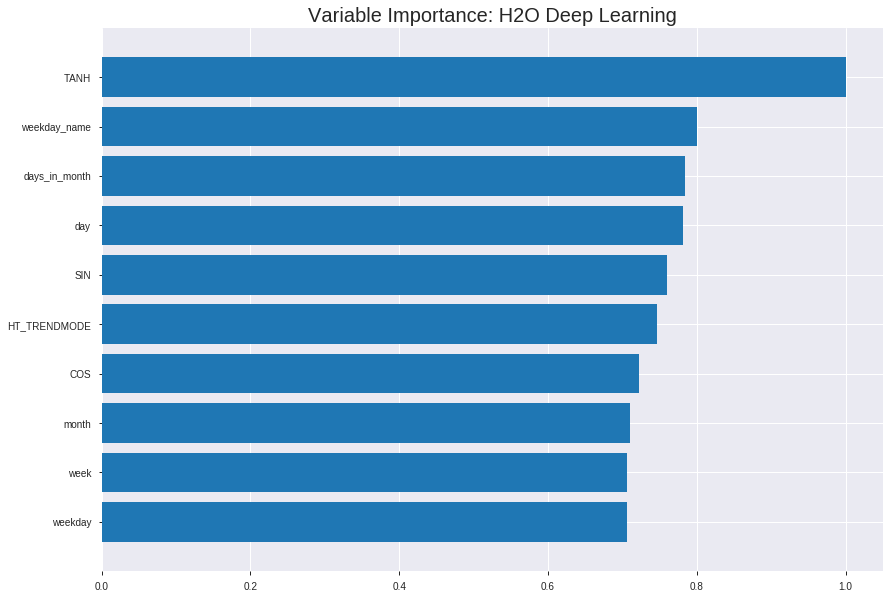

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_200049_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2862051755187425
RMSE: 0.5349814721265985
LogLoss: 0.7839777881680956
Mean Per-Class Error: 0.48465346534653464
AUC: 0.5079256387177179
pr_auc: 0.5894441513531321
Gini: 0.015851277435435795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11387658576572637: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    713   0.9972   (713.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  2    1723  0.4133   (713.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.113877     0.739115  398
max f2                       0.113877     0.87628   398
max f0point5                 0.177702     0.639237  386
max accuracy                 0.177702     0.586667  386
max precision                0.954055     1         0
max recall                   0.113877     1         398
max specificity              0.954055     1         0
max absolute_mcc             0.113877     0.040493  398
max min_per_class_accuracy   0.458973     0.496503  225
max mean_per_class_accuracy  0.316629     0.515347  319

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.93219            1.13861   1.13861            0.666667         0.941911  0.666667                    0.941911            0.0118812       0.0118812                  13.8614   13.8614
    2        0.0202899                   0.896813           0.803727  0.975955           0.470588         0.912822  0.571429                    0.927782            0.00792079      0.019802                   -19.6273  -2.40453
    3        0.0301449                   0.886227           1.20559   1.05103            0.705882         0.890489  0.615385                    0.91559             0.0118812       0.0316832                  20.5591   5.10282
    4        0.04                        0.877858           0.803727  0.990099           0.470588         0.881813  0.57971                     0.907268            0.00792079      0.039604                   -19.6273  -0.990099
    5        0.0504348                   0.864775           1.04373   1.00119            0.611111         0.869924  0.586207                    0.899542            0.0108911       0.050495                   4.37294   0.119495
    6        0.10029                     0.830249           0.913539  0.95762            0.534884         0.849018  0.560694                    0.874426            0.0455446       0.0960396                  -8.6461   -4.23797
    7        0.150145                    0.780242           1.11213   1.00893            0.651163         0.805198  0.590734                    0.851439            0.0554455       0.151485                   11.2134   0.892618
    8        0.2                         0.703673           1.09227   1.0297             0.639535         0.744137  0.602899                    0.824691            0.0544554       0.205941                   9.22749   2.9703
    9        0.30029                     0.574846           1.00698   1.02211            0.589595         0.638457  0.598456                    0.762493            0.10099         0.306931                   0.69822   2.21148
    10       0.4                         0.504162           0.973118  1.0099             0.569767         0.540472  0.591304                    0.707149            0.0970297       0.40396                    -2.68823  0.990099
    11       0.50029                     0.457396           0.937876  0.995463           0.549133         0.479699  0.582851                    0.661554            0.0940594       0.49802                    -6.21244  -0.453748
    12       0.6                         0.419862           1.0327    1.00165            0.604651         0.43793   0.586473                    0.624391            0.10297         0.60099                    3.26963   0.165017
    13       0.69971                     0.370618           0.943328  0.993339           0.552326         0.396473  0.581607                    0.591912            0.0940594       0.69505                    -5.66717  -0.666082
    14       0.8                         0.323617           1.15507   1.01361            0.676301         0.343967  0.593478                    0.560829            0.115842        0.810891                   15.5068   1.36139
    15       0.89971                     0.283417           0.983047  1.01023            0.575581         0.304086  0.591495                    0.532376            0.0980198       0.908911                   -1.69526  1.02263
    16       1                           0.109172           0.908258  1                  0.531792         0.229205  0.585507                    0.5019



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3120950993318042
RMSE: 0.5586547228224283
LogLoss: 1.1124563786548167
Mean Per-Class Error: 0.47563437139561704
AUC: 0.4992027953049732
pr_auc: 0.5903727106556105
Gini: -0.0015944093900536194
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.6936151652708418e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.69362e-05  0.73913    399
max f2                       2.69362e-05  0.876289   399
max f0point5                 0.225417     0.642618   374
max accuracy                 0.225417     0.590264   374
max precision                0.94413      1          0
max recall                   2.69362e-05  1          399
max specificity              0.94413      1          0
max absolute_mcc             0.937926     0.0792538  7
max min_per_class_accuracy   0.792706     0.480969   182
max mean_per_class_accuracy  0.876363     0.524366   83

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 70.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.940494           1.36471   1.36471            0.8              0.942785   0.8                         0.942785            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.939584           1.36471   1.36471            0.8              0.940187   0.8                         0.941486            0.0138408       0.0276817                  36.4706   36.4706
    3        0.030426                    0.936717           0.682353  1.13725            0.4              0.937752   0.666667                    0.940242            0.00692042      0.0346021                  -31.7647  13.7255
    4        0.040568                    0.935677           0.682353  1.02353            0.4              0.936194   0.6                         0.93923             0.00692042      0.0415225                  -31.7647  2.35294
    5        0.0507099                   0.931225           1.02353   1.02353            0.6              0.933159   0.6                         0.938015            0.0103806       0.0519031                  2.35294   2.35294
    6        0.10142                     0.910576           0.955294  0.989412           0.56             0.920107   0.58                        0.929061            0.0484429       0.100346                   -4.47059  -1.05882
    7        0.150101                    0.891012           1.13725   1.03736            0.666667         0.897941   0.608108                    0.918968            0.0553633       0.155709                   13.7255   3.73609
    8        0.200811                    0.883751           1.09176   1.0511             0.64             0.887081   0.616162                    0.910916            0.0553633       0.211073                   9.17647   5.10992
    9        0.300203                    0.858836           0.870348  0.991256           0.510204         0.873063   0.581081                    0.898383            0.0865052       0.297578                   -12.9652  -0.874404
    10       0.399594                    0.818296           1.0096    0.99582            0.591837         0.838613   0.583756                    0.883517            0.100346        0.397924                   0.960384  -0.418035
    11       0.501014                    0.788892           0.818824  0.95999            0.48             0.804171   0.562753                    0.867455            0.083045        0.480969                   -18.1176  -4.00095
    12       0.600406                    0.726084           1.11405   0.985493           0.653061         0.757643   0.577703                    0.849276            0.110727        0.591696                   11.4046   -1.45072
    13       0.699797                    0.667467           1.11405   1.00375            0.653061         0.69499    0.588406                    0.827363            0.110727        0.702422                   11.4046   0.375107
    14       0.799189                    0.599655           0.97479   1.00015            0.571429         0.634083   0.586294                    0.803326            0.0968858       0.799308                   -2.52101  0.0149298
    15       0.89858                     0.329338           1.07923   1.0089             0.632653         0.50001    0.591422                    0.769776            0.107266        0.906574                   7.92317   0.889656
    16       1                           2.25229e-10        0.921176  1                  0.54             0.0916858  0.586207        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:02:11  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 20:02:12  1 min 21.857 sec  521 obs/sec       0.529855  1             914        0.642036         6.97137             -0.698517      0.502622        0.253574           1.02815          0.414493                         0.643148           7.64407               -0.705249        0.514859          0.295859             1.01287            0.413793
    2019-08-24 20:02:25  1 min 34.244 sec  499 obs/sec       3.75478   7             6477       0.550753         1.00451             -0.249869      0.524451        0.591923           0.948845         0.411014                         0.664438           4.36689               -0.820014        0.499347          0.583776             0.682353           0.413793
    2019-08-24 20:02:37  1 min 46.174 sec  508 obs/sec       6.98087   13            12042      0.534981         0.783978            -0.179311      0.507926        0.589444           1.13861          0.413333                         0.558655           1.11246               -0.286627        0.499203          0.590373             1.36471            0.413793
    2019-08-24 20:02:50  1 min 59.240 sec  544 obs/sec       11.2313   21            19374      0.507063         0.71608             -0.0594342     0.498232        0.576757           0.948845         0.411594                         0.593006           3.35879               -0.449722        0.498745          0.481719             0.995098           0.409736
    2019-08-24 20:03:03  2 min 12.013 sec  566 obs/sec       15.4922   29            26724      0.506768         0.712486            -0.0582014     0.516139        0.598014           1.13861          0.414493                         0.577472           2.58041               -0.374761        0.496192          0.506627             0.918552           0.409736
    2019-08-24 20:03:15  2 min 24.503 sec  583 obs/sec       19.7664   37            34097      0.507634         0.714134            -0.0618211     0.539039        0.6183             0.759076         0.413913                         0.673307           3.95845               -0.868929        0.502341          0.583438             0.682353           0.413793
    2019-08-24 20:03:28  2 min 37.801 sec  601 obs/sec       24.5849   46            42409      0.494982         0.684135            -0.00955328    0.539263        0.605447           0.759076         0.413913                         0.580156           4.06151               -0.38757         0.493046          0.44417              1.06341            0.409736
    2019-08-24 20:03:41  2 min 50.584 sec  617 obs/sec       29.4174   55            50745      0.505842         0.712049            -0.0543378     0.527329        0.608608           1.13861          0.414493                         0.569293           1.25146               -0.336098        0.508693          0.578807             0.682353           0.413793
    2019-08-24 20:03:42

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
TANH                      1.0                    1.0                  0.0019471642171930762
weekday_name              0.800492525100708      0.800492525100708    0.0015586904010066289
days_in_month             0.7837753295898438     0.7837753295898438   0.0015261392760960533
day                       0.780825674533844      0.780825674533844    0.0015203958133179478
SIN                       0.7604185342788696     0.7604185342788696   0.0014806597600382214
---                       ---                    ---                  ---
BBANDS_upperband_20_7_2   0.4746272563934326     0.4746272563934326   0.0009241772101538157
BBANDS_lowerband_12_7_3   0.4727172255516052     0.4727172255516052   0.0009204580664448742
BBANDS_middleband_14_2_4  0.4693501889705658     0.4693501889705658   0.0009139018932962941
MAX_30                    0.4679706394672394     0.4679706394672394   0.0009112156838675704
BBANDS_upperband_20_2_3   0.46202781796455383    0.46202781796455383  0.0008996440344883755


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5708502024291497)

('F1', 0.6861702127659575)

('auc', 0.5653002233609249)

('logloss', 11.778674013536717)

('mean_per_class_error', 0.4259295756142425)

('rmse', 0.71313645063885)

('mse', 0.508563597229777)

deeplearning prediction progress: |███████████████████████████████████████| 100%


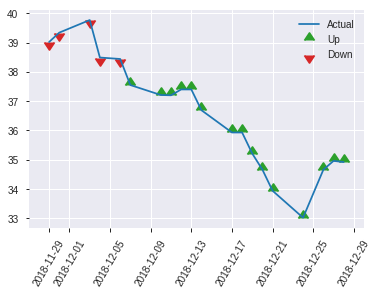


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.508563597229777
RMSE: 0.71313645063885
LogLoss: 11.778674013536717
Mean Per-Class Error: 0.4259295756142425
AUC: 0.5653002233609249
pr_auc: 0.568032833348008
Gini: 0.13060044672184978
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.287078379651795e-52: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       4.28708e-52  0.68617   194
max f2                       4.28708e-52  0.845347  194
max f0point5                 5.98667e-17  0.590842  136
max accuracy                 1.31296e-16  0.57085   134
max precision                0.998647     1         0
max recall                   4.28708e-52  1         194
max specificity              0.998647     1         0
max absolute_mcc             2.55542e-09  0.156199  83
max min_per_class_accuracy   1.20326e-14  0.550847  124
max mean_per_class_accuracy  2.55542e-09  0.57407   83

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  5.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.997909           1.27649   1.27649            0.666667         0.998246      0.666667                    0.998246            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.996727           0         0.765891           0                0.997666      0.4                         0.998014            0               0.0155039                  -100       -23.4109
    3        0.0323887                   0.930508           0.638243  0.718023           0.333333         0.973307      0.375                       0.988749            0.00775194      0.0232558                  -36.1757   -28.1977
    4        0.0404858                   0.580881           1.91473   0.957364           1                0.774035      0.5                         0.945806            0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   0.319237           1.27649   1.03101            0.666667         0.449146      0.538462                    0.831192            0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    0.0234186          1.43605   1.22543            0.75             0.125829      0.64                        0.492618            0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    0.00356386         1.27649   1.24199            0.666667         0.0128738     0.648649                    0.337025            0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    0.000282768        0.883721  1.14884            0.461538         0.00165465    0.6                         0.249829            0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    1.31352e-07        1.19671   1.16436            0.625            5.04263e-05   0.608108                    0.16882             0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     1.27151e-10        0.995659  1.12176            0.52             1.83907e-08   0.585859                    0.126188            0.100775        0.449612                   -0.434109  12.176
    11       0.502024                    1.558e-14          0.995659  1.09634            0.52             1.43068e-11   0.572581                    0.100747            0.100775        0.550388                   -0.434109  9.63366
    12       0.59919                     2.2468e-21         1.03714   1.08674            0.541667         1.42683e-15   0.567568                    0.0844098           0.100775        0.651163                   3.71447    8.67379
    13       0.700405                    1.90499e-31        0.765891  1.04037            0.4              5.45044e-23   0.543353                    0.0722118           0.0775194       0.728682                   -23.4109   4.03728
    14       0.797571                    4.13272e-53        0.877584  1.02054            0.458333         3.17382e-33   0.532995                    0.0634145           0.0852713       0.813953                   -12.2416   2.05407
    15       0.898785                    3.46952e-104       0.842481  1.00049            0.44             6.70663e-55   0.522523                    0.0562732           0.0852713       0.899225                   -15.7519   0.0488861
    16       1                           6.8505e-225        0.995659  1 

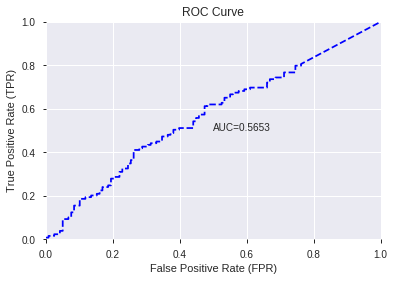

This function is available for GLM models only


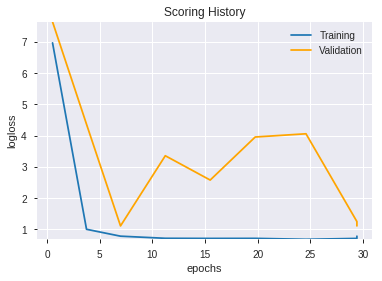

--2019-08-24 20:30:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.82.10
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.82.10|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_200049_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_200049_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TANH',
 'weekday_name',
 'days_in_month',
 'day',
 'SIN',
 'HT_TRENDMODE',
 'COS',
 'month',
 'week',
 'weekday',
 'weekofyear',
 'quarter',
 'aroonup_12',
 'dayofyear',
 'aroonup_30',
 'aroondown_30',
 'is_quarter_end',
 'aroondown_20',
 'DX_14',
 'DX_12',
 'DX_8',
 'ADXR_8',
 'MACDEXT_hist',
 'is_quarter_start',
 'STOCH_slowd',
 'aroondown_8',
 'is_month_end',
 'HT_DCPERIOD',
 'dayofweek',
 'STOCHRSI_fastk',
 'aroonup_14',
 'aroondown_24',
 'SINH',
 'TAN',
 'aroonup_8',
 'HT_PHASOR_quadrature',
 'AROONOSC_24',
 'AROONOSC_8',
 'DX_20',
 'ADXR_14',
 'HT_PHASOR_inphase',
 'AROONOSC_20',
 'VAR_30',
 'ROCR_14',
 'DX_30',
 'SAREXT',
 'AROONOSC_30',
 'aroonup_24',
 'ADX_8',
 'STOCHF_fastk',
 'AROONOSC_14',
 'STOCHRSI_fastd',
 'AROONOSC_12',
 'PLUS_DM_20',
 'CDLGAPSIDESIDEWHITE',
 'STOCH_slowk',
 'STDDEV_20',
 'aroonup_20',
 'aroondown_14',
 'DX_24',
 'STDDEV_30',
 'EXP',
 'ADX_12',
 'STDDEV_8',
 'LINEARREG_SLOPE_8',
 'ROCP_8',
 'ATR_30',
 'ADX_20',
 'is_month_start',
 'STDDEV_24',
 'VAR_1

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_203005_model_1  0.522697  17.625458                   0.5  0.720883  0.519672

variable  relative_importance  scaled_importance    percentage
0               weekday_name         7.101164e-03           1.000000  1.844983e-02
1              days_in_month         6.464107e-03           0.910288  1.679466e-02
2                        EXP         6.304008e-03           0.887743  1.637871e-02
3                       SINH         6.287812e-03           0.885462  1.633662e-02
4                       COSH         6.285311e-03           0.885110  1.633013e-02
..                       ...                  ...                ...           ...
964  BBANDS_lowerband_12_2_3         5.297627e-07           0.000075  1.376398e-06
965  BBANDS_lowerband_24_2_2         5.179554e-07           0.000073  1.345721e-06
966  BBANDS_upperband_14_6_3         4.831476e-07           0.000068  1.255286e-06
967  BBANDS_lowerband_14_5_5         4.805648e-07           0.000068  1.248575e-06
968                  KAMA_20         4.802417e-08           0.000007  1.247736e-07

[969 rows x 4 columns]

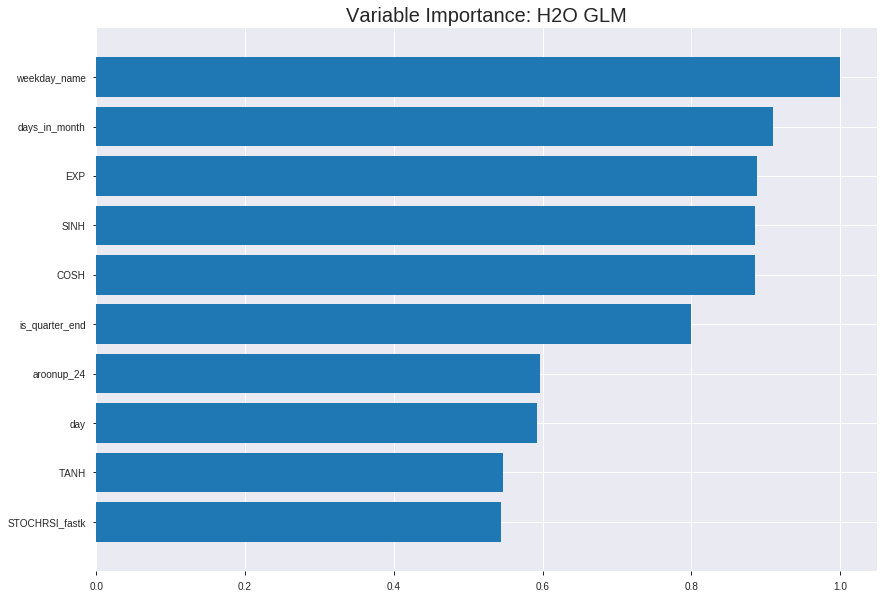

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_203005_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24123105205494147
RMSE: 0.49115277873075447
LogLoss: 0.675455996955622
Null degrees of freedom: 1724
Residual degrees of freedom: 755
Null deviance: 2340.659668736101
Residual deviance: 2330.323189496896
AIC: 4270.323189496896
AUC: 0.5612642802741813
pr_auc: 0.624312732009251
Gini: 0.12252856054836259
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5197625721753903: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    714   0.9986   (714.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  1    1724  0.4139   (714.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519763     0.738844  398
max f2                       0.519763     0.876128  398
max f0point5                 0.574826     0.648366  267
max accuracy                 0.573491     0.593623  274
max precision                0.666036     1         0
max recall                   0.519763     1         398
max specificity              0.666036     1         0
max absolute_mcc             0.577038     0.132252  254
max min_per_class_accuracy   0.584023     0.541259  212
max mean_per_class_accuracy  0.577038     0.563193  254

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.638391           1.2335    1.2335             0.722222         0.649588  0.722222                    0.649588            0.0128713       0.0128713                  23.3498   23.3498
    2        0.0202899                   0.632871           1.00466   1.12235            0.588235         0.635657  0.657143                    0.642821            0.00990099      0.0227723                  0.465929  12.2348
    3        0.0301449                   0.629505           1.00466   1.08387            0.588235         0.631127  0.634615                    0.638998            0.00990099      0.0326733                  0.465929  8.38728
    4        0.04                        0.625228           1.00466   1.06436            0.588235         0.627369  0.623188                    0.636133            0.00990099      0.0425743                  0.465929  6.43564
    5        0.0504348                   0.6226             1.13861   1.07972            0.666667         0.62352   0.632184                    0.633523            0.0118812       0.0544554                  13.8614   7.972
    6        0.10029                     0.611317           1.01284   1.04647            0.593023         0.61619   0.612717                    0.624907            0.050495        0.10495                    1.28367   4.64717
    7        0.150145                    0.604445           1.01284   1.0353             0.593023         0.607509  0.606178                    0.61913             0.050495        0.155446                   1.28367   3.53033
    8        0.2                         0.599639           1.23129   1.08416            0.72093          0.601821  0.634783                    0.614815            0.0613861       0.216832                   23.1292   8.41584
    9        0.30029                     0.592564           1.10571   1.09135            0.647399         0.595916  0.638996                    0.608504            0.110891        0.327723                   10.5706   9.13548
    10       0.4                         0.588286           1.0327    1.07673            0.604651         0.59036   0.630435                    0.603981            0.10297         0.430693                   3.26963   7.67327
    11       0.50029                     0.584279           1.04647   1.07067            0.612717         0.58623   0.626883                    0.600422            0.10495         0.535644                   4.64717   7.06665
    12       0.6                         0.580413           1.05256   1.06766            0.616279         0.582373  0.625121                    0.597423            0.10495         0.640594                   5.25558   6.76568
    13       0.69971                     0.575472           1.08235   1.06975            0.633721         0.577991  0.626346                    0.594654            0.107921        0.748515                   8.23452   6.97499
    14       0.8                         0.570334           0.78979   1.03465            0.462428         0.572926  0.605797                    0.59193             0.0792079       0.827723                   -21.021   3.46535
    15       0.89971                     0.562741           0.834101  1.01243            0.488372         0.567027  0.592784                    0.58917             0.0831683       0.910891                   -16.5899  1.24273
    16       1                           0.519203           0.888514  1                  0.520231         0.552647  0.585507                    0.585507           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38694541114657044
RMSE: 0.6220493639146096
LogLoss: 4.298040456299502
Null degrees of freedom: 492
Residual degrees of freedom: -477
Null deviance: 668.7154569489843
Residual deviance: 9046.176182834904
AIC: 10986.176182834904
AUC: 0.49955051224642105
pr_auc: 0.5905703706507858
Gini: -0.0008989755071578953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.4825610096971248e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.48256e-08  0.73913    399
max f2                       2.48256e-08  0.876289   399
max f0point5                 2.48256e-08  0.639098   399
max accuracy                 2.48256e-08  0.586207   399
max precision                0.604565     0.6875     15
max recall                   2.48256e-08  1          399
max specificity              0.638069     0.995098   0
max absolute_mcc             0.562064     0.0613216  80
max min_per_class_accuracy   0.413551     0.512111   244
max mean_per_class_accuracy  0.562064     0.523068   80

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 30.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.621455           1.02353   1.02353            0.6              0.634771     0.6                         0.634771            0.0103806       0.0103806                  2.35294   2.35294
    2        0.020284                    0.610678           1.02353   1.02353            0.6              0.61488      0.6                         0.624826            0.0103806       0.0207612                  2.35294   2.35294
    3        0.030426                    0.604783           1.36471   1.13725            0.8              0.607173     0.666667                    0.618942            0.0138408       0.0346021                  36.4706   13.7255
    4        0.040568                    0.596343           0.341176  0.938235           0.2              0.602038     0.55                        0.614716            0.00346021      0.0380623                  -65.8824  -6.17647
    5        0.0507099                   0.586513           1.36471   1.02353            0.8              0.588966     0.6                         0.609566            0.0138408       0.0519031                  36.4706   2.35294
    6        0.10142                     0.572462           1.09176   1.05765            0.64             0.577175     0.62                        0.59337             0.0553633       0.107266                   9.17647   5.76471
    7        0.150101                    0.565126           1.06618   1.06041            0.625            0.569144     0.621622                    0.585513            0.0519031       0.15917                    6.61765   6.04134
    8        0.200811                    0.558633           0.955294  1.03387            0.56             0.561231     0.606061                    0.579381            0.0484429       0.207612                   -4.47059  3.38681
    9        0.300203                    0.544271           1.0096    1.02583            0.591837         0.551621     0.601351                    0.57019             0.100346        0.307958                   0.960384  2.58347
    10       0.399594                    0.515849           0.870348  0.98716            0.510204         0.530568     0.57868                     0.560335            0.0865052       0.394464                   -12.9652  -1.28397
    11       0.501014                    0.412285           1.16      1.02215            0.68             0.466753     0.59919                     0.541391            0.117647        0.512111                   16        2.21481
    12       0.600406                    0.115122           0.80072   0.985493           0.469388         0.262316     0.577703                    0.495193            0.0795848       0.591696                   -19.928   -1.45072
    13       0.699797                    0.00882048         0.97479   0.983973           0.571429         0.0556026    0.576812                    0.432758            0.0968858       0.688581                   -2.52101  -1.60273
    14       0.799189                    5.33485e-05        1.11405   1.00015            0.653061         0.00196888   0.586294                    0.379183            0.110727        0.799308                   11.4046   0.0149298
    15       0.89858                     3.19466e-17        1.07923   1.0089             0.632653         1.13335e-05  0.591422                    0.337243            0.107266        0.906574                   7.92317   0.889656
    16       1                           1.25366e-159       0.921176  1                  0.54          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 20:30:08  0.000 sec   2            2.5       970           1.35091           18.3492
    2019-08-24 20:30:10  1.563 sec   4            1.8       970           1.34972           23.6982
    2019-08-24 20:30:11  3.130 sec   6            1.3       970           1.34832           30.339
    2019-08-24 20:30:13  4.692 sec   8            0.97      970           1.34667           38.0809
    2019-08-24 20:30:14  6.262 sec   10           0.71      970           1.34478           46.3161

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5222672064777328)

('F1', 0.6861702127659575)

('auc', 0.5226974116410459)

('logloss', 17.625457612009324)

('mean_per_class_error', 0.47612008934437)

('rmse', 0.7208825561800967)

('mse', 0.5196716598047503)

glm prediction progress: |████████████████████████████████████████████████| 100%


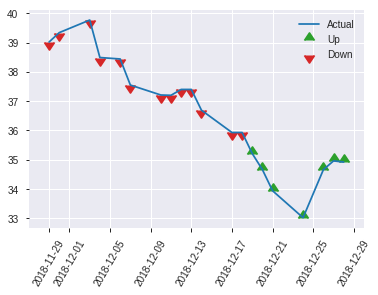


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5196716598047503
RMSE: 0.7208825561800967
LogLoss: 17.625457612009324
Null degrees of freedom: 246
Residual degrees of freedom: -723
Null deviance: 345.9465433426434
Residual deviance: 112766.91560674446
AIC: 114706.91560674446
AUC: 0.5226974116410459
pr_auc: 0.5750744491856398
Gini: 0.04539482328209177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.2232635510111756e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.22326e-49  0.68617    25
max f2                       6.22326e-49  0.845347   25
max f0point5                 6.22326e-49  0.57744    25
max accuracy                 6.22326e-49  0.522267   25
max precision                0.400026     1          0
max recall                   6.22326e-49  1          25
max specificity              0.400026     1          0
max absolute_mcc             2.30108e-35  0.0810485  17
max min_per_class_accuracy   1.00457e-45  0.124031   24
max mean_per_class_accuracy  1.00457e-45  0.52388    24

Gains/Lift Table: Avg response rate: 52.23 %, avg score:  0.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.00358334         1.27649   1.27649            0.666667         0.163384      0.666667                    0.163384            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.000420591        0.957364  1.14884            0.5              0.00199123    0.6                         0.0988272           0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   2.75324e-10        0         0.718023           0                0.00014639    0.375                       0.0618219           0               0.0232558                  -100       -28.1977
    4        0.0404858                   2.10266e-21        1.91473   0.957364           1                1.32756e-10   0.5                         0.0494575           0.0155039       0.0387597                  91.4729    -4.26357
    5        0.0526316                   2.69237e-27        1.27649   1.03101            0.666667         7.22866e-22   0.538462                    0.0380442           0.0155039       0.0542636                  27.6486    3.10078
    6        0.101215                    4.79895e-46        1.43605   1.22543            0.75             4.35222e-30   0.64                        0.019783            0.0697674       0.124031                   43.6047    22.5426
    7        0.149798                    4.83103e-60        1.27649   1.24199            0.666667         1.1513e-47    0.648649                    0.0133669           0.0620155       0.186047                   27.6486    24.1986
    8        0.202429                    7.37942e-73        0.883721  1.14884            0.461538         1.33462e-61   0.6                         0.0098915           0.0465116       0.232558                   -11.6279   14.8837
    9        0.299595                    2.66964e-126       1.19671   1.16436            0.625            3.20602e-76   0.608108                    0.00668345          0.116279        0.348837                   19.6705    16.4362
    10       0.40081                     2.20115e-171       1.07225   1.1411             0.56             2.34534e-128  0.59596                     0.00499571          0.108527        0.457364                   7.22481    14.1101
    11       0.502024                    1.51376e-228       0.995659  1.11178            0.52             5.76671e-174  0.580645                    0.00398851          0.100775        0.55814                    -0.434109  11.1778
    12       1                           0                  0.887313  1                  0.463415         7.44615e-233  0.522267                    0.00200233          0.44186         1                          -11.2687   0

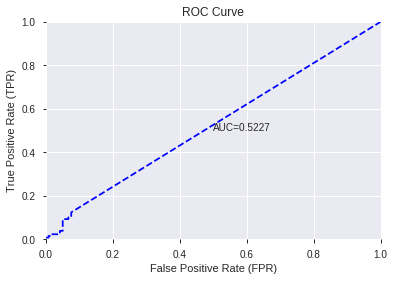

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


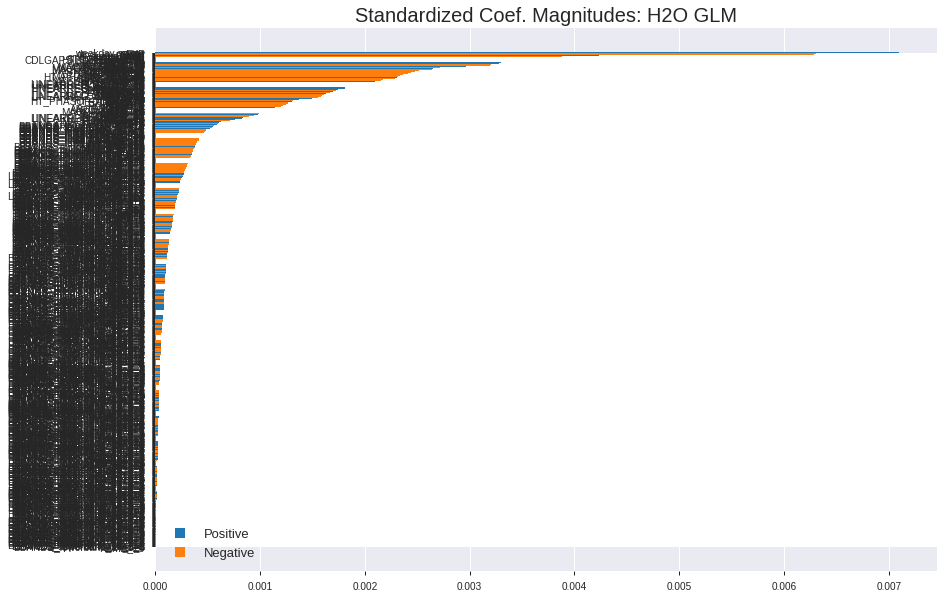

'log_likelihood'
--2019-08-24 20:30:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_203005_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_203005_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['weekday_name',
 'days_in_month',
 'EXP',
 'SINH',
 'COSH',
 'is_quarter_end',
 'aroonup_24',
 'day',
 'TANH',
 'STOCHRSI_fastk',
 'TAN',
 'HT_TRENDMODE',
 'SAREXT',
 'is_quarter_start',
 'CDLGAPSIDESIDEWHITE',
 'MOM_30',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'is_month_end',
 'ROC_30',
 'DX_8',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'VAR_8',
 'AROONOSC_24',
 'MACDFIX_signal_8',
 'MACD_signal',
 'MACDFIX_signal_12',
 'aroondown_30',
 'dayofyear',
 'MOM_14',
 'MACDFIX_signal_14',
 'MACDFIX_8',
 'STOCHRSI_fastd',
 'ADX_24',
 'MACDFIX_12',
 'MACD',
 'TRIX_12',
 'ADX_20',
 'TRIX_14',
 'MACDFIX_14',
 'CCI_24',
 'MACDFIX_signal_20',
 'month',
 'HT_PHASOR_inphase',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MACDFIX_24',
 'MACDFIX_20',
 'week',
 'weekofyear',
 'TRIX_8',
 'MACDFIX_signal_24',
 'PLUS_DM_14',
 'VAR_20',
 'PLUS_DM_12',
 'LINEARREG_ANGLE_20',
 'LINEARREG_SLOPE_20',
 'PLUS_DM_20',
 'CCI_30',
 'STOCHF_fastk',
 'aroonup_30',
 'PLUS_DM_24',
 'LINEARREG_ANGLE_30',
 'LINEARREG_SLOP

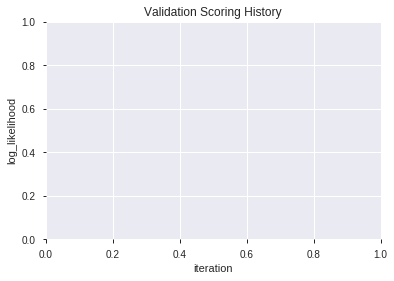

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_203035_model_6  0.516818  0.729165              0.500000  0.515686  0.265932
1  XGBoost_grid_1_AutoML_20190824_203035_model_1  0.505814  0.751809              0.491525  0.525490  0.276140
2  XGBoost_grid_1_AutoML_20190824_203035_model_4  0.490146  0.701989              0.500000  0.504320  0.254339
3  XGBoost_grid_1_AutoML_20190824_203035_model_7  0.489292  0.731457              0.500000  0.517457  0.267761
4  XGBoost_grid_1_AutoML_20190824_203035_model_2  0.488175  0.706816              0.500000  0.506594  0.256637
5               XGBoost_3_AutoML_20190824_203035  0.485416  0.723981              0.491525  0.514504  0.264715
6               XGBoost_1_AutoML_20190824_203035  0.484036  0.726175              0.495763  0.515497  0.265737
7  XGBoost_grid_1_AutoML_20190824_203035_model_5  0.480160  0.751487              0.500000  0.525387  0.276031
8  XGBoost_grid_1_AutoML_20190824_203035_model_3  0.469255  0.771300              0.486565  0.534593  0.285790
9               XGBoost_2_AutoML_20190824_203035  0.458547  0.735462              0.500000  0.519784  0.270175

variable  relative_importance  scaled_importance  percentage
0    HT_PHASOR_quadrature           192.185867           1.000000    0.029371
1                  MOM_30           110.277672           0.573807    0.016853
2                   MOM_8            94.500702           0.491715    0.014442
3                STDDEV_8            88.878609           0.462462    0.013583
4                  MOM_14            84.570770           0.440047    0.012924
..                    ...                  ...                ...         ...
265                ATR_14             3.168373           0.016486    0.000484
266                  mama             3.001508           0.015618    0.000459
267    LINEARREG_ANGLE_12             2.797572           0.014557    0.000428
268               DEMA_12             2.062745           0.010733    0.000315
269     LINEARREG_SLOPE_8             1.300416           0.006766    0.000199

[270 rows x 4 columns]

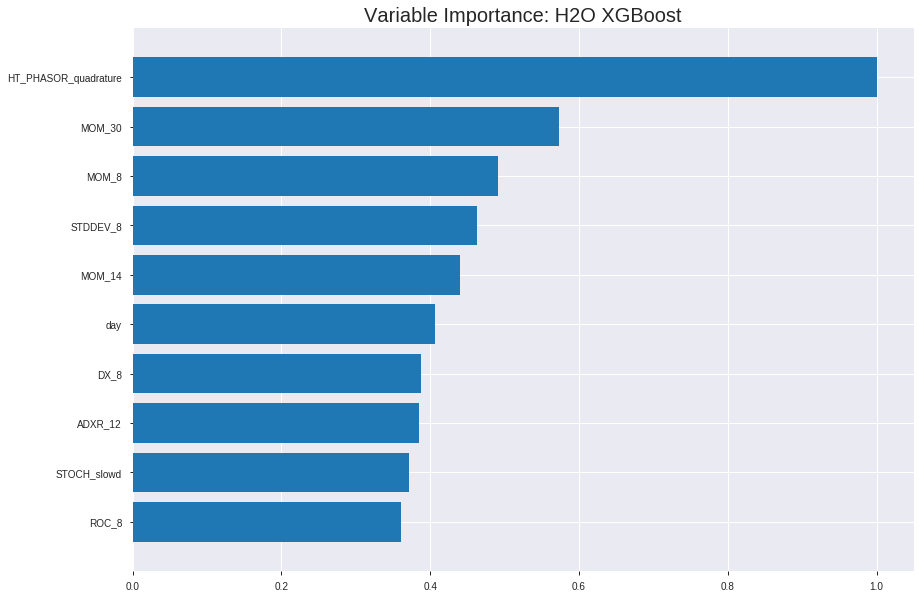

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_203035_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17910790911632923
RMSE: 0.4232114236600062
LogLoss: 0.545745057567497
Mean Per-Class Error: 0.13114311431143122
AUC: 0.9426573426573427
pr_auc: 0.9560374909536655
Gini: 0.8853146853146854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5563758730888366: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      570  145   0.2028   (145.0/715.0)
1      75   935   0.0743   (75.0/1010.0)
Total  645  1080  0.1275   (220.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.556376     0.894737  213
max f2                       0.513091     0.931869  253
max f0point5                 0.590301     0.905116  177
max accuracy                 0.568679     0.873043  200
max precision                0.805167     1         0
max recall                   0.397806     1         347
max specificity              0.805167     1         0
max absolute_mcc             0.568679     0.737998  200
max min_per_class_accuracy   0.577674     0.865734  192
max mean_per_class_accuracy  0.573731     0.868857  196

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.94 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.757745           1.70792     1.70792            1                0.773523  1                           0.773523            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.748774           1.70792     1.70792            1                0.753925  1                           0.764004            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.739691           1.70792     1.70792            1                0.743711  1                           0.75737             0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.729715           1.70792     1.70792            1                0.734496  1                           0.751734            0.0168317       0.0683168                  70.7921   70.7921
    5        0.0504348                   0.721995           1.70792     1.70792            1                0.726654  1                           0.746545            0.0178218       0.0861386                  70.7921   70.7921
    6        0.10029                     0.701415           1.68806     1.69805            0.988372         0.71143   0.99422                     0.729089            0.0841584       0.170297                   68.8061   69.8048
    7        0.150145                    0.683269           1.68806     1.69473            0.988372         0.692451  0.992278                    0.716924            0.0841584       0.254455                   68.8061   69.4732
    8        0.2                         0.669208           1.68806     1.69307            0.988372         0.675603  0.991304                    0.706623            0.0841584       0.338614                   68.8061   69.3069
    9        0.30029                     0.644226           1.61907     1.66836            0.947977         0.657149  0.976834                    0.6901              0.162376        0.50099                    61.9069   66.8355
    10       0.4                         0.618619           1.57883     1.64604            0.924419         0.631175  0.963768                    0.675411            0.157426        0.658416                   57.8834   64.604
    11       0.50029                     0.593815           1.41175     1.59907            0.82659          0.60604   0.936269                    0.661505            0.141584        0.8                        41.175    59.9073
    12       0.6                         0.56534            1.00291     1.5                0.587209         0.580609  0.878261                    0.648062            0.1             0.9                        0.290698  50
    13       0.69971                     0.529983           0.635505    1.37681            0.372093         0.547742  0.806131                    0.633766            0.0633663       0.963366                   -36.4495  37.6808
    14       0.8                         0.49403            0.266554    1.23762            0.156069         0.512157  0.724638                    0.618521            0.0267327       0.990099                   -73.3446  23.7624
    15       0.89971                     0.43931            0.0893679   1.11037            0.0523256        0.469716  0.650129                    0.602029            0.00891089      0.99901                    -91.0632  11.0369
    16       1                           0.216904           0.00987237  1                  0.00578035       0.376702  0.585507       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2783190439020079
RMSE: 0.5275595169286664
LogLoss: 0.7527231915663345
Mean Per-Class Error: 0.47563437139561704
AUC: 0.5038503290589592
pr_auc: 0.5879052608571604
Gini: 0.007700658117918424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25682568550109863: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   191  0.9363   (191.0/204.0)
1      5    284  0.0173   (5.0/289.0)
Total  18   475  0.3976   (196.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.256826     0.743455  382
max f2                       0.226815     0.877886  396
max f0point5                 0.256826     0.648698  382
max accuracy                 0.256826     0.602434  382
max precision                0.700396     1         0
max recall                   0.226815     1         396
max specificity              0.700396     1         0
max absolute_mcc             0.256826     0.121907  382
max min_per_class_accuracy   0.411729     0.484429  205
max mean_per_class_accuracy  0.268834     0.524366  373

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 42.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.672897           1.36471   1.36471            0.8              0.686737  0.8                         0.686737            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.642549           0.682353  1.02353            0.4              0.666587  0.6                         0.676662            0.00692042      0.0207612                  -31.7647  2.35294
    3        0.030426                    0.623471           0.341176  0.796078           0.2              0.631545  0.466667                    0.661623            0.00346021      0.0242215                  -65.8824  -20.3922
    4        0.040568                    0.616784           0.682353  0.767647           0.4              0.620512  0.45                        0.651345            0.00692042      0.0311419                  -31.7647  -23.2353
    5        0.0507099                   0.603832           1.02353   0.818824           0.6              0.609767  0.48                        0.64303             0.0103806       0.0415225                  2.35294   -18.1176
    6        0.10142                     0.560487           1.22824   1.02353            0.72             0.580948  0.6                         0.611989            0.0622837       0.103806                   22.8235   2.35294
    7        0.150101                    0.53262            1.06618   1.03736            0.625            0.542856  0.608108                    0.589567            0.0519031       0.155709                   6.61765   3.73609
    8        0.200811                    0.51242            0.955294  1.01664            0.56             0.523278  0.59596                     0.572828            0.0484429       0.204152                   -4.47059  1.6637
    9        0.300203                    0.470052           1.0096    1.01431            0.591837         0.490638  0.594595                    0.545616            0.100346        0.304498                   0.960384  1.43084
    10       0.399594                    0.438414           0.905162  0.98716            0.530612         0.452535  0.57868                     0.522464            0.0899654       0.394464                   -9.48379  -1.28397
    11       0.501014                    0.410634           0.921176  0.973803           0.54             0.422732  0.57085                     0.502276            0.0934256       0.487889                   -7.88235  -2.61967
    12       0.600406                    0.386094           0.939976  0.968203           0.55102          0.397791  0.567568                    0.484979            0.0934256       0.581315                   -6.0024   -3.17965
    13       0.699797                    0.360275           1.21849   1.00375            0.714286         0.370613  0.588406                    0.468736            0.121107        0.702422                   21.8487   0.375107
    14       0.799189                    0.338844           1.04442   1.00881            0.612245         0.349427  0.591371                    0.453898            0.103806        0.806228                   4.44178   0.88086
    15       0.89858                     0.297864           1.04442   1.01275            0.612245         0.318655  0.593679                    0.438939            0.103806        0.910035                   4.44178   1.27473
    16       1                           0.182769           0.887059  1                  0.52             0.264488  0.586207                    0.421246   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:31:06  18.178 sec  0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 20:31:06  18.639 sec  5                  0.487257         0.667907            0.730405        0.776545           1.62252          0.31942                          0.503956           0.701113              0.495488          0.572749             0.284314           0.413793
    2019-08-24 20:31:07  18.783 sec  10                 0.477194         0.648275            0.800745        0.835352           1.70792          0.257391                         0.509131           0.711716              0.478263          0.574732             1.42157            0.413793
    2019-08-24 20:31:07  18.935 sec  15                 0.468011         0.630502            0.842677        0.874746           1.70792          0.224928                         0.508457           0.710408              0.501018          0.577479             1.36471            0.409736
    2019-08-24 20:31:07  19.083 sec  20                 0.459478         0.614088            0.872731        0.901546           1.70792          0.201159                         0.508985           0.711471              0.504927          0.57591              1.36471            0.397566
    2019-08-24 20:31:07  19.236 sec  25                 0.452637         0.601023            0.891958        0.91673            1.70792          0.177971                         0.510478           0.714596              0.500221          0.572518             1.02353            0.391481
    2019-08-24 20:31:07  19.375 sec  30                 0.446358         0.589038            0.906729        0.929133           1.70792          0.164058                         0.519091           0.733003              0.498355          0.576992             1.02353            0.401623
    2019-08-24 20:31:07  19.520 sec  35                 0.440428         0.577841            0.916588        0.933753           1.70792          0.16                             0.52262            0.740965              0.501136          0.577623             1.02353            0.399594
    2019-08-24 20:31:07  19.668 sec  40                 0.434798         0.567197            0.926967        0.943906           1.70792          0.14029                          0.523933           0.744145              0.501018          0.583705             1.36471            0.399594
    2019-08-24 20:31:08  19.821 sec  45                 0.429078         0.55656             0.935328        0.950191           1.70792          0.132754                         0.530604           0.759766              0.50586           0.587908             1.02353            0.399594
    2019-08-24 20:31:08  19.975 sec  50                 0.423211         0.545745            0.942657        0.956037           1.70792          0.127536                         0.52756            0.752723              0.50385           0.587905             1.36471            0.397566

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_quadrature  192.1858673095703      1.0                   0.029370657198689854
MOM_30                110.27767181396484     0.5738073946734653    0.016853100287027682
MOM_8                 94.50070190429688      0.4917151465257144    0.014441997008010311
STDDEV_8              88.87860870361328      0.46246173013569647   0.01358280494332856
MOM_14                84.57077026367188      0.44004677059550096   0.012924462850550973
---                   ---                    ---                   ---
ATR_14                3.168372631072998      0.016485981385766662  0.00048420410786533457
mama                  3.0015082359313965     0.015617736506590305  0.00045870318515452786
LINEARREG_ANGLE_12    2.797572135925293      0.014556596565027348  0.0004275368076910445
DEMA_12               2.0627453327178955     0.010733075025726289  0.0003152374672684261
LINEARREG_SLOPE_8     1.300416111946106      0.006766450260629279  0.00019873509105692815


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6861702127659575)

('auc', 0.5168177637629747)

('logloss', 0.7291650697793686)

('mean_per_class_error', 0.4457692813033767)

('rmse', 0.5156862909010935)

('mse', 0.2659323506233272)

xgboost prediction progress: |████████████████████████████████████████████| 100%


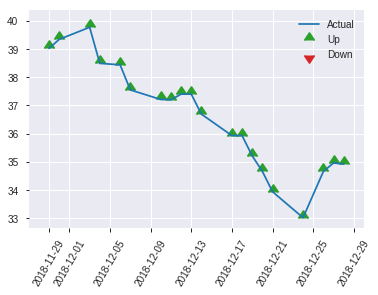


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2659323506233272
RMSE: 0.5156862909010935
LogLoss: 0.7291650697793686
Mean Per-Class Error: 0.4457692813033767
AUC: 0.5168177637629747
pr_auc: 0.5499803573231689
Gini: 0.03363552752594945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18170076608657837: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.181701     0.68617   246
max f2                       0.181701     0.845347  246
max f0point5                 0.181701     0.57744   246
max accuracy                 0.454331     0.550607  103
max precision                0.607127     1         0
max recall                   0.181701     1         246
max specificity              0.607127     1         0
max absolute_mcc             0.254698     0.129283  232
max min_per_class_accuracy   0.439075     0.51938   119
max mean_per_class_accuracy  0.454331     0.554231  103

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 42.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.585108           1.91473   1.91473            1                0.600401  1                           0.600401            0.0232558       0.0232558                  91.4729    91.4729
    2        0.0202429                   0.580622           0.957364  1.53178            0.5              0.582312  0.8                         0.593165            0.00775194      0.0310078                  -4.26357   53.1783
    3        0.0323887                   0.576544           0         0.957364           0                0.578166  0.5                         0.58754             0               0.0310078                  -100       -4.26357
    4        0.0404858                   0.560396           0         0.765891           0                0.575285  0.4                         0.585089            0               0.0310078                  -100       -23.4109
    5        0.0526316                   0.555874           1.27649   0.883721           0.666667         0.557227  0.461538                    0.57866             0.0155039       0.0465116                  27.6486    -11.6279
    6        0.101215                    0.529928           1.59561   1.22543            0.833333         0.539915  0.64                        0.560062            0.0775194       0.124031                   59.5607    22.5426
    7        0.149798                    0.510775           0.797804  1.08674            0.416667         0.516928  0.567568                    0.546073            0.0387597       0.162791                   -20.2196   8.67379
    8        0.202429                    0.501514           1.17829   1.11054            0.615385         0.506611  0.58                        0.535812            0.0620155       0.224806                   17.8295    11.0543
    9        0.299595                    0.475845           1.11693   1.11261            0.583333         0.488793  0.581081                    0.520563            0.108527        0.333333                   11.6925    11.2613
    10       0.40081                     0.45764            1.07225   1.10242            0.56             0.4669    0.575758                    0.507012            0.108527        0.44186                    7.22481    10.242
    11       0.502024                    0.434548           0.765891  1.03457            0.4              0.447096  0.540323                    0.494932            0.0775194       0.51938                    -23.4109   3.45711
    12       0.59919                     0.420697           0.718023  0.983239           0.375            0.427434  0.513514                    0.483986            0.0697674       0.589147                   -28.1977   -1.67609
    13       0.700405                    0.404073           1.14884   1.00717            0.6              0.4142    0.526012                    0.473902            0.116279        0.705426                   14.8837    0.716942
    14       0.797571                    0.356228           0.797804  0.981663           0.416667         0.383459  0.51269                     0.462883            0.0775194       0.782946                   -20.2196   -1.83371
    15       0.898785                    0.287621           0.995659  0.983239           0.52             0.326071  0.513514                    0.447476            0.100775        0.883721                   -0.434109  -1.67609
    16       1                           0.181701           1.14884   1                  0.6              0.25303   0.522267              

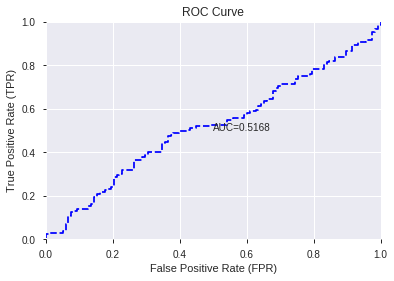

This function is available for GLM models only


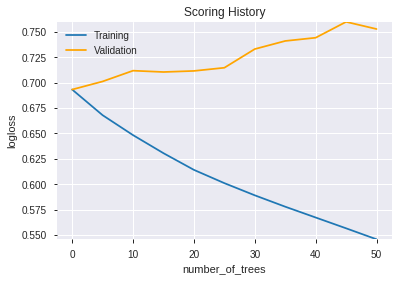

--2019-08-24 20:31:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_203035_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_203035_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_quadrature',
 'MOM_30',
 'MOM_8',
 'STDDEV_8',
 'MOM_14',
 'day',
 'DX_8',
 'ADXR_12',
 'STOCH_slowd',
 'ROC_8',
 'weekday_name',
 'STOCHRSI_fastd',
 'SIN',
 'ADX_24',
 'MACDEXT_hist',
 'TAN',
 'HT_DCPERIOD',
 'NATR_14',
 'MACDFIX_signal_24',
 'LINEARREG_ANGLE_8',
 'PLUS_DM_30',
 'MINUS_DM_30',
 'SAREXT',
 'HT_PHASOR_inphase',
 'MACDEXT_signal',
 'ADX_12',
 'COS',
 'LINEARREG_ANGLE_14',
 'STDDEV_14',
 'NATR_8',
 'AROONOSC_12',
 'CMO_8',
 'ROC_14',
 'STDDEV_20',
 'MINUS_DM_24',
 'dayofyear',
 'LINEARREG_20',
 'dayofweek',
 'MACDFIX_8',
 'STOCHRSI_fastk',
 'ROC_12',
 'ADX_20',
 'TRANGE',
 'DX_30',
 'PLUS_DM_8',
 'CCI_8',
 'PPO',
 'MACDFIX_hist_24',
 'ROC_20',
 'MOM_12',
 'LINEARREG_ANGLE_30',
 'MOM_24',
 'DX_12',
 'MACDFIX_hist_20',
 'CCI_12',
 'CCI_14',
 'PLUS_DM_12',
 'AROONOSC_24',
 'ULTOSC',
 'MACDFIX_hist_8',
 'ADXR_14',
 'AdjClose',
 'ADX_14',
 'aroondown_24',
 'CCI_30',
 'PLUS_DM_24',
 'DX_14',
 'NATR_30',
 'WILLR_30',
 'MACDFIX_hist_14',
 'TRIX_12',
 'ROC_24',
 'AROON

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

320

['BBANDS_lowerband_12_2_3',
 'BBANDS_upperband_12_2_4',
 'BBANDS_middleband_12_2_4',
 'BBANDS_lowerband_12_2_4',
 'BBANDS_upperband_12_2_5',
 'BBANDS_middleband_12_2_5',
 'BBANDS_lowerband_12_2_5',
 'MA_12_3',
 'MAVP_12_3',
 'BBANDS_upperband_12_3_2',
 'BBANDS_middleband_12_3_2',
 'BBANDS_lowerband_12_3_2',
 'BBANDS_upperband_12_3_3',
 'BBANDS_middleband_12_3_3',
 'BBANDS_lowerband_12_3_3',
 'BBANDS_upperband_12_3_4',
 'BBANDS_middleband_12_3_4',
 'BBANDS_lowerband_12_3_4',
 'BBANDS_upperband_12_3_5',
 'BBANDS_middleband_12_3_5',
 'BBANDS_lowerband_12_3_5',
 'MA_12_4',
 'MAVP_12_4',
 'BBANDS_upperband_12_4_2',
 'BBANDS_middleband_12_4_2',
 'BBANDS_lowerband_12_4_2',
 'BBANDS_upperband_12_4_3',
 'BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperba

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_203222_model_4  0.515570  0.729578              0.500000  0.513414  0.263594
1  DeepLearning_grid_1_AutoML_20190824_203222_model_1  0.515372  1.871699              0.486927  0.648859  0.421018
2  DeepLearning_grid_1_AutoML_20190824_203222_model_2  0.512679  0.734121              0.491525  0.516723  0.267002
3               DeepLearning_1_AutoML_20190824_203222  0.511858  0.707086              0.500000  0.506460  0.256502
4  DeepLearning_grid_1_AutoML_20190824_203222_model_9  0.500854  0.699243              0.500000  0.502982  0.252991
5  DeepLearning_grid_1_AutoML_20190824_203222_model_8  0.500000  0.705043              0.500000  0.505760  0.255793
6  DeepLearning_grid_1_AutoML_20190824_203222_model_7  0.499080  0.706757              0.500000  0.506500  0.256543
7  DeepLearning_grid_1_AutoML_20190824_203222_model_5  0.497569  0.732100              0.495763  0.517872  0.268192
8  DeepLearning_grid_1_AutoML_20190824_203222_model_3  0.487912  2.202651              0.491525  0.671782  0.451291
9  DeepLearning_grid_1_AutoML_20190824_203222_model_6  0.486204  0.709304              0.500000  0.507759  0.257819

variable  relative_importance  scaled_importance  percentage
0        HT_PHASOR_quadrature             1.000000           1.000000    0.004610
1                aroondown_12             0.935889           0.935889    0.004314
2                 HT_DCPERIOD             0.888205           0.888205    0.004094
3                      TRANGE             0.872732           0.872732    0.004023
4                      ADXR_8             0.864095           0.864095    0.003983
..                        ...                  ...                ...         ...
315   BBANDS_upperband_14_3_2             0.617778           0.617778    0.002848
316  BBANDS_middleband_14_2_5             0.614279           0.614279    0.002832
317   BBANDS_lowerband_14_4_5             0.612478           0.612478    0.002823
318                 MAVP_14_5             0.611714           0.611714    0.002820
319  BBANDS_middleband_14_5_5             0.611073           0.611073    0.002817

[320 rows x 4 columns]

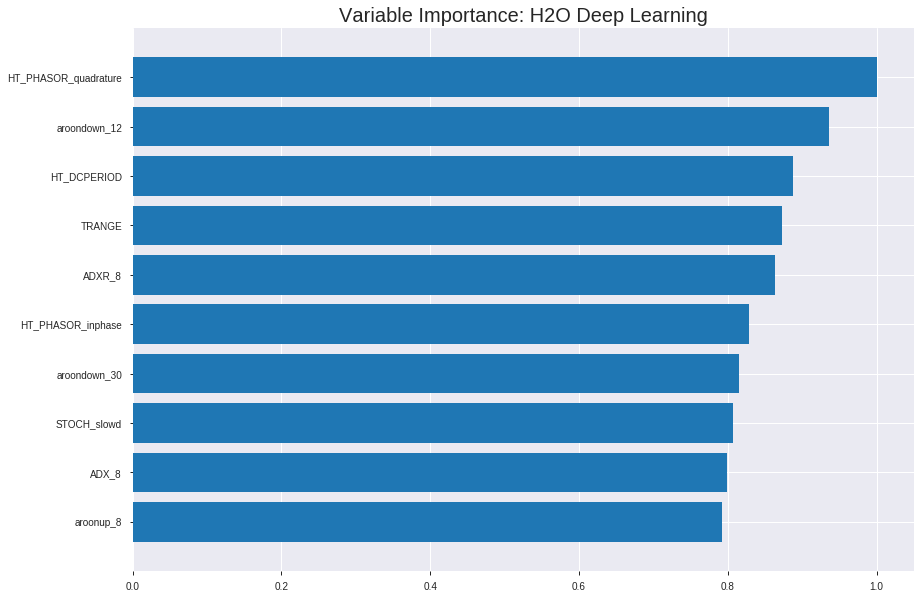

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_203222_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2013761811060352
RMSE: 0.448749575048306
LogLoss: 0.581885584620386
Mean Per-Class Error: 0.3353977705462854
AUC: 0.7334958111195734
pr_auc: 0.7975451664722868
Gini: 0.4669916222391468
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38361338240270654: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      182  533   0.7455   (533.0/715.0)
1      42   968   0.0416   (42.0/1010.0)
Total  224  1501  0.3333   (575.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383613     0.771008  307
max f2                       0.289162     0.886769  342
max f0point5                 0.620223     0.719955  181
max accuracy                 0.482762     0.678261  263
max precision                0.994259     1         0
max recall                   0.213423     1         365
max specificity              0.994259     1         0
max absolute_mcc             0.648389     0.326076  166
max min_per_class_accuracy   0.604793     0.653465  189
max mean_per_class_accuracy  0.648389     0.664602  166

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 61.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.979587           1.70792   1.70792            1                0.98676   1                           0.98676             0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.963577           1.70792   1.70792            1                0.972441  1                           0.979805            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.955137           1.70792   1.70792            1                0.959845  1                           0.97328             0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.945734           1.70792   1.70792            1                0.949746  1                           0.967481            0.0168317       0.0683168                  70.7921   70.7921
    5        0.0504348                   0.935205           1.51815   1.66866            0.888889         0.939887  0.977011                    0.961772            0.0158416       0.0841584                  51.8152   66.8658
    6        0.10029                     0.886835           1.54904   1.6092             0.906977         0.910411  0.942197                    0.93624             0.0772277       0.161386                   54.9044   60.9197
    7        0.150145                    0.846815           1.41003   1.54306            0.825581         0.867699  0.903475                    0.913481            0.070297        0.231683                   41.0028   54.3064
    8        0.2                         0.804826           1.35045   1.49505            0.790698         0.823293  0.875362                    0.891               0.0673267       0.29901                    35.0449   49.505
    9        0.30029                     0.732879           1.18468   1.39139            0.693642         0.768296  0.814672                    0.850019            0.118812        0.417822                   18.4685   39.1395
    10       0.4                         0.674074           1.12206   1.32426            0.656977         0.70406   0.775362                    0.813635            0.111881        0.529703                   12.2064   32.4257
    11       0.50029                     0.61595            1.04647   1.26857            0.612717         0.644839  0.742758                    0.779798            0.10495         0.634653                   4.64717   26.8572
    12       0.6                         0.565684           0.88375   1.20462            0.517442         0.591862  0.705314                    0.748566            0.0881188       0.722772                   -11.625   20.462
    13       0.69971                     0.517245           0.923469  1.16456            0.540698         0.540654  0.681856                    0.718938            0.0920792       0.814851                   -7.65312  16.4556
    14       0.8                         0.450543           0.898386  1.13119            0.526012         0.487064  0.662319                    0.68987             0.090099        0.90495                    -10.1614  13.1188
    15       0.89971                     0.350067           0.685154  1.08176            0.401163         0.403681  0.633376                    0.658153            0.0683168       0.973267                   -31.4846  8.17565
    16       1                           0.00555456         0.266554  1                  0.156069         0.23667   0.585507                    0.615882           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25524924192317294
RMSE: 0.5052219729219751
LogLoss: 0.7079697717885783
Mean Per-Class Error: 0.4641003460207612
AUC: 0.49584435850464753
pr_auc: 0.5586864266603617
Gini: -0.008311282990704938
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4093096391536018: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    203  0.9951   (203.0/204.0)
1      0    289  0        (0.0/289.0)
Total  1    492  0.4118   (203.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40931      0.740077  398
max f2                       0.40931      0.87682   398
max f0point5                 0.420293     0.642697  390
max accuracy                 0.420293     0.592292  390
max precision                0.511341     0.610951  279
max recall                   0.40931      1         398
max specificity              0.843755     0.995098  0
max absolute_mcc             0.79219      0.134547  11
max min_per_class_accuracy   0.567253     0.490196  204
max mean_per_class_accuracy  0.511341     0.5359    279

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 57.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.813276           0.682353  0.682353           0.4              0.834199  0.4                         0.834199            0.00692042      0.00692042                 -31.7647  -31.7647
    2        0.020284                    0.797472           0         0.341176           0                0.805727  0.2                         0.819963            0               0.00692042                 -100      -65.8824
    3        0.030426                    0.786092           0.682353  0.454902           0.4              0.791881  0.266667                    0.810602            0.00692042      0.0138408                  -31.7647  -54.5098
    4        0.040568                    0.767528           1.02353   0.597059           0.6              0.777535  0.35                        0.802336            0.0103806       0.0242215                  2.35294   -40.2941
    5        0.0507099                   0.759826           1.02353   0.682353           0.6              0.763864  0.4                         0.794641            0.0103806       0.0346021                  2.35294   -31.7647
    6        0.10142                     0.722531           0.955294  0.818824           0.56             0.741149  0.48                        0.767895            0.0484429       0.083045                   -4.47059  -18.1176
    7        0.150101                    0.691098           0.781863  0.806836           0.458333         0.70677   0.472973                    0.748071            0.0380623       0.121107                   -21.8137  -19.3164
    8        0.200811                    0.671546           1.16      0.896019           0.68             0.682217  0.525253                    0.731441            0.0588235       0.179931                   16        -10.3981
    9        0.300203                    0.638992           1.07923   0.956677           0.632653         0.653803  0.560811                    0.705737            0.107266        0.287197                   7.92317   -4.33227
    10       0.399594                    0.595246           1.18367   1.01314            0.693878         0.620282  0.593909                    0.684481            0.117647        0.404844                   18.3673   1.31383
    11       0.501014                    0.566493           0.887059  0.987616           0.52             0.580578  0.578947                    0.663448            0.0899654       0.49481                    -11.2941  -1.23839
    12       0.600406                    0.537727           0.97479   0.985493           0.571429         0.553573  0.577703                    0.645259            0.0968858       0.591696                   -2.52101  -1.45072
    13       0.699797                    0.512521           1.35774   1.03836            0.795918         0.525349  0.608696                    0.628229            0.134948        0.726644                   35.7743   3.83632
    14       0.799189                    0.486622           0.835534  1.01314            0.489796         0.499517  0.593909                    0.612221            0.083045        0.809689                   -16.4466  1.31383
    15       0.89858                     0.450877           1.0096    1.01275            0.591837         0.468602  0.593679                    0.596336            0.100346        0.910035                   0.960384  1.27473
    16       1                           0.398008           0.887059  1                  0.52             0.432352  0.586207                    0.5797


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:35:08  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 20:35:13  6.625 sec         278 obs/sec       0.864348  1             1491       0.641142         3.59086             -0.693788      0.530991        0.577838           0.948845         0.409275                         0.643208           5.06477               -0.705564        0.516902          0.59526              1.02353            0.411765
    2019-08-24 20:35:28  22.004 sec        303 obs/sec       3.40812   4             5879       0.597824         1.76692             -0.472641      0.548935        0.583412           1.51815          0.405797                         0.594544           1.58638               -0.45725         0.561936          0.600589             1.36471            0.37931
    2019-08-24 20:35:45  38.486 sec        340 obs/sec       6.82493   8             11773      0.525867         0.798754            -0.139469      0.582485        0.657139           1.61304          0.402319                         0.519843           0.770779              -0.114064        0.542964          0.603822             1.02353            0.40568
    2019-08-24 20:35:59  53.097 sec        368 obs/sec       10.2116   12            17615      0.544093         0.98957             -0.219825      0.568133        0.620977           1.42327          0.401739                         0.628459           1.87021               -0.628244        0.537604          0.629337             1.36471            0.407708
    2019-08-24 20:36:15  1 min  9.152 sec  398 obs/sec       14.4551   17            24935      0.513303         0.770721            -0.0856717     0.597276        0.645298           1.2335           0.387826                         0.553528           0.935296              -0.263119        0.553752          0.626796             1.36471            0.393509
    2019-08-24 20:36:30  1 min 24.212 sec  423 obs/sec       18.7003   22            32258      0.507954         0.766966            -0.0631607     0.637041        0.683641           1.61304          0.354783                         0.583875           1.08024               -0.40542         0.526096          0.610139             1.02353            0.413793
    2019-08-24 20:36:45  1 min 38.642 sec  443 obs/sec       22.9774   27            39636      0.486445         0.68681             0.0249707      0.652337        0.692632           1.61304          0.355362                         0.543594           0.852868              -0.218189        0.562894          0.629161             1.36471            0.395538
    2019-08-24 20:36:59  1 min 52.699 sec  460 obs/sec       27.2516   32            47009      0.472012         0.642893            0.081971       0.694807        0.753834           1.70792          0.343768                         0.522977           0.76498               -0.127537        0.541522          0.62659              1.70588            0.40568
    2019-08-24 20:37:12  2

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_PHASOR_quadrature      1.0                    1.0                  0.004609797931627031
aroondown_12              0.9358885288238525     0.9358885288238525   0.004314257004405661
HT_DCPERIOD               0.8882054090499878     0.8882054090499878   0.004094447457498575
TRANGE                    0.872731626033783      0.872731626033783    0.0040231164445560285
ADXR_8                    0.8640954494476318     0.8640954494476318   0.003983305415592023
---                       ---                    ---                  ---
BBANDS_upperband_14_3_2   0.617778480052948      0.617778480052948    0.002847833959551771
BBANDS_middleband_14_2_5  0.6142789721488953     0.6142789721488953   0.002831701935253956
BBANDS_lowerband_14_4_5   0.6124784350395203     0.6124784350395203   0.0028234018230113415
MAVP_14_5                 0.6117141842842102     0.6117141842842102   0.002819878781460269
BBANDS_middleband_14_5_5  0.6110727787017822     0.6110727787017822   0.0028169220313330585


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5425101214574899)

('F1', 0.6861702127659575)

('auc', 0.5155695703586913)

('logloss', 0.7295783839280029)

('mean_per_class_error', 0.45631323085008546)

('rmse', 0.5134142506051047)

('mse', 0.2635941927244012)

deeplearning prediction progress: |███████████████████████████████████████| 100%


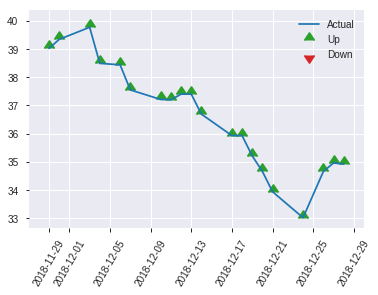


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2635941927244012
RMSE: 0.5134142506051047
LogLoss: 0.7295783839280029
Mean Per-Class Error: 0.45631323085008546
AUC: 0.5155695703586913
pr_auc: 0.5259881196632711
Gini: 0.031139140717382663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4412148883954927: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    118  1        (118.0/118.0)
1      0    129  0        (0.0/129.0)
Total  0    247  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.441215     0.68617    246
max f2                       0.441215     0.845347   246
max f0point5                 0.441215     0.57744    246
max accuracy                 0.574869     0.54251    157
max precision                0.686617     0.606061   32
max recall                   0.441215     1          246
max specificity              0.96496      0.991525   0
max absolute_mcc             0.630279     0.0897082  94
max min_per_class_accuracy   0.608314     0.511628   122
max mean_per_class_accuracy  0.630279     0.543687   94

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 60.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.880883           0.638243  0.638243           0.333333         0.929051  0.333333                    0.929051            0.00775194      0.00775194                 -36.1757   -36.1757
    2        0.0202429                   0.788926           0.957364  0.765891           0.5              0.827529  0.4                         0.888442            0.00775194      0.0155039                  -4.26357   -23.4109
    3        0.0323887                   0.746841           0.638243  0.718023           0.333333         0.76388   0.375                       0.841731            0.00775194      0.0232558                  -36.1757   -28.1977
    4        0.0404858                   0.737651           0.957364  0.765891           0.5              0.740318  0.4                         0.821449            0.00775194      0.0310078                  -4.26357   -23.4109
    5        0.0526316                   0.730318           0.638243  0.736434           0.333333         0.73498   0.384615                    0.801494            0.00775194      0.0387597                  -36.1757   -26.3566
    6        0.101215                    0.695344           1.11693   0.91907            0.583333         0.710783  0.48                        0.757953            0.0542636       0.0930233                  11.6925    -8.09302
    7        0.149798                    0.679631           1.27649   1.03499            0.666667         0.687727  0.540541                    0.735177            0.0620155       0.155039                   27.6486    3.49885
    8        0.202429                    0.668782           1.17829   1.07225            0.615385         0.6739    0.56                        0.719245            0.0620155       0.217054                   17.8295    7.22481
    9        0.299595                    0.646492           1.19671   1.11261            0.625            0.658012  0.581081                    0.699386            0.116279        0.333333                   19.6705    11.2613
    10       0.40081                     0.623617           0.995659  1.08308            0.52             0.635607  0.565657                    0.68328             0.100775        0.434109                   -0.434109  8.30789
    11       0.502024                    0.608249           0.765891  1.01913            0.4              0.616309  0.532258                    0.669778            0.0775194       0.511628                   -23.4109   1.91298
    12       0.59919                     0.581668           1.03714   1.02205            0.541667         0.596627  0.533784                    0.657915            0.100775        0.612403                   3.71447    2.20511
    13       0.700405                    0.560347           1.14884   1.04037            0.6              0.572507  0.543353                    0.645573            0.116279        0.728682                   14.8837    4.03728
    14       0.797571                    0.535735           0.638243  0.991382           0.333333         0.547013  0.517766                    0.633566            0.0620155       0.790698                   -36.1757   -0.861764
    15       0.898785                    0.507511           0.91907   0.983239           0.48             0.523244  0.513514                    0.621142            0.0930233       0.883721                   -8.09302   -1.67609
    16       1                           0.441215           1.14884   1                  0.6              0.484829  0.522267           

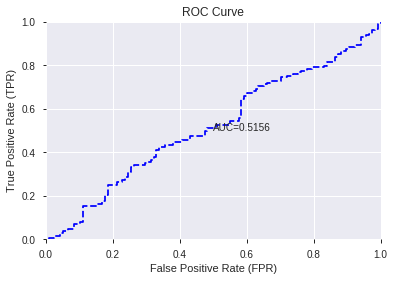

This function is available for GLM models only


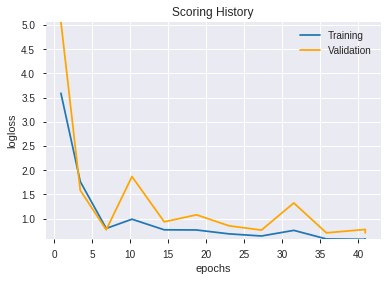

--2019-08-24 20:46:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_203222_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_203222_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_PHASOR_quadrature',
 'aroondown_12',
 'HT_DCPERIOD',
 'TRANGE',
 'ADXR_8',
 'HT_PHASOR_inphase',
 'aroondown_30',
 'STOCH_slowd',
 'ADX_8',
 'aroonup_8',
 'ADXR_12',
 'STOCHRSI_fastd',
 'aroonup_14',
 'STOCHF_fastk',
 'PLUS_DM_8',
 'AROONOSC_8',
 'ADX_14',
 'aroonup_20',
 'ROC_24',
 'STOCHRSI_fastk',
 'ROCR100_8',
 'ADX_24',
 'ADXR_14',
 'aroondown_8',
 'ADX_20',
 'WILLR_8',
 'ROCR_8',
 'ATR_8',
 'aroonup_24',
 'AROONOSC_30',
 'NATR_14',
 'NATR_8',
 'WILLR_12',
 'MOM_12',
 'ROCP_24',
 'ROCR100_14',
 'AROONOSC_14',
 'MOM_24',
 'STOCHF_fastd',
 'ROCP_8',
 'MACD_hist',
 'ADX_12',
 'MOM_30',
 'PLUS_DM_12',
 'ROCR100_12',
 'WILLR_14',
 'STOCH_slowk',
 'ROCR_12',
 'PLUS_DM_14',
 'APO',
 'ROC_12',
 'PLUS_DM_24',
 'NATR_20',
 'DX_12',
 'ROCR_20',
 'ROCR100_20',
 'MACDFIX_signal_20',
 'DX_8',
 'ROC_20',
 'MINUS_DM_8',
 'MACDFIX_hist_14',
 'ROCP_20',
 'AROONOSC_20',
 'MACDFIX_8',
 'ATR_12',
 'BBANDS_lowerband_14_2_2',
 'ROCR100_24',
 'DX_30',
 'MACD_signal',
 'ATR_14',
 'WILLR_24',
 'ULTOSC

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_204656_model_1  0.52976  0.692659              0.486565  0.499741  0.249741

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastk             0.004365           1.000000    0.017766
1                     MOM_30             0.004350           0.996540    0.017705
2                 aroonup_24             0.004337           0.993557    0.017652
3                    ROCP_14             0.004123           0.944569    0.016782
4                 ROCR100_14             0.004116           0.943028    0.016754
..                       ...                  ...                ...         ...
315                   ADX_12             0.000010           0.002288    0.000041
316  BBANDS_upperband_24_3_5             0.000010           0.002234    0.000040
317                MAVP_30_6             0.000009           0.001988    0.000035
318  BBANDS_upperband_12_2_4             0.000008           0.001905    0.000034
319  BBANDS_upperband_24_6_3             0.000001           0.000323    0.000006

[320 rows x 4 columns]

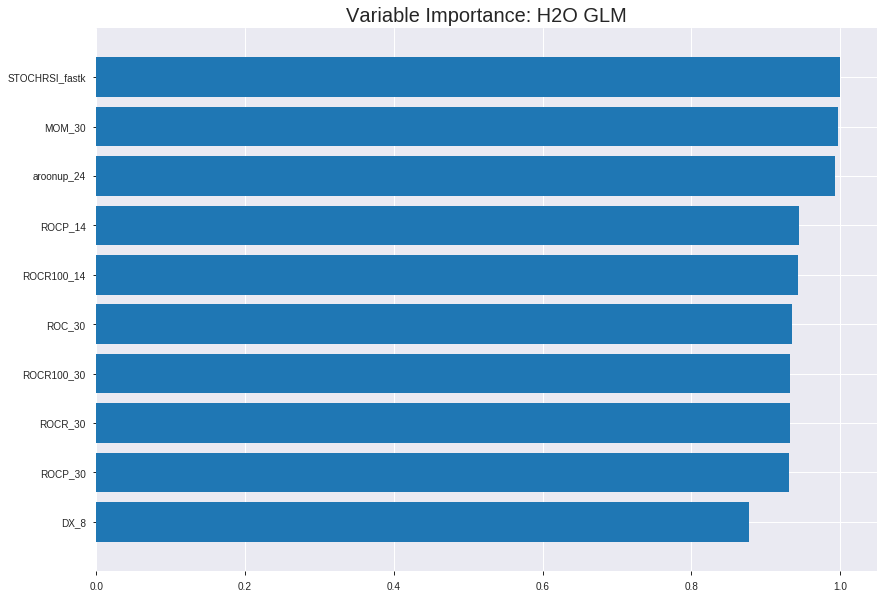

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_204656_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24182837757973097
RMSE: 0.491760488022097
LogLoss: 0.67668156712225
Null degrees of freedom: 1724
Residual degrees of freedom: 1404
Null deviance: 2340.659668736101
Residual deviance: 2334.5514065717625
AIC: 2976.5514065717625
AUC: 0.5443744374437444
pr_auc: 0.614996433970892
Gini: 0.08874887488748873
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5344584921473795: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    712   0.9958   (712.0/715.0)
1      0    1010  0        (0.0/1010.0)
Total  3    1722  0.4128   (712.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.534458     0.739385  397
max f2                       0.534458     0.876432  397
max f0point5                 0.548028     0.640127  386
max accuracy                 0.548028     0.588406  386
max precision                0.653348     1         0
max recall                   0.534458     1         397
max specificity              0.653348     1         0
max absolute_mcc             0.577338     0.101457  259
max min_per_class_accuracy   0.583503     0.534653  216
max mean_per_class_accuracy  0.577338     0.548688  259

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 58.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.632934           1.13861   1.13861            0.666667         0.641326  0.666667                    0.641326            0.0118812       0.0118812                  13.8614   13.8614
    2        0.0202899                   0.628183           1.10513   1.12235            0.647059         0.629463  0.657143                    0.635564            0.0108911       0.0227723                  10.5125   12.2348
    3        0.0301449                   0.62391            1.10513   1.11672            0.647059         0.625782  0.653846                    0.632366            0.0108911       0.0336634                  10.5125   11.6717
    4        0.04                        0.622115           1.10513   1.11386            0.647059         0.622923  0.652174                    0.630039            0.0108911       0.0445545                  10.5125   11.3861
    5        0.0504348                   0.619119           1.2335    1.13861            0.722222         0.620673  0.666667                    0.628102            0.0128713       0.0574257                  23.3498   13.8614
    6        0.10029                     0.609774           0.85396   0.99711            0.5              0.614043  0.583815                    0.621113            0.0425743       0.1                        -14.604   -0.289017
    7        0.150145                    0.604162           1.15185   1.04849            0.674419         0.606686  0.6139                      0.616322            0.0574257       0.157426                   15.1854   4.84919
    8        0.2                         0.598719           1.09227   1.05941            0.639535         0.601472  0.62029                     0.612621            0.0544554       0.211881                   9.22749   5.94059
    9        0.30029                     0.591951           1.08596   1.06827            0.635838         0.595173  0.625483                    0.606793            0.108911        0.320792                   8.59612   6.82748
    10       0.4                         0.587311           1.01284   1.05446            0.593023         0.589568  0.617391                    0.6025              0.10099         0.421782                   1.28367   5.44554
    11       0.50029                     0.583643           1.08596   1.06077            0.635838         0.585472  0.621089                    0.599086            0.108911        0.530693                   8.59612   6.07712
    12       0.6                         0.579524           1.02277   1.05446            0.598837         0.581448  0.617391                    0.596155            0.10198         0.632673                   2.27665   5.44554
    13       0.69971                     0.575756           0.973118  1.04286            0.569767         0.577692  0.610605                    0.593524            0.0970297       0.729703                   -2.68823  4.28646
    14       0.8                         0.571737           0.888514  1.02351            0.520231         0.573775  0.599275                    0.591048            0.0891089       0.818812                   -11.1486  2.35149
    15       0.89971                     0.565783           0.88375   1.00803            0.517442         0.569199  0.590206                    0.588627            0.0881188       0.906931                   -11.625   0.802542
    16       1                           0.530777           0.928003  1                  0.543353         0.557523  0.585507                    0.585507      



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24341926112913576
RMSE: 0.49337537547909277
LogLoss: 0.6799404671265836
Null degrees of freedom: 492
Residual degrees of freedom: 172
Null deviance: 668.7154569489843
Residual deviance: 670.4213005868114
AIC: 1312.4213005868114
AUC: 0.4978712938462582
pr_auc: 0.5802760958323696
Gini: -0.004257412307483555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5299160894116585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    289  0        (0.0/289.0)
Total  0    493  0.4138   (204.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.529916     0.73913    399
max f2                       0.529916     0.876289   399
max f0point5                 0.532612     0.639198   395
max accuracy                 0.532612     0.586207   395
max precision                0.624077     1          0
max recall                   0.529916     1          399
max specificity              0.624077     1          0
max absolute_mcc             0.534075     0.0624602  390
max min_per_class_accuracy   0.561619     0.495098   198
max mean_per_class_accuracy  0.56883      0.515138   135

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 56.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010142                    0.607632           1.02353   1.02353            0.6              0.618974  0.6                         0.618974            0.0103806       0.0103806                  2.35294    2.35294
    2        0.020284                    0.599462           0.682353  0.852941           0.4              0.602067  0.5                         0.610521            0.00692042      0.017301                   -31.7647   -14.7059
    3        0.030426                    0.592524           1.36471   1.02353            0.8              0.5962    0.6                         0.605747            0.0138408       0.0311419                  36.4706    2.35294
    4        0.040568                    0.590058           1.02353   1.02353            0.6              0.591406  0.6                         0.602162            0.0103806       0.0415225                  2.35294    2.35294
    5        0.0507099                   0.588289           0.682353  0.955294           0.4              0.589229  0.56                        0.599575            0.00692042      0.0484429                  -31.7647   -4.47059
    6        0.10142                     0.580642           0.955294  0.955294           0.56             0.584414  0.56                        0.591995            0.0484429       0.0968858                  -4.47059   -4.47059
    7        0.150101                    0.577232           0.995098  0.968203           0.583333         0.578677  0.567568                    0.587676            0.0484429       0.145329                   -0.490196  -3.17965
    8        0.200811                    0.575281           1.02353   0.982175           0.6              0.576087  0.575758                    0.584749            0.0519031       0.197232                   2.35294    -1.78253
    9        0.300203                    0.570081           1.11405   1.02583            0.653061         0.572618  0.601351                    0.580733            0.110727        0.307958                   11.4046    2.58347
    10       0.399594                    0.56546            0.870348  0.98716            0.510204         0.567759  0.57868                     0.577506            0.0865052       0.394464                   -12.9652   -1.28397
    11       0.501014                    0.561619           1.02353   0.994523           0.6              0.563617  0.582996                    0.574694            0.103806        0.49827                    2.35294    -0.547749
    12       0.600406                    0.557887           1.0096    0.997019           0.591837         0.55983   0.584459                    0.572234            0.100346        0.598616                   0.960384   -0.298092
    13       0.699797                    0.553285           1.0096    0.998806           0.591837         0.555616  0.585507                    0.569873            0.100346        0.698962                   0.960384   -0.119352
    14       0.799189                    0.549762           1.04442   1.00448            0.612245         0.551727  0.588832                    0.567617            0.103806        0.802768                   4.44178    0.447895
    15       0.89858                     0.543207           1.04442   1.0089             0.612245         0.546714  0.591422                    0.565305            0.103806        0.906574                   4.44178    0.889656
    16       1                           0.529916           0.921176  1                  0.54             0.537056  0.586207      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 20:46:56  0.000 sec   2            2.3       321           1.35336           1.35988
    2019-08-24 20:46:56  0.098 sec   3            1.7       321           1.35283           1.3602
    2019-08-24 20:46:57  0.205 sec   4            1.2       321           1.35222           1.36046
    2019-08-24 20:46:57  0.307 sec   5            0.89      321           1.35152           1.36071
    2019-08-24 20:46:57  0.404 sec   6            0.65      321           1.35072           1.36094

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5465587044534413)

('F1', 0.6883468834688345)

('auc', 0.5297595585337012)

('logloss', 0.6926586677151881)

('mean_per_class_error', 0.4534226777033241)

('rmse', 0.4997413005331787)

('mse', 0.24974136745859285)

glm prediction progress: |████████████████████████████████████████████████| 100%


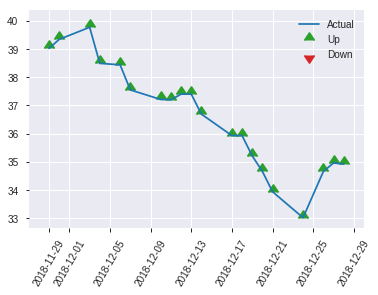


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24974136745859285
RMSE: 0.4997413005331787
LogLoss: 0.6926586677151881
Null degrees of freedom: 246
Residual degrees of freedom: -74
Null deviance: 345.9465433426434
Residual deviance: 342.17338185130296
AIC: 984.173381851303
AUC: 0.5297595585337012
pr_auc: 0.5368714381000688
Gini: 0.059519117067402316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5023399578958874: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    113  0.9576   (113.0/118.0)
1      2    127  0.0155   (2.0/129.0)
Total  7    240  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.50234      0.688347   239
max f2                       0.495367     0.846457   245
max f0point5                 0.525882     0.587949   224
max accuracy                 0.527608     0.546559   220
max precision                0.650684     1          0
max recall                   0.495367     1          245
max specificity              0.650684     1          0
max absolute_mcc             0.556432     0.0997636  78
max min_per_class_accuracy   0.543047     0.533898   123
max mean_per_class_accuracy  0.556432     0.546577   78

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 54.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.626576           1.27649   1.27649            0.666667         0.637679  0.666667                    0.637679            0.0155039       0.0155039                  27.6486    27.6486
    2        0.0202429                   0.621399           0.957364  1.14884            0.5              0.625023  0.6                         0.632616            0.00775194      0.0232558                  -4.26357   14.8837
    3        0.0323887                   0.604345           0.638243  0.957364           0.333333         0.612269  0.5                         0.624986            0.00775194      0.0310078                  -36.1757   -4.26357
    4        0.0404858                   0.59823            0         0.765891           0                0.599615  0.4                         0.619912            0               0.0310078                  -100       -23.4109
    5        0.0526316                   0.593049           1.27649   0.883721           0.666667         0.596427  0.461538                    0.614492            0.0155039       0.0465116                  27.6486    -11.6279
    6        0.101215                    0.580743           1.11693   0.995659           0.583333         0.58871   0.52                        0.602117            0.0542636       0.100775                   11.6925    -0.434109
    7        0.149798                    0.572886           1.11693   1.03499            0.583333         0.576868  0.540541                    0.593928            0.0542636       0.155039                   11.6925    3.49885
    8        0.202429                    0.56789            1.17829   1.07225            0.615385         0.570059  0.56                        0.587722            0.0620155       0.217054                   17.8295    7.22481
    9        0.299595                    0.557804           1.19671   1.11261            0.625            0.562388  0.581081                    0.579506            0.116279        0.333333                   19.6705    11.2613
    10       0.40081                     0.549018           0.995659  1.08308            0.52             0.553862  0.565657                    0.57303             0.100775        0.434109                   -0.434109  8.30789
    11       0.502024                    0.543047           0.995659  1.06545            0.52             0.546395  0.556452                    0.56766             0.100775        0.534884                   -0.434109  6.54539
    12       0.59919                     0.539328           0.877584  1.03499            0.458333         0.54132   0.540541                    0.563389            0.0852713       0.620155                   -12.2416   3.49885
    13       0.700405                    0.536755           0.765891  0.996102           0.4              0.537891  0.520231                    0.559704            0.0775194       0.697674                   -23.4109   -0.389837
    14       0.797571                    0.533487           1.11693   1.01082            0.583333         0.535345  0.527919                    0.556737            0.108527        0.806202                   11.6925    1.08212
    15       0.898785                    0.52706            1.14884   1.02636            0.6              0.530599  0.536036                    0.553793            0.116279        0.922481                   14.8837    2.63636
    16       1                           0.493777           0.765891  1                  0.4              0.512277  0.522267             

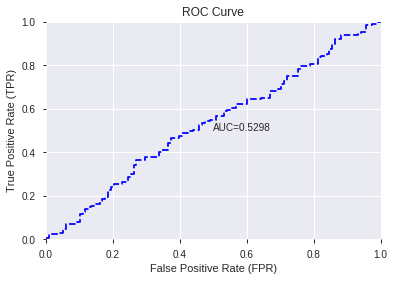

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


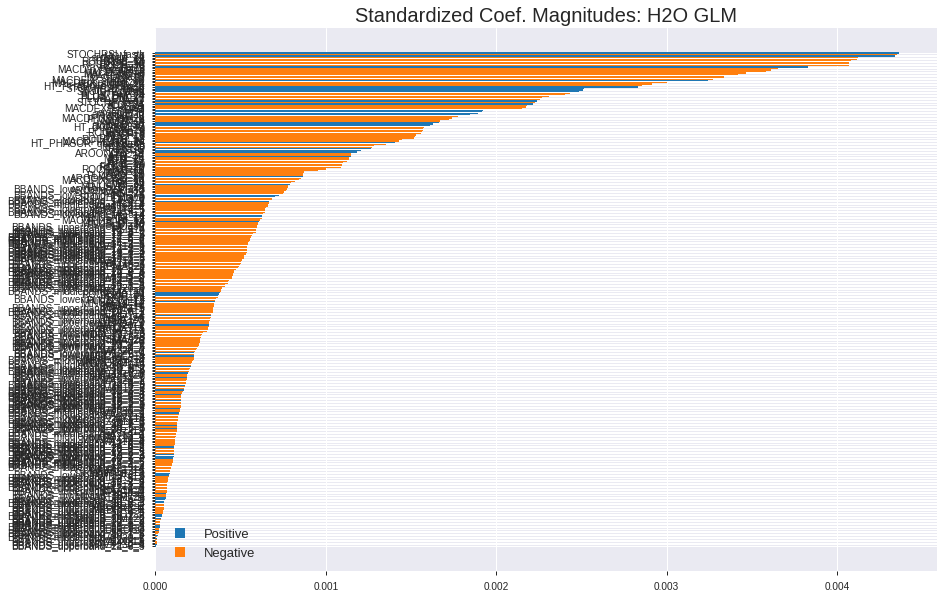

'log_likelihood'
--2019-08-24 20:47:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_204656_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_204656_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['STOCHRSI_fastk',
 'MOM_30',
 'aroonup_24',
 'ROCP_14',
 'ROCR100_14',
 'ROC_30',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'DX_8',
 'MACDFIX_signal_8',
 'MOM_14',
 'MACD_signal',
 'MACDFIX_20',
 'MACDFIX_8',
 'MACD',
 'TRIX_12',
 'MACDFIX_signal_20',
 'aroondown_30',
 'MACDFIX_signal_24',
 'TRIX_8',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastd',
 'STOCH_slowk',
 'STOCHF_fastd',
 'ADX_8',
 'PLUS_DM_14',
 'PLUS_DM_24',
 'PLUS_DM_12',
 'MACDEXT',
 'APO',
 'STOCHF_fastk',
 'ADX_24',
 'CCI_24',
 'ADX_20',
 'MACDEXT_signal',
 'PPO',
 'CCI_30',
 'aroonup_8',
 'aroonup_30',
 'ADXR_8',
 'MACDFIX_hist_24',
 'PLUS_DM_8',
 'NATR_14',
 'NATR_8',
 'WILLR_30',
 'aroonup_20',
 'HT_DCPERIOD',
 'DX_24',
 'NATR_20',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_12',
 'ROCR_12',
 'ROCR100_12',
 'MACDFIX_hist_20',
 'NATR_24',
 'HT_PHASOR_quadrature',
 'DX_20',
 'NATR_30',
 'TRANGE',
 'CCI_8',
 'CCI_14',
 'AROONOSC_8',
 'ATR_14',
 'ATR_30',
 'MOM_24',
 'ATR_20',
 'ATR_12',
 'ATR_24',
 'ROC_20',
 'ROCP_20',
 'ROCR_20'

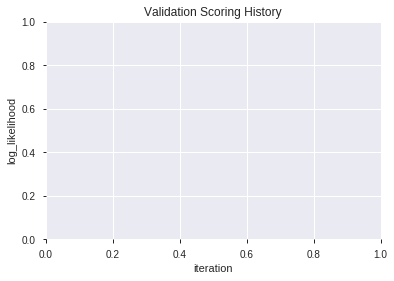

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_204709_model_1  0.505157  0.781569              0.495763  0.537271  0.288660
1               XGBoost_2_AutoML_20190824_204709  0.500460  0.721788              0.500000  0.513370  0.263549
2  XGBoost_grid_1_AutoML_20190824_204709_model_3  0.495139  0.792877              0.486927  0.543298  0.295173
3  XGBoost_grid_1_AutoML_20190824_204709_model_7  0.488109  0.749653              0.495401  0.525250  0.275887
4  XGBoost_grid_1_AutoML_20190824_204709_model_4  0.487025  0.707637              0.500000  0.506935  0.256983
5               XGBoost_1_AutoML_20190824_204709  0.485613  0.741882              0.495763  0.521745  0.272217
6  XGBoost_grid_1_AutoML_20190824_204709_model_5  0.472080  0.809070              0.500000  0.547371  0.299615
7               XGBoost_3_AutoML_20190824_204709  0.461733  0.748030              0.495401  0.525064  0.275693
8  XGBoost_grid_1_AutoML_20190824_204709_model_2  0.458218  0.713224              0.495763  0.509747  0.259842
9  XGBoost_grid_1_AutoML_20190824_204709_model_6  0.441138  0.785508              0.500000  0.540141  0.291752

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD           137.483490           1.000000    0.037146
1       HT_PHASOR_quadrature           123.668884           0.899518    0.033414
2          MACDFIX_signal_24           107.686409           0.783268    0.029096
3                     ADX_14            85.340240           0.620731    0.023058
4          HT_PHASOR_inphase            74.393692           0.541110    0.020100
..                       ...                  ...                ...         ...
152  BBANDS_upperband_20_1_2             3.713862           0.027013    0.001003
153               MACDFIX_20             3.434964           0.024985    0.000928
154  BBANDS_lowerband_14_3_2             2.909340           0.021161    0.000786
155  BBANDS_upperband_24_3_5             2.523403           0.018354    0.000682
156                   TRANGE             1.426546           0.010376    0.000385

[157 rows x 4 columns]

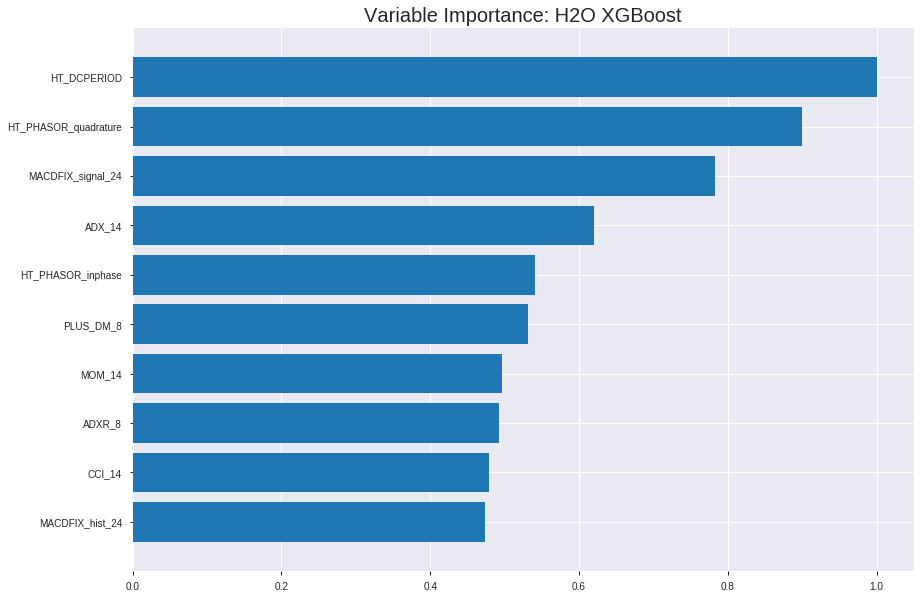

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_204709_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19253364118286762
RMSE: 0.43878655538070854
LogLoss: 0.574038293321413
Mean Per-Class Error: 0.16603891158346606
AUC: 0.9101260126012601
pr_auc: 0.930428967739787
Gini: 0.8202520252025203
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5637986660003662: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      547  168   0.235    (168.0/715.0)
1      110  900   0.1089   (110.0/1010.0)
Total  657  1068  0.1612   (278.0/1725.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.563799     0.866218  216
max f2                       0.524748     0.912055  264
max f0point5                 0.586914     0.875725  185
max accuracy                 0.563799     0.838841  216
max precision                0.791362     1         0
max recall                   0.3806       1         370
max specificity              0.791362     1         0
max absolute_mcc             0.563799     0.665628  216
max min_per_class_accuracy   0.57638      0.829371  199
max mean_per_class_accuracy  0.574414     0.833961  202

Gains/Lift Table: Avg response rate: 58.55 %, avg score: 57.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104348                   0.75412            1.70792   1.70792            1                0.767531  1                           0.767531            0.0178218       0.0178218                  70.7921   70.7921
    2        0.0202899                   0.736392           1.70792   1.70792            1                0.744398  1                           0.756295            0.0168317       0.0346535                  70.7921   70.7921
    3        0.0301449                   0.72562            1.70792   1.70792            1                0.731349  1                           0.74814             0.0168317       0.0514851                  70.7921   70.7921
    4        0.04                        0.718511           1.70792   1.70792            1                0.72174   1                           0.741635            0.0168317       0.0683168                  70.7921   70.7921
    5        0.0504348                   0.713351           1.61304   1.68829            0.944444         0.715941  0.988506                    0.736319            0.0168317       0.0851485                  61.3036   68.829
    6        0.10029                     0.687818           1.6682    1.6783             0.976744         0.700346  0.982659                    0.718437            0.0831683       0.168317                   66.8202   67.8304
    7        0.150145                    0.667743           1.6682    1.67495            0.976744         0.676345  0.980695                    0.70446             0.0831683       0.251485                   66.8202   67.4949
    8        0.2                         0.649679           1.62848   1.66337            0.953488         0.659132  0.973913                    0.693161            0.0811881       0.332673                   62.8483   66.3366
    9        0.30029                     0.625454           1.56971   1.63209            0.919075         0.637518  0.955598                    0.674578            0.157426        0.490099                   56.9708   63.2086
    10       0.4                         0.60572            1.54904   1.61139            0.906977         0.615652  0.943478                    0.659889            0.154455        0.644554                   54.9044   61.1386
    11       0.50029                     0.587416           1.28341   1.54564            0.751445         0.596474  0.904983                    0.647176            0.128713        0.773267                   28.3409   54.5639
    12       0.6                         0.566917           0.983047  1.45215            0.575581         0.577424  0.850242                    0.635585            0.0980198       0.871287                   -1.69526  45.2145
    13       0.69971                     0.544749           0.744733  1.35134            0.436047         0.556569  0.791218                    0.624325            0.0742574       0.945545                   -25.5267  35.1337
    14       0.8                         0.511636           0.286299  1.21782            0.16763          0.530368  0.713043                    0.612546            0.0287129       0.974257                   -71.3701  21.7822
    15       0.89971                     0.459287           0.178736  1.10267            0.104651         0.488058  0.645619                    0.59875             0.0178218       0.992079                   -82.1264  10.2665
    16       1                           0.246706           0.078979  1                  0.0462428        0.399601  0.585507                    0.578777          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.30808154450479974
RMSE: 0.5550509386577053
LogLoss: 0.8230025090097453
Mean Per-Class Error: 0.464677047289504
AUC: 0.5186495013230206
pr_auc: 0.610378530190163
Gini: 0.037299002646041135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1841021478176117: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    197  0.9657   (197.0/204.0)
1      2    287  0.0069   (2.0/289.0)
Total  9    484  0.4037   (199.0/493.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.184102     0.742561  392
max f2                       0.160341     0.876289  399
max f0point5                 0.184102     0.644944  392
max accuracy                 0.184102     0.596349  392
max precision                0.735108     1         0
max recall                   0.160341     1         399
max specificity              0.735108     1         0
max absolute_mcc             0.184102     0.100778  392
max min_per_class_accuracy   0.31457      0.49481   216
max mean_per_class_accuracy  0.270236     0.535323  282

Gains/Lift Table: Avg response rate: 58.62 %, avg score: 35.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010142                    0.676786           1.36471   1.36471            0.8              0.695615  0.8                         0.695615            0.0138408       0.0138408                  36.4706   36.4706
    2        0.020284                    0.633502           1.70588   1.53529            1                0.657302  0.9                         0.676459            0.017301        0.0311419                  70.5882   53.5294
    3        0.030426                    0.621928           1.02353   1.36471            0.6              0.627775  0.8                         0.660231            0.0103806       0.0415225                  2.35294   36.4706
    4        0.040568                    0.605204           0.682353  1.19412            0.4              0.613771  0.7                         0.648616            0.00692042      0.0484429                  -31.7647  19.4118
    5        0.0507099                   0.596196           1.70588   1.29647            1                0.601967  0.76                        0.639286            0.017301        0.0657439                  70.5882   29.6471
    6        0.10142                     0.559018           0.887059  1.09176            0.52             0.577926  0.64                        0.608606            0.0449827       0.110727                   -11.2941  9.17647
    7        0.150101                    0.524225           1.06618   1.08347            0.625            0.541806  0.635135                    0.586941            0.0519031       0.16263                    6.61765   8.34658
    8        0.200811                    0.487886           0.614118  0.964944           0.36             0.506786  0.565657                    0.5667              0.0311419       0.193772                   -38.5882  -3.50564
    9        0.300203                    0.39843            1.07923   1.00278            0.632653         0.437217  0.587838                    0.523831            0.107266        0.301038                   7.92317   0.278219
    10       0.399594                    0.351647           1.04442   1.01314            0.612245         0.372422  0.593909                    0.486171            0.103806        0.404844                   4.44178   1.31383
    11       0.501014                    0.311471           0.887059  0.987616           0.52             0.332781  0.578947                    0.45512             0.0899654       0.49481                    -11.2941  -1.23839
    12       0.600406                    0.289599           1.14886   1.01431            0.673469         0.300439  0.594595                    0.429514            0.114187        0.608997                   14.886    1.43084
    13       0.699797                    0.2681             1.14886   1.03342            0.673469         0.277643  0.605797                    0.407944            0.114187        0.723183                   14.886    3.34186
    14       0.799189                    0.247137           0.835534  1.00881            0.489796         0.25829   0.591371                    0.389332            0.083045        0.806228                   -16.4466  0.88086
    15       0.89858                     0.228694           1.11405   1.02045            0.653061         0.23817   0.598194                    0.372612            0.110727        0.916955                   11.4046   2.04488
    16       1                           0.160341           0.818824  1                  0.48             0.203362  0.586207                    0.355447      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 20:47:17  0.013 sec   0                  0.5              0.693147            0.5             0                  1                0.414493                         0.5                0.693147              0.5               0                    1                  0.413793
    2019-08-24 20:47:17  0.191 sec   5                  0.490855         0.674978            0.684563        0.754623           1.70792          0.36                             0.507727           0.708819              0.512891          0.591625             1.02353            0.40568
    2019-08-24 20:47:17  0.254 sec   10                 0.48367          0.660812            0.748759        0.80577            1.70792          0.325217                         0.51783            0.730189              0.500441          0.597525             1.02353            0.409736
    2019-08-24 20:47:17  0.317 sec   15                 0.477503         0.648708            0.781986        0.835072           1.70792          0.315942                         0.522594           0.740641              0.493317          0.595656             1.02353            0.407708
    2019-08-24 20:47:17  0.388 sec   20                 0.470549         0.635146            0.825844        0.868776           1.70792          0.266087                         0.522927           0.741463              0.511288          0.605372             1.36471            0.403651
    2019-08-24 20:47:17  0.457 sec   25                 0.465003         0.624344            0.851799        0.891714           1.70792          0.234783                         0.531801           0.761943              0.50921           0.606837             1.36471            0.393509
    2019-08-24 20:47:17  0.523 sec   30                 0.459887         0.614422            0.864371        0.899917           1.70792          0.21913                          0.540756           0.78389               0.516707          0.608798             1.70588            0.403651
    2019-08-24 20:47:17  0.592 sec   35                 0.454395         0.60379             0.879416        0.912119           1.70792          0.211014                         0.543397           0.790953              0.512789          0.609688             1.70588            0.403651
    2019-08-24 20:47:17  0.659 sec   40                 0.449792         0.594908            0.885326        0.916228           1.70792          0.198261                         0.550916           0.811319              0.519574          0.613842             1.70588            0.40568
    2019-08-24 20:47:17  0.737 sec   45                 0.443234         0.582514            0.903756        0.928001           1.70792          0.177971                         0.552318           0.815262              0.515189          0.610474             1.36471            0.403651
    2019-08-24 20:47:17  0.811 sec   50                 0.438787         0.574038            0.910126        0.930429           1.70792          0.161159                         0.555051           0.823003              0.51865           0.610379             1.36471            0.403651

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
HT_DCPERIOD              137.48348999023438     1.0                   0.037146336504797234
HT_PHASOR_quadrature     123.66888427734375     0.8995180751239884    0.03341380111070315
MACDFIX_signal_24        107.68640899658203     0.7832679327840102    0.02909553420461174
ADX_14                   85.34024047851562      0.6207308272766239    0.02305787618891864
HT_PHASOR_inphase        74.39369201660156      0.5411100054405503    0.020100254348207343
---                      ---                    ---                   ---
BBANDS_upperband_20_1_2  3.7138619422912598     0.0270131485791862    0.0010034395071765359
MACDFIX_20               3.434964179992676      0.024984557638423825  0.0009280847854603935
BBANDS_lowerband_14_3_2  2.9093399047851562     0.02116137657686614   0.0007860676152290038
BBANDS_upperband_24_3_5  2.5234029293060303     0.018354225147217827  0.000681792223603365
TRANGE                   1.4265460968017578     0.010376126594568462  0.00038543509009821583


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5303643724696356)

('F1', 0.6880000000000001)

('auc', 0.5051570095913809)

('logloss', 0.7815693377564294)

('mean_per_class_error', 0.47099592694783865)

('rmse', 0.5372707106859922)

('mse', 0.28865981656103107)

xgboost prediction progress: |████████████████████████████████████████████| 100%


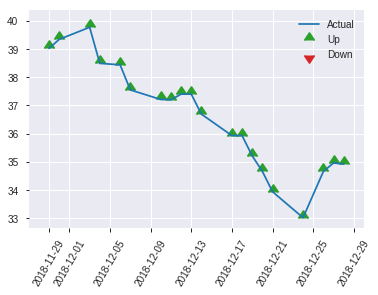


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.28865981656103107
RMSE: 0.5372707106859922
LogLoss: 0.7815693377564294
Mean Per-Class Error: 0.47099592694783865
AUC: 0.5051570095913809
pr_auc: 0.5410953760101345
Gini: 0.010314019182761758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14499659836292267: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    117  0.9915   (117.0/118.0)
1      0    129  0        (0.0/129.0)
Total  1    246  0.4737   (117.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.144997     0.688     243
max f2                       0.144997     0.846457  243
max f0point5                 0.144997     0.579515  243
max accuracy                 0.276498     0.530364  192
max precision                0.640828     1         0
max recall                   0.144997     1         243
max specificity              0.640828     1         0
max absolute_mcc             0.62672      0.10605   2
max min_per_class_accuracy   0.320729     0.503876  121
max mean_per_class_accuracy  0.386883     0.529004  63

Gains/Lift Table: Avg response rate: 52.23 %, avg score: 34.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.626697           1.91473   1.91473            1                0.632283  1                           0.632283            0.0232558       0.0232558                  91.4729    91.4729
    2        0.0202429                   0.582812           0         1.14884            0                0.622261  0.6                         0.628274            0               0.0232558                  -100       14.8837
    3        0.0323887                   0.563695           1.91473   1.43605            1                0.572783  0.75                        0.607465            0.0232558       0.0465116                  91.4729    43.6047
    4        0.0404858                   0.556694           0         1.14884            0                0.560161  0.6                         0.598004            0               0.0465116                  -100       14.8837
    5        0.0526316                   0.548659           1.27649   1.17829            0.666667         0.554338  0.615385                    0.587927            0.0155039       0.0620155                  27.6486    17.8295
    6        0.101215                    0.491542           0.797804  0.995659           0.416667         0.520049  0.52                        0.555346            0.0387597       0.100775                   -20.2196   -0.434109
    7        0.149798                    0.464428           1.11693   1.03499            0.583333         0.479538  0.540541                    0.530759            0.0542636       0.155039                   11.6925    3.49885
    8        0.202429                    0.418245           1.17829   1.07225            0.615385         0.452654  0.56                        0.510452            0.0620155       0.217054                   17.8295    7.22481
    9        0.299595                    0.365159           0.957364  1.03499            0.5              0.391342  0.540541                    0.471822            0.0930233       0.310078                   -4.26357   3.49885
    10       0.40081                     0.342654           0.995659  1.02506            0.52             0.353706  0.535354                    0.441995            0.100775        0.410853                   -0.434109  2.50568
    11       0.502024                    0.31886            0.91907   1.00369            0.48             0.329609  0.524194                    0.419336            0.0930233       0.503876                   -8.09302   0.368842
    12       0.59919                     0.308799           0.877584  0.983239           0.458333         0.313049  0.513514                    0.4021              0.0852713       0.589147                   -12.2416   -1.67609
    13       0.700405                    0.295255           0.91907   0.973966           0.48             0.302681  0.508671                    0.387733            0.0930233       0.682171                   -8.09302   -2.6034
    14       0.797571                    0.275374           1.27649   1.01082            0.666667         0.283866  0.527919                    0.375079            0.124031        0.806202                   27.6486    1.08212
    15       0.898785                    0.240044           0.842481  0.991864           0.44             0.260485  0.518018                    0.362175            0.0852713       0.891473                   -15.7519   -0.813604
    16       1                           0.138255           1.07225   1                  0.56             0.193179  0.522267              

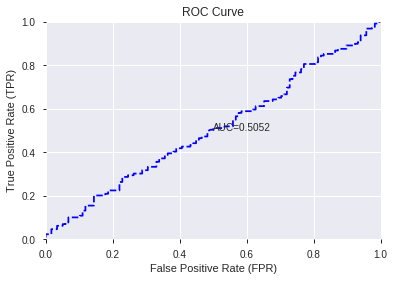

This function is available for GLM models only


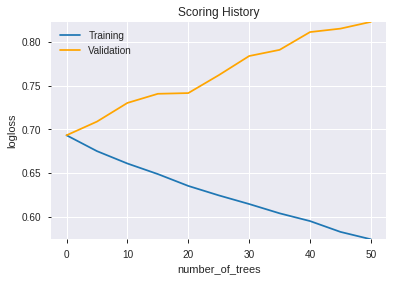

--2019-08-24 20:47:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_204709_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_204709_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9375',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'MACDFIX_signal_24',
 'ADX_14',
 'HT_PHASOR_inphase',
 'PLUS_DM_8',
 'MOM_14',
 'ADXR_8',
 'CCI_14',
 'MACDFIX_hist_24',
 'STOCHRSI_fastd',
 'ROCP_8',
 'AROONOSC_30',
 'STOCHRSI_fastk',
 'DX_8',
 'ULTOSC',
 'MACD_signal',
 'MACDEXT_signal',
 'MINUS_DM_24',
 'aroonup_24',
 'ADX_8',
 'MACDFIX_hist_20',
 'ATR_12',
 'STOCH_slowd',
 'APO',
 'ROCP_14',
 'BBANDS_lowerband_30_5_3',
 'ADX_24',
 'BBANDS_upperband_14_0_5',
 'STOCH_slowk',
 'ROCR_12',
 'MOM_24',
 'TRIX_12',
 'MACD_hist',
 'PLUS_DM_24',
 'ATR_30',
 'CCI_24',
 'MOM_30',
 'ROC_20',
 'WILLR_12',
 'BBANDS_upperband_30_7_5',
 'MAVP_12_5',
 'ROC_24',
 'MACDFIX_signal_20',
 'PLUS_DM_14',
 'ADXR_12',
 'DX_14',
 'DX_30',
 'MAVP_14_2',
 'WILLR_20',
 'MINUS_DM_20',
 'CMO_30',
 'BBANDS_upperband_14_1_4',
 'WILLR_30',
 'ROC_12',
 'BBANDS_lowerband_30_2_4',
 'WILLR_24',
 'CMO_14',
 'DX_24',
 'DX_12',
 'BBANDS_upperband_30_7_4',
 'aroondown_30',
 'CMO_8',
 'DX_20',
 'MINUS_DI_30',
 'BBANDS_upperband_30_5_

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.571
GLM             0.547
XGBoost         0.551
dtype: float64

DeepLearning    GLM  XGBoost
All          0.538  0.522    0.551
DLF          0.571  0.522    0.551
Fwe          0.571  0.522    0.551
RFE          0.543  0.547    0.530
XGBF         0.567  0.522    0.551





F1


DeepLearning    0.686
GLM             0.688
XGBoost         0.696
dtype: float64

DeepLearning    GLM  XGBoost
All          0.686  0.686    0.686
DLF          0.686  0.686    0.696
Fwe          0.686  0.686    0.686
RFE          0.686  0.688    0.688
XGBF         0.686  0.686    0.696





auc


DeepLearning    0.574
GLM             0.530
XGBoost         0.517
dtype: float64

DeepLearning    GLM  XGBoost
All          0.542  0.523    0.517
DLF          0.574  0.516    0.473
Fwe          0.565  0.523    0.517
RFE          0.516  0.530    0.505
XGBF         0.568  0.516    0.473





logloss


DeepLearning    17.069
GLM             17.665
XGBoost          0.782
dtype: float64

DeepLearning     GLM  XGBoost
All         17.069  17.625    0.729
DLF         16.124  17.665    0.701
Fwe         11.779  17.625    0.729
RFE          0.730   0.693    0.782
XGBF        16.973  17.665    0.701





mean_per_class_error


DeepLearning    0.456
GLM             0.479
XGBoost         0.471
dtype: float64

DeepLearning    GLM  XGBoost
All          0.452  0.476    0.446
DLF          0.426  0.479    0.468
Fwe          0.426  0.476    0.446
RFE          0.456  0.453    0.471
XGBF         0.426  0.479    0.468





rmse


DeepLearning    0.724
GLM             0.721
XGBoost         0.537
dtype: float64

DeepLearning    GLM  XGBoost
All          0.724  0.721    0.516
DLF          0.722  0.721    0.504
Fwe          0.713  0.721    0.516
RFE          0.513  0.500    0.537
XGBF         0.721  0.721    0.504





mse


DeepLearning    0.525
GLM             0.520
XGBoost         0.289
dtype: float64

DeepLearning   GLM  XGBoost
All          0.525  0.52    0.266
DLF          0.521  0.52    0.254
Fwe          0.509  0.52    0.266
RFE          0.264  0.25    0.289
XGBF         0.519  0.52    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.686    NaN      NaN
 DLF          0.686    NaN      NaN
 DLF            NaN  0.686      NaN
 DLF            NaN    NaN    0.696
 All            NaN  0.686      NaN
 All            NaN    NaN    0.686
 XGBF         0.686    NaN      NaN
 XGBF           NaN  0.686      NaN
 XGBF           NaN    NaN    0.696
 Fwe          0.686    NaN      NaN
 Fwe            NaN  0.686      NaN
 Fwe            NaN    NaN    0.686
 RFE          0.686    NaN      NaN
 RFE            NaN  0.688      NaN
 RFE            NaN    NaN    0.688,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.538    NaN      NaN
 DLF          0.571    NaN      NaN
 DLF            NaN  0.522      NaN
 DLF            NaN    NaN    0.551
 All            NaN  0.522      NaN
 All            NaN    NaN    0.551
 XGBF         0.567    NaN      NaN
 XGBF           NaN  0.522      NaN
 XGBF           NaN    NaN    0.551
 Fwe          0.571    NaN      NaN
 Fwe     